In [1]:
import numpy as np
import gymnasium
from gymnasium.wrappers import TimeLimit
from imitation.data import rollout
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy

from gymnasium.spaces import Box
from gymnasium.envs.registration import register
import racing_gym
import os
import json
from PIL import Image
import torch
import time

rng = np.random.default_rng()


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
from PIL import Image

def load_expert_data_directory(parent_directory):
    # parent_directory内のすべてのディレクトリを取得
    subdirectories = [os.path.join(parent_directory, d) for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    
    all_expert_data = []  # すべてのディレクトリのexpert_dataを格納するリスト

    for data_path in subdirectories:
        # ディレクトリごとにexpert_dataの初期化
        expert_data = {'images': [], 'actions': []}

        # 画像ファイルに対応するJSONファイルを取得
        json_file_list = [json_file for json_file in os.listdir(data_path) if json_file.startswith('record_') and json_file.endswith('.json')]

        for json_file in json_file_list:
            # レコードのファイルパスを構築
            json_path = os.path.join(data_path, json_file)

            # レコードの読み込み
            try:
                with open(json_path, 'r') as json_file:
                    record_data = json.load(json_file)
            except FileNotFoundError:
                print(f"エラー：{json_path} でJSONファイルが見つかりませんでした。")
                continue
            except json.JSONDecodeError:
                print(f"エラー：{json_path} のJSONファイルのデコードに失敗しました。")
                continue

            # 画像データの読み込み
            image_file = record_data.get('cam/image_array', '')  # 画像ファイル名をJSONから取得
            image_path = os.path.join(data_path, image_file)
            try:
                image_data = np.array(Image.open(image_path))
            except FileNotFoundError:
                print(f"エラー：{image_path} で画像ファイルが見つかりませんでした。")
                continue

            # expert_dataに追加
            expert_data['images'].append(image_data)
            expert_data['actions'].append([record_data.get('user/angle', 0), record_data.get('user/throttle', 0)])
        
        # すべてのディレクトリのexpert_dataをリストに追加
        all_expert_data.append(expert_data)


    return all_expert_data


In [3]:
all_expert_data = load_expert_data_directory('../../autorace/data/L/')

In [4]:
from imitation.data.types import Transitions

def convert_to_transitions(expert_data):
    obs_array = []
    next_obs_array = []
    action_array = []
    done_array = []
    info_array = []
    # expert_dataの画像と行動をTrajectoryに変換
    for data in expert_data:
        data_size = len(data['images'])
        obs_array+=data['images']
        n_obs = data['images'].copy()
        n_obs.pop(0)
        x, y, z = data['images'][-1].shape
        n_obs.append(np.zeros((x, y, z), dtype=np.uint8))
        next_obs_array+=(n_obs)
        action_array+=data['actions']
        done_array+=[False]*(data_size-1)+[True]
        info_array+=[{}]*data_size
    transitions=Transitions( 
        obs=np.array(obs_array),
        acts=np.array(action_array),
        next_obs=np.array(next_obs_array),
        dones=np.array(done_array),
        infos=np.array(info_array))


    return transitions

In [5]:
reshaped_all_expert_data = all_expert_data.copy()
# すべてのディレクトリに対して
for i in range(len(reshaped_all_expert_data)):
    # すべての画像を変換
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        # 画像の軸の順序を変更
        reshaped_image = np.transpose(reshaped_all_expert_data[i]['images'][j], (2, 0, 1))
        
        # expert_dataに変更を反映
        reshaped_all_expert_data[i]['images'][j] = reshaped_image.copy()

# 形状を確認
print(reshaped_all_expert_data[0]['images'][0].shape)

for i in range(len(reshaped_all_expert_data)):
    for j in range(len(reshaped_all_expert_data[i]['images'])):
        if reshaped_all_expert_data[i]['images'][j].shape != (3, 224, 224):
            print(i, j)

(3, 224, 224)


In [6]:
print(reshaped_all_expert_data[0]['images'][0].shape)
print(all_expert_data[0]['images'][0].shape)

(3, 224, 224)
(3, 224, 224)


In [7]:
test_transition = convert_to_transitions(all_expert_data)
print(test_transition)


Transitions(obs=array([[[[158, 155, 154, ..., 143, 137, 128],
         [156, 156, 156, ..., 139, 135, 127],
         [154, 156, 158, ..., 136, 133, 127],
         ...,
         [106, 109, 112, ..., 113, 112, 112],
         [108, 111, 113, ..., 113, 112, 114],
         [111, 113, 115, ..., 113, 112, 114]],

        [[103, 100,  99, ..., 141, 135, 126],
         [101, 101, 101, ..., 137, 133, 125],
         [ 99, 101, 103, ..., 134, 131, 125],
         ...,
         [ 55,  58,  61, ..., 116, 115, 115],
         [ 57,  60,  62, ..., 116, 115, 117],
         [ 60,  62,  64, ..., 116, 115, 117]],

        [[ 73,  70,  69, ..., 154, 148, 139],
         [ 71,  71,  71, ..., 150, 146, 138],
         [ 69,  71,  73, ..., 147, 144, 138],
         ...,
         [ 34,  37,  40, ..., 135, 134, 134],
         [ 36,  39,  41, ..., 135, 134, 136],
         [ 39,  41,  43, ..., 135, 134, 136]]],


       [[[169, 170, 171, ..., 138, 145, 150],
         [170, 171, 172, ..., 135, 140, 143],
         [171,

In [8]:
env_id1 = 'RacingEnv-v1'  # あなたの環境の名前に変更してください
try:
    env1 = gymnasium.make(env_id1, expert_data=reshaped_all_expert_data)
    print(f"Environment '{env_id1}' is successfully registered.")
except gymnasium.error.Error as e:
    print(f"Error: {e}")

7
Environment 'RacingEnv-v1' is successfully registered.


/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment RacingEnv-v1 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [9]:
def _make_env():
    """Helper function to create a single environment. Put any logic here, but make sure to return a RolloutInfoWrapper."""
    _env1 = gymnasium.make("RacingEnv-v1", expert_data=reshaped_all_expert_data)
    _env1 = RolloutInfoWrapper(_env1)
    return _env1

venv1 = DummyVecEnv([_make_env for _ in range(4)])

8
16
10
2


In [29]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common.evaluation import evaluate_policy


expert = PPO(
    policy=CnnPolicy,
    env=env1,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
    device='cuda:1'
)
reward, _ = evaluate_policy(expert, env1, 10)
print(f"Reward before training: {reward}")


# Note: if you followed step 2a, i.e. registered the environment, you can use the environment name directly

# expert = PPO(
#     policy=MlpPolicy,
#     env="custom/ObservationMatching-v0",
#     seed=0,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
#     n_steps=64,
# )
expert.learn(1000)  # Note: set to 100000 to train a proficient expert
reward, _ = evaluate_policy(expert, expert.get_env(), 10)
print(f"Expert reward: {reward}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


12
15
0
3
3
7
9
19
18
4
6
Reward before training: 501.9597597211599
12
18
13
16
12
12
11
14
19
2
18
6
Expert reward: 826.7089047


In [30]:

rollouts = rollout.rollout(
    expert,
    venv1,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

1
5
19
7
16
8
0
6
1
0
3
9
15
5
12
2
1
7
11
18
13
12
12
17
9
20
11
3
2
8
10
7
13
8
19
15
19
11
19
17
3
19
4
19
20
15
18
2
9
11
18
20
12
5
15
11
2
10
14
12
10
7


In [49]:
print(len(transitions))
print(len(test_trajectory))

count = 0
for i in range(len(transitions)):
    if transitions[i]['dones']:
        count += 1

print(count)
count = 0
for i in range(len(test_trajectory)):
    if test_trajectory[i]['dones']:
        count += 1

print(count)

58958
22690
53
21


In [38]:
# transitionのdoneがTrueのときのnext_obsをprintしたい
# それを見て、次のobsが正しく取れているか確認したい
for i in range(len(transitions)):
    if transitions[i]['dones']:
        print(transitions[i]['next_obs'])
        a = transitions[i]['next_obs']
        print(transitions[i+1]['obs'])
        print(i)
        break

for i in range(len(transitions)):
    if np.array_equal(a, transitions[i]['obs']):
        print(i)
        break

    if i == len(transitions)-1:
        print("not found")



[[[143 146 143 ... 145 151 148]
  [136 139 137 ... 147 151 143]
  [135 136 134 ... 149 151 137]
  ...
  [ 67  71  74 ... 116 117 122]
  [ 74  76  77 ... 116 116 123]
  [ 78  78  77 ... 116 117 125]]

 [[150 153 150 ... 147 153 150]
  [143 146 144 ... 149 153 145]
  [142 143 141 ... 151 153 139]
  ...
  [ 74  78  81 ... 129 130 135]
  [ 81  83  84 ... 129 129 136]
  [ 84  84  83 ... 129 130 138]]

 [[156 159 156 ... 168 174 171]
  [149 152 150 ... 170 174 166]
  [148 149 147 ... 172 174 160]
  ...
  [ 84  88  91 ... 163 164 169]
  [ 91  93  94 ... 163 163 170]
  [ 96  96  95 ... 163 164 172]]]
[[[ 83  85  87 ... 132 123 126]
  [ 85  86  88 ... 140 131 132]
  [ 88  88  88 ... 145 138 135]
  ...
  [ 84  85  85 ... 103 104 106]
  [ 83  84  86 ... 102 104 108]
  [ 82  84  87 ...  99 102 105]]

 [[ 86  88  90 ... 132 123 126]
  [ 88  89  91 ... 140 131 132]
  [ 91  91  91 ... 145 138 135]
  ...
  [ 50  51  51 ... 108 107 109]
  [ 49  50  52 ... 107 109 111]
  [ 48  50  53 ... 104 107 110]]



In [10]:
from imitation.algorithms import bc
from imitation.util import logger

bc_logger = logger.configure('./log/')
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=test_transition,
    rng=rng,
    policy=ActorCriticCnnPolicy(
        observation_space=env1.observation_space,
        action_space=env1.action_space,
        features_extractor_kwargs=dict(features_dim=256),
        lr_schedule=lambda _: 0.0003,
        ),
    batch_size=2048,
    device="cuda:1",
    custom_logger=bc_logger
)

In [11]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward before training: {reward_before_training}")

/home/anubis/miniconda3/envs/env38/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


0
18
13
17


7
9
21
16
0
0
11
0
10
15
7
20
14
13
Reward before training: 431.148552107811


In [12]:
bc_trainer.train(n_epochs=1000, log_interval=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv1, 10)
print(f"Reward after training: {reward_after_training}")

10batch [00:03,  2.79batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 9        |
|    ent_loss       | -0.00282 |
|    entropy        | 2.82     |
|    epoch          | 1        |
|    l2_loss        | 0        |
|    l2_norm        | 447      |
|    loss           | 2.29     |
|    neglogp        | 2.29     |
|    prob_true_act  | 0.113    |
|    samples_so_far | 20480    |
--------------------------------


20batch [00:07,  2.53batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 19       |
|    ent_loss       | -0.0028  |
|    entropy        | 2.8      |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 476      |
|    loss           | 1.95     |
|    neglogp        | 1.95     |
|    prob_true_act  | 0.144    |
|    samples_so_far | 40960    |
--------------------------------


30batch [00:11,  2.70batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 29       |
|    ent_loss       | -0.00278 |
|    entropy        | 2.78     |
|    epoch          | 3        |
|    l2_loss        | 0        |
|    l2_norm        | 495      |
|    loss           | 1.91     |
|    neglogp        | 1.91     |
|    prob_true_act  | 0.15     |
|    samples_so_far | 61440    |
--------------------------------


40batch [00:15,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 39       |
|    ent_loss       | -0.00275 |
|    entropy        | 2.75     |
|    epoch          | 4        |
|    l2_loss        | 0        |
|    l2_norm        | 506      |
|    loss           | 1.86     |
|    neglogp        | 1.86     |
|    prob_true_act  | 0.156    |
|    samples_so_far | 81920    |
--------------------------------


50batch [00:18,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 49       |
|    ent_loss       | -0.00273 |
|    entropy        | 2.73     |
|    epoch          | 5        |
|    l2_loss        | 0        |
|    l2_norm        | 516      |
|    loss           | 1.82     |
|    neglogp        | 1.83     |
|    prob_true_act  | 0.162    |
|    samples_so_far | 102400   |
--------------------------------


60batch [00:22,  2.64batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 59       |
|    ent_loss       | -0.00271 |
|    entropy        | 2.71     |
|    epoch          | 6        |
|    l2_loss        | 0        |
|    l2_norm        | 526      |
|    loss           | 1.8      |
|    neglogp        | 1.8      |
|    prob_true_act  | 0.167    |
|    samples_so_far | 122880   |
--------------------------------


70batch [00:25,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 69       |
|    ent_loss       | -0.00269 |
|    entropy        | 2.69     |
|    epoch          | 7        |
|    l2_loss        | 0        |
|    l2_norm        | 538      |
|    loss           | 1.78     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.17     |
|    samples_so_far | 143360   |
--------------------------------


80batch [00:29,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 79       |
|    ent_loss       | -0.00267 |
|    entropy        | 2.67     |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 550      |
|    loss           | 1.75     |
|    neglogp        | 1.75     |
|    prob_true_act  | 0.175    |
|    samples_so_far | 163840   |
--------------------------------


90batch [00:32,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 89       |
|    ent_loss       | -0.00264 |
|    entropy        | 2.64     |
|    epoch          | 9        |
|    l2_loss        | 0        |
|    l2_norm        | 561      |
|    loss           | 1.73     |
|    neglogp        | 1.73     |
|    prob_true_act  | 0.179    |
|    samples_so_far | 184320   |
--------------------------------


100batch [00:36,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 99       |
|    ent_loss       | -0.00262 |
|    entropy        | 2.62     |
|    epoch          | 10       |
|    l2_loss        | 0        |
|    l2_norm        | 571      |
|    loss           | 1.71     |
|    neglogp        | 1.71     |
|    prob_true_act  | 0.182    |
|    samples_so_far | 204800   |
--------------------------------


110batch [00:40,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 109      |
|    ent_loss       | -0.0026  |
|    entropy        | 2.6      |
|    epoch          | 11       |
|    l2_loss        | 0        |
|    l2_norm        | 581      |
|    loss           | 1.68     |
|    neglogp        | 1.68     |
|    prob_true_act  | 0.188    |
|    samples_so_far | 225280   |
--------------------------------


120batch [00:43,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 119      |
|    ent_loss       | -0.00258 |
|    entropy        | 2.58     |
|    epoch          | 12       |
|    l2_loss        | 0        |
|    l2_norm        | 591      |
|    loss           | 1.67     |
|    neglogp        | 1.67     |
|    prob_true_act  | 0.19     |
|    samples_so_far | 245760   |
--------------------------------


130batch [00:47,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 129      |
|    ent_loss       | -0.00256 |
|    entropy        | 2.56     |
|    epoch          | 13       |
|    l2_loss        | 0        |
|    l2_norm        | 601      |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.195    |
|    samples_so_far | 266240   |
--------------------------------


140batch [00:50,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 139      |
|    ent_loss       | -0.00254 |
|    entropy        | 2.54     |
|    epoch          | 14       |
|    l2_loss        | 0        |
|    l2_norm        | 610      |
|    loss           | 1.61     |
|    neglogp        | 1.62     |
|    prob_true_act  | 0.2      |
|    samples_so_far | 286720   |
--------------------------------


150batch [00:54,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 149      |
|    ent_loss       | -0.00252 |
|    entropy        | 2.52     |
|    epoch          | 15       |
|    l2_loss        | 0        |
|    l2_norm        | 620      |
|    loss           | 1.6      |
|    neglogp        | 1.6      |
|    prob_true_act  | 0.202    |
|    samples_so_far | 307200   |
--------------------------------


160batch [00:57,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 159      |
|    ent_loss       | -0.0025  |
|    entropy        | 2.5      |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 631      |
|    loss           | 1.58     |
|    neglogp        | 1.59     |
|    prob_true_act  | 0.206    |
|    samples_so_far | 327680   |
--------------------------------


170batch [01:01,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 169      |
|    ent_loss       | -0.00248 |
|    entropy        | 2.48     |
|    epoch          | 17       |
|    l2_loss        | 0        |
|    l2_norm        | 642      |
|    loss           | 1.56     |
|    neglogp        | 1.56     |
|    prob_true_act  | 0.211    |
|    samples_so_far | 348160   |
--------------------------------


180batch [01:04,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 179      |
|    ent_loss       | -0.00246 |
|    entropy        | 2.46     |
|    epoch          | 18       |
|    l2_loss        | 0        |
|    l2_norm        | 655      |
|    loss           | 1.54     |
|    neglogp        | 1.54     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 368640   |
--------------------------------


190batch [01:08,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 189      |
|    ent_loss       | -0.00243 |
|    entropy        | 2.43     |
|    epoch          | 19       |
|    l2_loss        | 0        |
|    l2_norm        | 667      |
|    loss           | 1.53     |
|    neglogp        | 1.53     |
|    prob_true_act  | 0.219    |
|    samples_so_far | 389120   |
--------------------------------


200batch [01:12,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 199      |
|    ent_loss       | -0.00241 |
|    entropy        | 2.41     |
|    epoch          | 20       |
|    l2_loss        | 0        |
|    l2_norm        | 679      |
|    loss           | 1.51     |
|    neglogp        | 1.51     |
|    prob_true_act  | 0.223    |
|    samples_so_far | 409600   |
--------------------------------


210batch [01:15,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 209      |
|    ent_loss       | -0.00239 |
|    entropy        | 2.39     |
|    epoch          | 21       |
|    l2_loss        | 0        |
|    l2_norm        | 692      |
|    loss           | 1.48     |
|    neglogp        | 1.49     |
|    prob_true_act  | 0.228    |
|    samples_so_far | 430080   |
--------------------------------


220batch [01:19,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 219      |
|    ent_loss       | -0.00237 |
|    entropy        | 2.37     |
|    epoch          | 22       |
|    l2_loss        | 0        |
|    l2_norm        | 704      |
|    loss           | 1.47     |
|    neglogp        | 1.47     |
|    prob_true_act  | 0.233    |
|    samples_so_far | 450560   |
--------------------------------


230batch [01:22,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 229      |
|    ent_loss       | -0.00235 |
|    entropy        | 2.35     |
|    epoch          | 23       |
|    l2_loss        | 0        |
|    l2_norm        | 717      |
|    loss           | 1.44     |
|    neglogp        | 1.45     |
|    prob_true_act  | 0.238    |
|    samples_so_far | 471040   |
--------------------------------


240batch [01:26,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 239      |
|    ent_loss       | -0.00233 |
|    entropy        | 2.33     |
|    epoch          | 24       |
|    l2_loss        | 0        |
|    l2_norm        | 731      |
|    loss           | 1.43     |
|    neglogp        | 1.43     |
|    prob_true_act  | 0.242    |
|    samples_so_far | 491520   |
--------------------------------


250batch [01:30,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 249      |
|    ent_loss       | -0.00231 |
|    entropy        | 2.31     |
|    epoch          | 25       |
|    l2_loss        | 0        |
|    l2_norm        | 746      |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.248    |
|    samples_so_far | 512000   |
--------------------------------


260batch [01:33,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 259      |
|    ent_loss       | -0.00229 |
|    entropy        | 2.29     |
|    epoch          | 26       |
|    l2_loss        | 0        |
|    l2_norm        | 761      |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.251    |
|    samples_so_far | 532480   |
--------------------------------


270batch [01:37,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 269      |
|    ent_loss       | -0.00227 |
|    entropy        | 2.27     |
|    epoch          | 27       |
|    l2_loss        | 0        |
|    l2_norm        | 778      |
|    loss           | 1.36     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.258    |
|    samples_so_far | 552960   |
--------------------------------


280batch [01:40,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 279      |
|    ent_loss       | -0.00225 |
|    entropy        | 2.25     |
|    epoch          | 28       |
|    l2_loss        | 0        |
|    l2_norm        | 793      |
|    loss           | 1.36     |
|    neglogp        | 1.36     |
|    prob_true_act  | 0.259    |
|    samples_so_far | 573440   |
--------------------------------


290batch [01:44,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 289      |
|    ent_loss       | -0.00223 |
|    entropy        | 2.23     |
|    epoch          | 29       |
|    l2_loss        | 0        |
|    l2_norm        | 809      |
|    loss           | 1.34     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.264    |
|    samples_so_far | 593920   |
--------------------------------


300batch [01:47,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 299      |
|    ent_loss       | -0.00221 |
|    entropy        | 2.21     |
|    epoch          | 30       |
|    l2_loss        | 0        |
|    l2_norm        | 825      |
|    loss           | 1.31     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.271    |
|    samples_so_far | 614400   |
--------------------------------


310batch [01:51,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 309      |
|    ent_loss       | -0.00219 |
|    entropy        | 2.19     |
|    epoch          | 31       |
|    l2_loss        | 0        |
|    l2_norm        | 843      |
|    loss           | 1.3      |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.274    |
|    samples_so_far | 634880   |
--------------------------------


320batch [01:55,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 319      |
|    ent_loss       | -0.00217 |
|    entropy        | 2.17     |
|    epoch          | 32       |
|    l2_loss        | 0        |
|    l2_norm        | 861      |
|    loss           | 1.27     |
|    neglogp        | 1.27     |
|    prob_true_act  | 0.283    |
|    samples_so_far | 655360   |
--------------------------------


330batch [01:58,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 329      |
|    ent_loss       | -0.00215 |
|    entropy        | 2.15     |
|    epoch          | 33       |
|    l2_loss        | 0        |
|    l2_norm        | 880      |
|    loss           | 1.26     |
|    neglogp        | 1.26     |
|    prob_true_act  | 0.287    |
|    samples_so_far | 675840   |
--------------------------------


340batch [02:02,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 339      |
|    ent_loss       | -0.00213 |
|    entropy        | 2.13     |
|    epoch          | 34       |
|    l2_loss        | 0        |
|    l2_norm        | 898      |
|    loss           | 1.24     |
|    neglogp        | 1.25     |
|    prob_true_act  | 0.292    |
|    samples_so_far | 696320   |
--------------------------------


350batch [02:06,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 349      |
|    ent_loss       | -0.00211 |
|    entropy        | 2.11     |
|    epoch          | 35       |
|    l2_loss        | 0        |
|    l2_norm        | 917      |
|    loss           | 1.22     |
|    neglogp        | 1.22     |
|    prob_true_act  | 0.299    |
|    samples_so_far | 716800   |
--------------------------------


360batch [02:09,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 359      |
|    ent_loss       | -0.00209 |
|    entropy        | 2.09     |
|    epoch          | 36       |
|    l2_loss        | 0        |
|    l2_norm        | 936      |
|    loss           | 1.21     |
|    neglogp        | 1.21     |
|    prob_true_act  | 0.302    |
|    samples_so_far | 737280   |
--------------------------------


370batch [02:13,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 369      |
|    ent_loss       | -0.00207 |
|    entropy        | 2.07     |
|    epoch          | 37       |
|    l2_loss        | 0        |
|    l2_norm        | 954      |
|    loss           | 1.19     |
|    neglogp        | 1.19     |
|    prob_true_act  | 0.309    |
|    samples_so_far | 757760   |
--------------------------------


380batch [02:16,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 379      |
|    ent_loss       | -0.00205 |
|    entropy        | 2.05     |
|    epoch          | 38       |
|    l2_loss        | 0        |
|    l2_norm        | 971      |
|    loss           | 1.17     |
|    neglogp        | 1.17     |
|    prob_true_act  | 0.315    |
|    samples_so_far | 778240   |
--------------------------------


390batch [02:20,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 389      |
|    ent_loss       | -0.00203 |
|    entropy        | 2.03     |
|    epoch          | 39       |
|    l2_loss        | 0        |
|    l2_norm        | 987      |
|    loss           | 1.15     |
|    neglogp        | 1.15     |
|    prob_true_act  | 0.32     |
|    samples_so_far | 798720   |
--------------------------------


400batch [02:24,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 399      |
|    ent_loss       | -0.00201 |
|    entropy        | 2.01     |
|    epoch          | 40       |
|    l2_loss        | 0        |
|    l2_norm        | 1.01e+03 |
|    loss           | 1.14     |
|    neglogp        | 1.14     |
|    prob_true_act  | 0.325    |
|    samples_so_far | 819200   |
--------------------------------


410batch [02:27,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 409      |
|    ent_loss       | -0.00199 |
|    entropy        | 1.99     |
|    epoch          | 41       |
|    l2_loss        | 0        |
|    l2_norm        | 1.02e+03 |
|    loss           | 1.12     |
|    neglogp        | 1.12     |
|    prob_true_act  | 0.331    |
|    samples_so_far | 839680   |
--------------------------------


420batch [02:31,  2.75batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 419      |
|    ent_loss       | -0.00197 |
|    entropy        | 1.97     |
|    epoch          | 42       |
|    l2_loss        | 0        |
|    l2_norm        | 1.04e+03 |
|    loss           | 1.09     |
|    neglogp        | 1.09     |
|    prob_true_act  | 0.342    |
|    samples_so_far | 860160   |
--------------------------------


430batch [02:35,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 429      |
|    ent_loss       | -0.00195 |
|    entropy        | 1.95     |
|    epoch          | 43       |
|    l2_loss        | 0        |
|    l2_norm        | 1.06e+03 |
|    loss           | 1.08     |
|    neglogp        | 1.08     |
|    prob_true_act  | 0.345    |
|    samples_so_far | 880640   |
--------------------------------


440batch [02:38,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 439      |
|    ent_loss       | -0.00193 |
|    entropy        | 1.93     |
|    epoch          | 44       |
|    l2_loss        | 0        |
|    l2_norm        | 1.08e+03 |
|    loss           | 1.05     |
|    neglogp        | 1.05     |
|    prob_true_act  | 0.354    |
|    samples_so_far | 901120   |
--------------------------------


450batch [02:42,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 449      |
|    ent_loss       | -0.00191 |
|    entropy        | 1.91     |
|    epoch          | 45       |
|    l2_loss        | 0        |
|    l2_norm        | 1.1e+03  |
|    loss           | 1.04     |
|    neglogp        | 1.04     |
|    prob_true_act  | 0.36     |
|    samples_so_far | 921600   |
--------------------------------


460batch [02:46,  1.75batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 459      |
|    ent_loss       | -0.00189 |
|    entropy        | 1.89     |
|    epoch          | 46       |
|    l2_loss        | 0        |
|    l2_norm        | 1.12e+03 |
|    loss           | 1.02     |
|    neglogp        | 1.02     |
|    prob_true_act  | 0.368    |
|    samples_so_far | 942080   |
--------------------------------


470batch [02:50,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 469      |
|    ent_loss       | -0.00187 |
|    entropy        | 1.87     |
|    epoch          | 47       |
|    l2_loss        | 0        |
|    l2_norm        | 1.14e+03 |
|    loss           | 1        |
|    neglogp        | 1        |
|    prob_true_act  | 0.374    |
|    samples_so_far | 962560   |
--------------------------------


480batch [02:54,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 479      |
|    ent_loss       | -0.00185 |
|    entropy        | 1.85     |
|    epoch          | 48       |
|    l2_loss        | 0        |
|    l2_norm        | 1.16e+03 |
|    loss           | 0.972    |
|    neglogp        | 0.974    |
|    prob_true_act  | 0.383    |
|    samples_so_far | 983040   |
--------------------------------


490batch [02:57,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 489      |
|    ent_loss       | -0.00184 |
|    entropy        | 1.84     |
|    epoch          | 49       |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | 0.96     |
|    neglogp        | 0.962    |
|    prob_true_act  | 0.39     |
|    samples_so_far | 1003520  |
--------------------------------


500batch [03:01,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 499      |
|    ent_loss       | -0.00182 |
|    entropy        | 1.82     |
|    epoch          | 50       |
|    l2_loss        | 0        |
|    l2_norm        | 1.19e+03 |
|    loss           | 0.942    |
|    neglogp        | 0.944    |
|    prob_true_act  | 0.398    |
|    samples_so_far | 1024000  |
--------------------------------


510batch [03:05,  2.67batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 509      |
|    ent_loss       | -0.0018  |
|    entropy        | 1.8      |
|    epoch          | 51       |
|    l2_loss        | 0        |
|    l2_norm        | 1.21e+03 |
|    loss           | 0.929    |
|    neglogp        | 0.931    |
|    prob_true_act  | 0.403    |
|    samples_so_far | 1044480  |
--------------------------------


520batch [03:08,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 519      |
|    ent_loss       | -0.00178 |
|    entropy        | 1.78     |
|    epoch          | 52       |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | 0.919    |
|    neglogp        | 0.921    |
|    prob_true_act  | 0.408    |
|    samples_so_far | 1064960  |
--------------------------------


530batch [03:12,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 529      |
|    ent_loss       | -0.00176 |
|    entropy        | 1.76     |
|    epoch          | 53       |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | 0.89     |
|    neglogp        | 0.892    |
|    prob_true_act  | 0.418    |
|    samples_so_far | 1085440  |
--------------------------------


540batch [03:16,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 539      |
|    ent_loss       | -0.00174 |
|    entropy        | 1.74     |
|    epoch          | 54       |
|    l2_loss        | 0        |
|    l2_norm        | 1.27e+03 |
|    loss           | 0.875    |
|    neglogp        | 0.877    |
|    prob_true_act  | 0.426    |
|    samples_so_far | 1105920  |
--------------------------------


550batch [03:20,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 549      |
|    ent_loss       | -0.00172 |
|    entropy        | 1.72     |
|    epoch          | 55       |
|    l2_loss        | 0        |
|    l2_norm        | 1.29e+03 |
|    loss           | 0.858    |
|    neglogp        | 0.859    |
|    prob_true_act  | 0.432    |
|    samples_so_far | 1126400  |
--------------------------------


560batch [03:23,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 559      |
|    ent_loss       | -0.0017  |
|    entropy        | 1.7      |
|    epoch          | 56       |
|    l2_loss        | 0        |
|    l2_norm        | 1.32e+03 |
|    loss           | 0.878    |
|    neglogp        | 0.879    |
|    prob_true_act  | 0.43     |
|    samples_so_far | 1146880  |
--------------------------------


570batch [03:27,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 569      |
|    ent_loss       | -0.00168 |
|    entropy        | 1.68     |
|    epoch          | 57       |
|    l2_loss        | 0        |
|    l2_norm        | 1.34e+03 |
|    loss           | 0.859    |
|    neglogp        | 0.86     |
|    prob_true_act  | 0.432    |
|    samples_so_far | 1167360  |
--------------------------------


580batch [03:30,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 579      |
|    ent_loss       | -0.00166 |
|    entropy        | 1.66     |
|    epoch          | 58       |
|    l2_loss        | 0        |
|    l2_norm        | 1.36e+03 |
|    loss           | 0.824    |
|    neglogp        | 0.826    |
|    prob_true_act  | 0.447    |
|    samples_so_far | 1187840  |
--------------------------------


590batch [03:34,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 589      |
|    ent_loss       | -0.00164 |
|    entropy        | 1.64     |
|    epoch          | 59       |
|    l2_loss        | 0        |
|    l2_norm        | 1.39e+03 |
|    loss           | 0.798    |
|    neglogp        | 0.799    |
|    prob_true_act  | 0.463    |
|    samples_so_far | 1208320  |
--------------------------------


600batch [03:38,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 599      |
|    ent_loss       | -0.00162 |
|    entropy        | 1.62     |
|    epoch          | 60       |
|    l2_loss        | 0        |
|    l2_norm        | 1.41e+03 |
|    loss           | 0.775    |
|    neglogp        | 0.777    |
|    prob_true_act  | 0.473    |
|    samples_so_far | 1228800  |
--------------------------------


610batch [03:41,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 609      |
|    ent_loss       | -0.0016  |
|    entropy        | 1.6      |
|    epoch          | 61       |
|    l2_loss        | 0        |
|    l2_norm        | 1.43e+03 |
|    loss           | 0.747    |
|    neglogp        | 0.748    |
|    prob_true_act  | 0.485    |
|    samples_so_far | 1249280  |
--------------------------------


620batch [03:45,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 619      |
|    ent_loss       | -0.00158 |
|    entropy        | 1.58     |
|    epoch          | 62       |
|    l2_loss        | 0        |
|    l2_norm        | 1.45e+03 |
|    loss           | 0.732    |
|    neglogp        | 0.733    |
|    prob_true_act  | 0.494    |
|    samples_so_far | 1269760  |
--------------------------------


630batch [03:48,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 629      |
|    ent_loss       | -0.00156 |
|    entropy        | 1.56     |
|    epoch          | 63       |
|    l2_loss        | 0        |
|    l2_norm        | 1.47e+03 |
|    loss           | 0.709    |
|    neglogp        | 0.71     |
|    prob_true_act  | 0.504    |
|    samples_so_far | 1290240  |
--------------------------------


640batch [03:52,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 639      |
|    ent_loss       | -0.00154 |
|    entropy        | 1.54     |
|    epoch          | 64       |
|    l2_loss        | 0        |
|    l2_norm        | 1.49e+03 |
|    loss           | 0.689    |
|    neglogp        | 0.69     |
|    prob_true_act  | 0.514    |
|    samples_so_far | 1310720  |
--------------------------------


650batch [03:56,  2.68batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 649      |
|    ent_loss       | -0.00153 |
|    entropy        | 1.53     |
|    epoch          | 65       |
|    l2_loss        | 0        |
|    l2_norm        | 1.52e+03 |
|    loss           | 0.673    |
|    neglogp        | 0.675    |
|    prob_true_act  | 0.524    |
|    samples_so_far | 1331200  |
--------------------------------


660batch [04:00,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 659      |
|    ent_loss       | -0.00151 |
|    entropy        | 1.51     |
|    epoch          | 66       |
|    l2_loss        | 0        |
|    l2_norm        | 1.55e+03 |
|    loss           | 0.662    |
|    neglogp        | 0.663    |
|    prob_true_act  | 0.531    |
|    samples_so_far | 1351680  |
--------------------------------


670batch [04:03,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 669      |
|    ent_loss       | -0.00149 |
|    entropy        | 1.49     |
|    epoch          | 67       |
|    l2_loss        | 0        |
|    l2_norm        | 1.58e+03 |
|    loss           | 0.641    |
|    neglogp        | 0.642    |
|    prob_true_act  | 0.542    |
|    samples_so_far | 1372160  |
--------------------------------


680batch [04:07,  2.43batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 679      |
|    ent_loss       | -0.00147 |
|    entropy        | 1.47     |
|    epoch          | 68       |
|    l2_loss        | 0        |
|    l2_norm        | 1.6e+03  |
|    loss           | 0.61     |
|    neglogp        | 0.612    |
|    prob_true_act  | 0.555    |
|    samples_so_far | 1392640  |
--------------------------------


690batch [04:11,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 689      |
|    ent_loss       | -0.00145 |
|    entropy        | 1.45     |
|    epoch          | 69       |
|    l2_loss        | 0        |
|    l2_norm        | 1.63e+03 |
|    loss           | 0.612    |
|    neglogp        | 0.614    |
|    prob_true_act  | 0.554    |
|    samples_so_far | 1413120  |
--------------------------------


700batch [04:14,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 699      |
|    ent_loss       | -0.00143 |
|    entropy        | 1.43     |
|    epoch          | 70       |
|    l2_loss        | 0        |
|    l2_norm        | 1.66e+03 |
|    loss           | 0.581    |
|    neglogp        | 0.583    |
|    prob_true_act  | 0.573    |
|    samples_so_far | 1433600  |
--------------------------------


710batch [04:18,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 709      |
|    ent_loss       | -0.00141 |
|    entropy        | 1.41     |
|    epoch          | 71       |
|    l2_loss        | 0        |
|    l2_norm        | 1.69e+03 |
|    loss           | 0.571    |
|    neglogp        | 0.572    |
|    prob_true_act  | 0.584    |
|    samples_so_far | 1454080  |
--------------------------------


720batch [04:21,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 719      |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 72       |
|    l2_loss        | 0        |
|    l2_norm        | 1.72e+03 |
|    loss           | 0.541    |
|    neglogp        | 0.543    |
|    prob_true_act  | 0.596    |
|    samples_so_far | 1474560  |
--------------------------------


730batch [04:25,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 729      |
|    ent_loss       | -0.00137 |
|    entropy        | 1.37     |
|    epoch          | 73       |
|    l2_loss        | 0        |
|    l2_norm        | 1.75e+03 |
|    loss           | 0.527    |
|    neglogp        | 0.529    |
|    prob_true_act  | 0.608    |
|    samples_so_far | 1495040  |
--------------------------------


740batch [04:29,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 739      |
|    ent_loss       | -0.00135 |
|    entropy        | 1.35     |
|    epoch          | 74       |
|    l2_loss        | 0        |
|    l2_norm        | 1.78e+03 |
|    loss           | 0.507    |
|    neglogp        | 0.508    |
|    prob_true_act  | 0.621    |
|    samples_so_far | 1515520  |
--------------------------------


750batch [04:33,  2.51batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 749      |
|    ent_loss       | -0.00133 |
|    entropy        | 1.33     |
|    epoch          | 75       |
|    l2_loss        | 0        |
|    l2_norm        | 1.82e+03 |
|    loss           | 0.478    |
|    neglogp        | 0.48     |
|    prob_true_act  | 0.636    |
|    samples_so_far | 1536000  |
--------------------------------


760batch [04:37,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 759      |
|    ent_loss       | -0.00131 |
|    entropy        | 1.31     |
|    epoch          | 76       |
|    l2_loss        | 0        |
|    l2_norm        | 1.85e+03 |
|    loss           | 0.452    |
|    neglogp        | 0.453    |
|    prob_true_act  | 0.649    |
|    samples_so_far | 1556480  |
--------------------------------


770batch [04:40,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 769      |
|    ent_loss       | -0.00129 |
|    entropy        | 1.29     |
|    epoch          | 77       |
|    l2_loss        | 0        |
|    l2_norm        | 1.88e+03 |
|    loss           | 0.475    |
|    neglogp        | 0.476    |
|    prob_true_act  | 0.646    |
|    samples_so_far | 1576960  |
--------------------------------


780batch [04:44,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 779      |
|    ent_loss       | -0.00127 |
|    entropy        | 1.27     |
|    epoch          | 78       |
|    l2_loss        | 0        |
|    l2_norm        | 1.91e+03 |
|    loss           | 0.409    |
|    neglogp        | 0.411    |
|    prob_true_act  | 0.678    |
|    samples_so_far | 1597440  |
--------------------------------


790batch [04:48,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 789      |
|    ent_loss       | -0.00125 |
|    entropy        | 1.25     |
|    epoch          | 79       |
|    l2_loss        | 0        |
|    l2_norm        | 1.94e+03 |
|    loss           | 0.419    |
|    neglogp        | 0.421    |
|    prob_true_act  | 0.679    |
|    samples_so_far | 1617920  |
--------------------------------


800batch [04:51,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 799      |
|    ent_loss       | -0.00123 |
|    entropy        | 1.23     |
|    epoch          | 80       |
|    l2_loss        | 0        |
|    l2_norm        | 1.97e+03 |
|    loss           | 0.38     |
|    neglogp        | 0.381    |
|    prob_true_act  | 0.701    |
|    samples_so_far | 1638400  |
--------------------------------


810batch [04:55,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 809      |
|    ent_loss       | -0.00122 |
|    entropy        | 1.22     |
|    epoch          | 81       |
|    l2_loss        | 0        |
|    l2_norm        | 2e+03    |
|    loss           | 0.378    |
|    neglogp        | 0.379    |
|    prob_true_act  | 0.707    |
|    samples_so_far | 1658880  |
--------------------------------


820batch [04:58,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 819      |
|    ent_loss       | -0.0012  |
|    entropy        | 1.2      |
|    epoch          | 82       |
|    l2_loss        | 0        |
|    l2_norm        | 2.02e+03 |
|    loss           | 0.334    |
|    neglogp        | 0.335    |
|    prob_true_act  | 0.735    |
|    samples_so_far | 1679360  |
--------------------------------


830batch [05:03,  2.43batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 829      |
|    ent_loss       | -0.00118 |
|    entropy        | 1.18     |
|    epoch          | 83       |
|    l2_loss        | 0        |
|    l2_norm        | 2.05e+03 |
|    loss           | 0.341    |
|    neglogp        | 0.342    |
|    prob_true_act  | 0.734    |
|    samples_so_far | 1699840  |
--------------------------------


840batch [05:06,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 839      |
|    ent_loss       | -0.00116 |
|    entropy        | 1.16     |
|    epoch          | 84       |
|    l2_loss        | 0        |
|    l2_norm        | 2.07e+03 |
|    loss           | 0.289    |
|    neglogp        | 0.29     |
|    prob_true_act  | 0.765    |
|    samples_so_far | 1720320  |
--------------------------------


850batch [05:10,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 849      |
|    ent_loss       | -0.00114 |
|    entropy        | 1.14     |
|    epoch          | 85       |
|    l2_loss        | 0        |
|    l2_norm        | 2.1e+03  |
|    loss           | 0.285    |
|    neglogp        | 0.286    |
|    prob_true_act  | 0.774    |
|    samples_so_far | 1740800  |
--------------------------------


860batch [05:13,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 859      |
|    ent_loss       | -0.00112 |
|    entropy        | 1.12     |
|    epoch          | 86       |
|    l2_loss        | 0        |
|    l2_norm        | 2.12e+03 |
|    loss           | 0.249    |
|    neglogp        | 0.251    |
|    prob_true_act  | 0.798    |
|    samples_so_far | 1761280  |
--------------------------------


870batch [05:17,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 869      |
|    ent_loss       | -0.0011  |
|    entropy        | 1.1      |
|    epoch          | 87       |
|    l2_loss        | 0        |
|    l2_norm        | 2.15e+03 |
|    loss           | 0.234    |
|    neglogp        | 0.235    |
|    prob_true_act  | 0.81     |
|    samples_so_far | 1781760  |
--------------------------------


880batch [05:21,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 879      |
|    ent_loss       | -0.00108 |
|    entropy        | 1.08     |
|    epoch          | 88       |
|    l2_loss        | 0        |
|    l2_norm        | 2.17e+03 |
|    loss           | 0.21     |
|    neglogp        | 0.211    |
|    prob_true_act  | 0.826    |
|    samples_so_far | 1802240  |
--------------------------------


890batch [05:24,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 889      |
|    ent_loss       | -0.00106 |
|    entropy        | 1.06     |
|    epoch          | 89       |
|    l2_loss        | 0        |
|    l2_norm        | 2.2e+03  |
|    loss           | 0.207    |
|    neglogp        | 0.208    |
|    prob_true_act  | 0.835    |
|    samples_so_far | 1822720  |
--------------------------------


900batch [05:28,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 899      |
|    ent_loss       | -0.00104 |
|    entropy        | 1.04     |
|    epoch          | 90       |
|    l2_loss        | 0        |
|    l2_norm        | 2.22e+03 |
|    loss           | 0.203    |
|    neglogp        | 0.204    |
|    prob_true_act  | 0.839    |
|    samples_so_far | 1843200  |
--------------------------------


910batch [05:31,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 909      |
|    ent_loss       | -0.00102 |
|    entropy        | 1.02     |
|    epoch          | 91       |
|    l2_loss        | 0        |
|    l2_norm        | 2.25e+03 |
|    loss           | 0.159    |
|    neglogp        | 0.16     |
|    prob_true_act  | 0.875    |
|    samples_so_far | 1863680  |
--------------------------------


920batch [05:35,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 919       |
|    ent_loss       | -0.000999 |
|    entropy        | 0.999     |
|    epoch          | 92        |
|    l2_loss        | 0         |
|    l2_norm        | 2.27e+03  |
|    loss           | 0.13      |
|    neglogp        | 0.131     |
|    prob_true_act  | 0.895     |
|    samples_so_far | 1884160   |
---------------------------------


930batch [05:38,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 929       |
|    ent_loss       | -0.000979 |
|    entropy        | 0.979     |
|    epoch          | 93        |
|    l2_loss        | 0         |
|    l2_norm        | 2.3e+03   |
|    loss           | 0.13      |
|    neglogp        | 0.131     |
|    prob_true_act  | 0.9       |
|    samples_so_far | 1904640   |
---------------------------------


940batch [05:43,  1.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 939      |
|    ent_loss       | -0.00096 |
|    entropy        | 0.96     |
|    epoch          | 94       |
|    l2_loss        | 0        |
|    l2_norm        | 2.32e+03 |
|    loss           | 0.0895   |
|    neglogp        | 0.0905   |
|    prob_true_act  | 0.937    |
|    samples_so_far | 1925120  |
--------------------------------


950batch [05:47,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 949      |
|    ent_loss       | -0.00094 |
|    entropy        | 0.94     |
|    epoch          | 95       |
|    l2_loss        | 0        |
|    l2_norm        | 2.34e+03 |
|    loss           | 0.0707   |
|    neglogp        | 0.0716   |
|    prob_true_act  | 0.956    |
|    samples_so_far | 1945600  |
--------------------------------


960batch [05:50,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 959       |
|    ent_loss       | -0.000919 |
|    entropy        | 0.919     |
|    epoch          | 96        |
|    l2_loss        | 0         |
|    l2_norm        | 2.36e+03  |
|    loss           | 0.0348    |
|    neglogp        | 0.0357    |
|    prob_true_act  | 0.984     |
|    samples_so_far | 1966080   |
---------------------------------


970batch [05:54,  2.17batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 969       |
|    ent_loss       | -0.000899 |
|    entropy        | 0.899     |
|    epoch          | 97        |
|    l2_loss        | 0         |
|    l2_norm        | 2.39e+03  |
|    loss           | 0.0379    |
|    neglogp        | 0.0388    |
|    prob_true_act  | 0.986     |
|    samples_so_far | 1986560   |
---------------------------------


980batch [05:58,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 979       |
|    ent_loss       | -0.000879 |
|    entropy        | 0.879     |
|    epoch          | 98        |
|    l2_loss        | 0         |
|    l2_norm        | 2.41e+03  |
|    loss           | 0.049     |
|    neglogp        | 0.0499    |
|    prob_true_act  | 0.981     |
|    samples_so_far | 2007040   |
---------------------------------


990batch [06:02,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 989       |
|    ent_loss       | -0.000859 |
|    entropy        | 0.859     |
|    epoch          | 99        |
|    l2_loss        | 0         |
|    l2_norm        | 2.44e+03  |
|    loss           | -0.00214  |
|    neglogp        | -0.00128  |
|    prob_true_act  | 1.02      |
|    samples_so_far | 2027520   |
---------------------------------


1000batch [06:05,  2.64batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 999      |
|    ent_loss       | -0.00084 |
|    entropy        | 0.84     |
|    epoch          | 100      |
|    l2_loss        | 0        |
|    l2_norm        | 2.46e+03 |
|    loss           | -0.0282  |
|    neglogp        | -0.0274  |
|    prob_true_act  | 1.05     |
|    samples_so_far | 2048000  |
--------------------------------


1010batch [06:09,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1009     |
|    ent_loss       | -0.00082 |
|    entropy        | 0.82     |
|    epoch          | 101      |
|    l2_loss        | 0        |
|    l2_norm        | 2.49e+03 |
|    loss           | -0.0534  |
|    neglogp        | -0.0526  |
|    prob_true_act  | 1.08     |
|    samples_so_far | 2068480  |
--------------------------------


1020batch [06:12,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1019      |
|    ent_loss       | -0.000799 |
|    entropy        | 0.799     |
|    epoch          | 102       |
|    l2_loss        | 0         |
|    l2_norm        | 2.51e+03  |
|    loss           | -0.0796   |
|    neglogp        | -0.0788   |
|    prob_true_act  | 1.11      |
|    samples_so_far | 2088960   |
---------------------------------


1030batch [06:16,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1029      |
|    ent_loss       | -0.000779 |
|    entropy        | 0.779     |
|    epoch          | 103       |
|    l2_loss        | 0         |
|    l2_norm        | 2.53e+03  |
|    loss           | -0.119    |
|    neglogp        | -0.118    |
|    prob_true_act  | 1.14      |
|    samples_so_far | 2109440   |
---------------------------------


1040batch [06:20,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1039      |
|    ent_loss       | -0.000758 |
|    entropy        | 0.758     |
|    epoch          | 104       |
|    l2_loss        | 0         |
|    l2_norm        | 2.56e+03  |
|    loss           | -0.116    |
|    neglogp        | -0.116    |
|    prob_true_act  | 1.15      |
|    samples_so_far | 2129920   |
---------------------------------


1050batch [06:23,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1049      |
|    ent_loss       | -0.000738 |
|    entropy        | 0.738     |
|    epoch          | 105       |
|    l2_loss        | 0         |
|    l2_norm        | 2.58e+03  |
|    loss           | -0.144    |
|    neglogp        | -0.143    |
|    prob_true_act  | 1.18      |
|    samples_so_far | 2150400   |
---------------------------------


1060batch [06:27,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1059      |
|    ent_loss       | -0.000718 |
|    entropy        | 0.718     |
|    epoch          | 106       |
|    l2_loss        | 0         |
|    l2_norm        | 2.6e+03   |
|    loss           | -0.162    |
|    neglogp        | -0.161    |
|    prob_true_act  | 1.2       |
|    samples_so_far | 2170880   |
---------------------------------


1070batch [06:31,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1069      |
|    ent_loss       | -0.000698 |
|    entropy        | 0.698     |
|    epoch          | 107       |
|    l2_loss        | 0         |
|    l2_norm        | 2.63e+03  |
|    loss           | -0.17     |
|    neglogp        | -0.17     |
|    prob_true_act  | 1.22      |
|    samples_so_far | 2191360   |
---------------------------------


1080batch [06:34,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1079      |
|    ent_loss       | -0.000677 |
|    entropy        | 0.677     |
|    epoch          | 108       |
|    l2_loss        | 0         |
|    l2_norm        | 2.66e+03  |
|    loss           | -0.204    |
|    neglogp        | -0.203    |
|    prob_true_act  | 1.25      |
|    samples_so_far | 2211840   |
---------------------------------


1090batch [06:38,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1089      |
|    ent_loss       | -0.000657 |
|    entropy        | 0.657     |
|    epoch          | 109       |
|    l2_loss        | 0         |
|    l2_norm        | 2.68e+03  |
|    loss           | -0.241    |
|    neglogp        | -0.241    |
|    prob_true_act  | 1.29      |
|    samples_so_far | 2232320   |
---------------------------------


1100batch [06:42,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1099      |
|    ent_loss       | -0.000636 |
|    entropy        | 0.636     |
|    epoch          | 110       |
|    l2_loss        | 0         |
|    l2_norm        | 2.71e+03  |
|    loss           | -0.253    |
|    neglogp        | -0.253    |
|    prob_true_act  | 1.31      |
|    samples_so_far | 2252800   |
---------------------------------


1110batch [06:45,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1109      |
|    ent_loss       | -0.000616 |
|    entropy        | 0.616     |
|    epoch          | 111       |
|    l2_loss        | 0         |
|    l2_norm        | 2.73e+03  |
|    loss           | -0.291    |
|    neglogp        | -0.291    |
|    prob_true_act  | 1.36      |
|    samples_so_far | 2273280   |
---------------------------------


1120batch [06:49,  2.55batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1119      |
|    ent_loss       | -0.000595 |
|    entropy        | 0.595     |
|    epoch          | 112       |
|    l2_loss        | 0         |
|    l2_norm        | 2.75e+03  |
|    loss           | -0.306    |
|    neglogp        | -0.305    |
|    prob_true_act  | 1.38      |
|    samples_so_far | 2293760   |
---------------------------------


1130batch [06:53,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1129      |
|    ent_loss       | -0.000575 |
|    entropy        | 0.575     |
|    epoch          | 113       |
|    l2_loss        | 0         |
|    l2_norm        | 2.77e+03  |
|    loss           | -0.285    |
|    neglogp        | -0.284    |
|    prob_true_act  | 1.35      |
|    samples_so_far | 2314240   |
---------------------------------


1140batch [06:56,  2.35batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1139      |
|    ent_loss       | -0.000555 |
|    entropy        | 0.555     |
|    epoch          | 114       |
|    l2_loss        | 0         |
|    l2_norm        | 2.79e+03  |
|    loss           | -0.315    |
|    neglogp        | -0.314    |
|    prob_true_act  | 1.4       |
|    samples_so_far | 2334720   |
---------------------------------


1150batch [07:00,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1149      |
|    ent_loss       | -0.000534 |
|    entropy        | 0.534     |
|    epoch          | 115       |
|    l2_loss        | 0         |
|    l2_norm        | 2.82e+03  |
|    loss           | -0.375    |
|    neglogp        | -0.374    |
|    prob_true_act  | 1.47      |
|    samples_so_far | 2355200   |
---------------------------------


1160batch [07:04,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1159      |
|    ent_loss       | -0.000514 |
|    entropy        | 0.514     |
|    epoch          | 116       |
|    l2_loss        | 0         |
|    l2_norm        | 2.84e+03  |
|    loss           | -0.384    |
|    neglogp        | -0.384    |
|    prob_true_act  | 1.49      |
|    samples_so_far | 2375680   |
---------------------------------


1170batch [07:07,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1169      |
|    ent_loss       | -0.000493 |
|    entropy        | 0.493     |
|    epoch          | 117       |
|    l2_loss        | 0         |
|    l2_norm        | 2.86e+03  |
|    loss           | -0.419    |
|    neglogp        | -0.419    |
|    prob_true_act  | 1.54      |
|    samples_so_far | 2396160   |
---------------------------------


1180batch [07:11,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1179      |
|    ent_loss       | -0.000472 |
|    entropy        | 0.472     |
|    epoch          | 118       |
|    l2_loss        | 0         |
|    l2_norm        | 2.87e+03  |
|    loss           | -0.444    |
|    neglogp        | -0.443    |
|    prob_true_act  | 1.58      |
|    samples_so_far | 2416640   |
---------------------------------


1190batch [07:14,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1189      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 119       |
|    l2_loss        | 0         |
|    l2_norm        | 2.89e+03  |
|    loss           | -0.459    |
|    neglogp        | -0.459    |
|    prob_true_act  | 1.6       |
|    samples_so_far | 2437120   |
---------------------------------


1200batch [07:18,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1199      |
|    ent_loss       | -0.000431 |
|    entropy        | 0.431     |
|    epoch          | 120       |
|    l2_loss        | 0         |
|    l2_norm        | 2.91e+03  |
|    loss           | -0.425    |
|    neglogp        | -0.425    |
|    prob_true_act  | 1.56      |
|    samples_so_far | 2457600   |
---------------------------------


1210batch [07:21,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1209     |
|    ent_loss       | -0.00041 |
|    entropy        | 0.41     |
|    epoch          | 121      |
|    l2_loss        | 0        |
|    l2_norm        | 2.94e+03 |
|    loss           | -0.496   |
|    neglogp        | -0.496   |
|    prob_true_act  | 1.66     |
|    samples_so_far | 2478080  |
--------------------------------


1220batch [07:25,  2.43batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1219      |
|    ent_loss       | -0.000389 |
|    entropy        | 0.389     |
|    epoch          | 122       |
|    l2_loss        | 0         |
|    l2_norm        | 2.96e+03  |
|    loss           | -0.512    |
|    neglogp        | -0.511    |
|    prob_true_act  | 1.69      |
|    samples_so_far | 2498560   |
---------------------------------


1230batch [07:29,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1229      |
|    ent_loss       | -0.000368 |
|    entropy        | 0.368     |
|    epoch          | 123       |
|    l2_loss        | 0         |
|    l2_norm        | 2.97e+03  |
|    loss           | -0.534    |
|    neglogp        | -0.533    |
|    prob_true_act  | 1.73      |
|    samples_so_far | 2519040   |
---------------------------------


1240batch [07:33,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1239      |
|    ent_loss       | -0.000348 |
|    entropy        | 0.348     |
|    epoch          | 124       |
|    l2_loss        | 0         |
|    l2_norm        | 2.99e+03  |
|    loss           | -0.567    |
|    neglogp        | -0.567    |
|    prob_true_act  | 1.78      |
|    samples_so_far | 2539520   |
---------------------------------


1250batch [07:36,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1249      |
|    ent_loss       | -0.000327 |
|    entropy        | 0.327     |
|    epoch          | 125       |
|    l2_loss        | 0         |
|    l2_norm        | 3.01e+03  |
|    loss           | -0.532    |
|    neglogp        | -0.532    |
|    prob_true_act  | 1.73      |
|    samples_so_far | 2560000   |
---------------------------------


1260batch [07:40,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1259      |
|    ent_loss       | -0.000306 |
|    entropy        | 0.306     |
|    epoch          | 126       |
|    l2_loss        | 0         |
|    l2_norm        | 3.03e+03  |
|    loss           | -0.591    |
|    neglogp        | -0.59     |
|    prob_true_act  | 1.83      |
|    samples_so_far | 2580480   |
---------------------------------


1270batch [07:43,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1269      |
|    ent_loss       | -0.000285 |
|    entropy        | 0.285     |
|    epoch          | 127       |
|    l2_loss        | 0         |
|    l2_norm        | 3.05e+03  |
|    loss           | -0.626    |
|    neglogp        | -0.625    |
|    prob_true_act  | 1.89      |
|    samples_so_far | 2600960   |
---------------------------------


1280batch [07:47,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1279      |
|    ent_loss       | -0.000265 |
|    entropy        | 0.265     |
|    epoch          | 128       |
|    l2_loss        | 0         |
|    l2_norm        | 3.08e+03  |
|    loss           | -0.599    |
|    neglogp        | -0.598    |
|    prob_true_act  | 1.85      |
|    samples_so_far | 2621440   |
---------------------------------


1290batch [07:52,  1.54batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1289      |
|    ent_loss       | -0.000244 |
|    entropy        | 0.244     |
|    epoch          | 129       |
|    l2_loss        | 0         |
|    l2_norm        | 3.1e+03   |
|    loss           | -0.652    |
|    neglogp        | -0.652    |
|    prob_true_act  | 1.94      |
|    samples_so_far | 2641920   |
---------------------------------


1300batch [07:55,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1299      |
|    ent_loss       | -0.000224 |
|    entropy        | 0.224     |
|    epoch          | 130       |
|    l2_loss        | 0         |
|    l2_norm        | 3.12e+03  |
|    loss           | -0.682    |
|    neglogp        | -0.682    |
|    prob_true_act  | 2         |
|    samples_so_far | 2662400   |
---------------------------------


1310batch [07:59,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1309      |
|    ent_loss       | -0.000203 |
|    entropy        | 0.203     |
|    epoch          | 131       |
|    l2_loss        | 0         |
|    l2_norm        | 3.13e+03  |
|    loss           | -0.727    |
|    neglogp        | -0.726    |
|    prob_true_act  | 2.09      |
|    samples_so_far | 2682880   |
---------------------------------


1320batch [08:03,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1319      |
|    ent_loss       | -0.000182 |
|    entropy        | 0.182     |
|    epoch          | 132       |
|    l2_loss        | 0         |
|    l2_norm        | 3.15e+03  |
|    loss           | -0.75     |
|    neglogp        | -0.75     |
|    prob_true_act  | 2.13      |
|    samples_so_far | 2703360   |
---------------------------------


1330batch [08:06,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1329      |
|    ent_loss       | -0.000161 |
|    entropy        | 0.161     |
|    epoch          | 133       |
|    l2_loss        | 0         |
|    l2_norm        | 3.17e+03  |
|    loss           | -0.703    |
|    neglogp        | -0.703    |
|    prob_true_act  | 2.06      |
|    samples_so_far | 2723840   |
---------------------------------


1340batch [08:10,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1339     |
|    ent_loss       | -0.00014 |
|    entropy        | 0.14     |
|    epoch          | 134      |
|    l2_loss        | 0        |
|    l2_norm        | 3.19e+03 |
|    loss           | -0.787   |
|    neglogp        | -0.787   |
|    prob_true_act  | 2.22     |
|    samples_so_far | 2744320  |
--------------------------------


1350batch [08:14,  2.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1349      |
|    ent_loss       | -0.000119 |
|    entropy        | 0.119     |
|    epoch          | 135       |
|    l2_loss        | 0         |
|    l2_norm        | 3.2e+03   |
|    loss           | -0.79     |
|    neglogp        | -0.789    |
|    prob_true_act  | 2.22      |
|    samples_so_far | 2764800   |
---------------------------------


1360batch [08:18,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1359     |
|    ent_loss       | -9.8e-05 |
|    entropy        | 0.098    |
|    epoch          | 136      |
|    l2_loss        | 0        |
|    l2_norm        | 3.22e+03 |
|    loss           | -0.826   |
|    neglogp        | -0.826   |
|    prob_true_act  | 2.31     |
|    samples_so_far | 2785280  |
--------------------------------


1370batch [08:22,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1369     |
|    ent_loss       | -7.7e-05 |
|    entropy        | 0.077    |
|    epoch          | 137      |
|    l2_loss        | 0        |
|    l2_norm        | 3.24e+03 |
|    loss           | -0.839   |
|    neglogp        | -0.839   |
|    prob_true_act  | 2.34     |
|    samples_so_far | 2805760  |
--------------------------------


1380batch [08:25,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1379      |
|    ent_loss       | -5.61e-05 |
|    entropy        | 0.0561    |
|    epoch          | 138       |
|    l2_loss        | 0         |
|    l2_norm        | 3.26e+03  |
|    loss           | -0.849    |
|    neglogp        | -0.849    |
|    prob_true_act  | 2.36      |
|    samples_so_far | 2826240   |
---------------------------------


1390batch [08:29,  2.68batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1389      |
|    ent_loss       | -3.54e-05 |
|    entropy        | 0.0354    |
|    epoch          | 139       |
|    l2_loss        | 0         |
|    l2_norm        | 3.27e+03  |
|    loss           | -0.869    |
|    neglogp        | -0.869    |
|    prob_true_act  | 2.41      |
|    samples_so_far | 2846720   |
---------------------------------


1400batch [08:33,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 1399      |
|    ent_loss       | -1.48e-05 |
|    entropy        | 0.0148    |
|    epoch          | 140       |
|    l2_loss        | 0         |
|    l2_norm        | 3.29e+03  |
|    loss           | -0.907    |
|    neglogp        | -0.907    |
|    prob_true_act  | 2.5       |
|    samples_so_far | 2867200   |
---------------------------------


1410batch [08:36,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1409     |
|    ent_loss       | 5.93e-06 |
|    entropy        | -0.00593 |
|    epoch          | 141      |
|    l2_loss        | 0        |
|    l2_norm        | 3.31e+03 |
|    loss           | -0.931   |
|    neglogp        | -0.931   |
|    prob_true_act  | 2.56     |
|    samples_so_far | 2887680  |
--------------------------------


1420batch [08:40,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1419     |
|    ent_loss       | 2.69e-05 |
|    entropy        | -0.0269  |
|    epoch          | 142      |
|    l2_loss        | 0        |
|    l2_norm        | 3.33e+03 |
|    loss           | -0.944   |
|    neglogp        | -0.944   |
|    prob_true_act  | 2.59     |
|    samples_so_far | 2908160  |
--------------------------------


1430batch [08:43,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1429     |
|    ent_loss       | 4.79e-05 |
|    entropy        | -0.0479  |
|    epoch          | 143      |
|    l2_loss        | 0        |
|    l2_norm        | 3.34e+03 |
|    loss           | -0.979   |
|    neglogp        | -0.979   |
|    prob_true_act  | 2.69     |
|    samples_so_far | 2928640  |
--------------------------------


1440batch [08:47,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1439     |
|    ent_loss       | 6.89e-05 |
|    entropy        | -0.0689  |
|    epoch          | 144      |
|    l2_loss        | 0        |
|    l2_norm        | 3.35e+03 |
|    loss           | -0.915   |
|    neglogp        | -0.915   |
|    prob_true_act  | 2.53     |
|    samples_so_far | 2949120  |
--------------------------------


1450batch [08:51,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1449     |
|    ent_loss       | 8.95e-05 |
|    entropy        | -0.0895  |
|    epoch          | 145      |
|    l2_loss        | 0        |
|    l2_norm        | 3.37e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 2.78     |
|    samples_so_far | 2969600  |
--------------------------------


1460batch [08:54,  2.73batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1459     |
|    ent_loss       | 0.00011  |
|    entropy        | -0.11    |
|    epoch          | 146      |
|    l2_loss        | 0        |
|    l2_norm        | 3.39e+03 |
|    loss           | -1.04    |
|    neglogp        | -1.04    |
|    prob_true_act  | 2.84     |
|    samples_so_far | 2990080  |
--------------------------------


1470batch [08:58,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1469     |
|    ent_loss       | 0.000131 |
|    entropy        | -0.131   |
|    epoch          | 147      |
|    l2_loss        | 0        |
|    l2_norm        | 3.4e+03  |
|    loss           | -0.987   |
|    neglogp        | -0.987   |
|    prob_true_act  | 2.71     |
|    samples_so_far | 3010560  |
--------------------------------


1480batch [09:02,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1479     |
|    ent_loss       | 0.000152 |
|    entropy        | -0.152   |
|    epoch          | 148      |
|    l2_loss        | 0        |
|    l2_norm        | 3.42e+03 |
|    loss           | -1.06    |
|    neglogp        | -1.06    |
|    prob_true_act  | 2.91     |
|    samples_so_far | 3031040  |
--------------------------------


1490batch [09:06,  1.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1489     |
|    ent_loss       | 0.000172 |
|    entropy        | -0.172   |
|    epoch          | 149      |
|    l2_loss        | 0        |
|    l2_norm        | 3.43e+03 |
|    loss           | -1.11    |
|    neglogp        | -1.11    |
|    prob_true_act  | 3.07     |
|    samples_so_far | 3051520  |
--------------------------------


1500batch [09:10,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1499     |
|    ent_loss       | 0.000193 |
|    entropy        | -0.193   |
|    epoch          | 150      |
|    l2_loss        | 0        |
|    l2_norm        | 3.45e+03 |
|    loss           | -1.09    |
|    neglogp        | -1.09    |
|    prob_true_act  | 3.03     |
|    samples_so_far | 3072000  |
--------------------------------


1510batch [09:14,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1509     |
|    ent_loss       | 0.000214 |
|    entropy        | -0.214   |
|    epoch          | 151      |
|    l2_loss        | 0        |
|    l2_norm        | 3.46e+03 |
|    loss           | -1.12    |
|    neglogp        | -1.12    |
|    prob_true_act  | 3.1      |
|    samples_so_far | 3092480  |
--------------------------------


1520batch [09:17,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1519     |
|    ent_loss       | 0.000235 |
|    entropy        | -0.235   |
|    epoch          | 152      |
|    l2_loss        | 0        |
|    l2_norm        | 3.48e+03 |
|    loss           | -1.01    |
|    neglogp        | -1.01    |
|    prob_true_act  | 2.8      |
|    samples_so_far | 3112960  |
--------------------------------


1530batch [09:21,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1529     |
|    ent_loss       | 0.000255 |
|    entropy        | -0.255   |
|    epoch          | 153      |
|    l2_loss        | 0        |
|    l2_norm        | 3.5e+03  |
|    loss           | -1.16    |
|    neglogp        | -1.16    |
|    prob_true_act  | 3.23     |
|    samples_so_far | 3133440  |
--------------------------------


1540batch [09:24,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1539     |
|    ent_loss       | 0.000274 |
|    entropy        | -0.274   |
|    epoch          | 154      |
|    l2_loss        | 0        |
|    l2_norm        | 3.53e+03 |
|    loss           | -1.14    |
|    neglogp        | -1.14    |
|    prob_true_act  | 3.18     |
|    samples_so_far | 3153920  |
--------------------------------


1550batch [09:28,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1549     |
|    ent_loss       | 0.000292 |
|    entropy        | -0.292   |
|    epoch          | 155      |
|    l2_loss        | 0        |
|    l2_norm        | 3.56e+03 |
|    loss           | -1.15    |
|    neglogp        | -1.15    |
|    prob_true_act  | 3.22     |
|    samples_so_far | 3174400  |
--------------------------------


1560batch [09:32,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1559     |
|    ent_loss       | 0.000311 |
|    entropy        | -0.311   |
|    epoch          | 156      |
|    l2_loss        | 0        |
|    l2_norm        | 3.59e+03 |
|    loss           | -1.16    |
|    neglogp        | -1.16    |
|    prob_true_act  | 3.25     |
|    samples_so_far | 3194880  |
--------------------------------


1570batch [09:36,  2.45batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1569     |
|    ent_loss       | 0.000331 |
|    entropy        | -0.331   |
|    epoch          | 157      |
|    l2_loss        | 0        |
|    l2_norm        | 3.61e+03 |
|    loss           | -1.25    |
|    neglogp        | -1.25    |
|    prob_true_act  | 3.54     |
|    samples_so_far | 3215360  |
--------------------------------


1580batch [09:39,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1579     |
|    ent_loss       | 0.000351 |
|    entropy        | -0.351   |
|    epoch          | 158      |
|    l2_loss        | 0        |
|    l2_norm        | 3.63e+03 |
|    loss           | -1.27    |
|    neglogp        | -1.27    |
|    prob_true_act  | 3.59     |
|    samples_so_far | 3235840  |
--------------------------------


1590batch [09:43,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1589     |
|    ent_loss       | 0.000371 |
|    entropy        | -0.371   |
|    epoch          | 159      |
|    l2_loss        | 0        |
|    l2_norm        | 3.65e+03 |
|    loss           | -1.3     |
|    neglogp        | -1.3     |
|    prob_true_act  | 3.7      |
|    samples_so_far | 3256320  |
--------------------------------


1600batch [09:47,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1599     |
|    ent_loss       | 0.000392 |
|    entropy        | -0.392   |
|    epoch          | 160      |
|    l2_loss        | 0        |
|    l2_norm        | 3.66e+03 |
|    loss           | -1.33    |
|    neglogp        | -1.33    |
|    prob_true_act  | 3.81     |
|    samples_so_far | 3276800  |
--------------------------------


1610batch [09:50,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1609     |
|    ent_loss       | 0.000413 |
|    entropy        | -0.413   |
|    epoch          | 161      |
|    l2_loss        | 0        |
|    l2_norm        | 3.67e+03 |
|    loss           | -1.35    |
|    neglogp        | -1.35    |
|    prob_true_act  | 3.9      |
|    samples_so_far | 3297280  |
--------------------------------


1620batch [09:54,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1619     |
|    ent_loss       | 0.000435 |
|    entropy        | -0.435   |
|    epoch          | 162      |
|    l2_loss        | 0        |
|    l2_norm        | 3.68e+03 |
|    loss           | -1.37    |
|    neglogp        | -1.37    |
|    prob_true_act  | 3.98     |
|    samples_so_far | 3317760  |
--------------------------------


1630batch [09:58,  2.78batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1629     |
|    ent_loss       | 0.000456 |
|    entropy        | -0.456   |
|    epoch          | 163      |
|    l2_loss        | 0        |
|    l2_norm        | 3.69e+03 |
|    loss           | -1.41    |
|    neglogp        | -1.41    |
|    prob_true_act  | 4.12     |
|    samples_so_far | 3338240  |
--------------------------------


1640batch [10:01,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1639     |
|    ent_loss       | 0.000477 |
|    entropy        | -0.477   |
|    epoch          | 164      |
|    l2_loss        | 0        |
|    l2_norm        | 3.7e+03  |
|    loss           | -1.37    |
|    neglogp        | -1.37    |
|    prob_true_act  | 3.99     |
|    samples_so_far | 3358720  |
--------------------------------


1650batch [10:05,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1649     |
|    ent_loss       | 0.000498 |
|    entropy        | -0.498   |
|    epoch          | 165      |
|    l2_loss        | 0        |
|    l2_norm        | 3.71e+03 |
|    loss           | -1.43    |
|    neglogp        | -1.43    |
|    prob_true_act  | 4.23     |
|    samples_so_far | 3379200  |
--------------------------------


1660batch [10:08,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1659     |
|    ent_loss       | 0.000519 |
|    entropy        | -0.519   |
|    epoch          | 166      |
|    l2_loss        | 0        |
|    l2_norm        | 3.72e+03 |
|    loss           | -1.47    |
|    neglogp        | -1.47    |
|    prob_true_act  | 4.36     |
|    samples_so_far | 3399680  |
--------------------------------


1670batch [10:12,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1669     |
|    ent_loss       | 0.00054  |
|    entropy        | -0.54    |
|    epoch          | 167      |
|    l2_loss        | 0        |
|    l2_norm        | 3.73e+03 |
|    loss           | -1.48    |
|    neglogp        | -1.48    |
|    prob_true_act  | 4.41     |
|    samples_so_far | 3420160  |
--------------------------------


1680batch [10:16,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1679     |
|    ent_loss       | 0.000561 |
|    entropy        | -0.561   |
|    epoch          | 168      |
|    l2_loss        | 0        |
|    l2_norm        | 3.74e+03 |
|    loss           | -1.41    |
|    neglogp        | -1.41    |
|    prob_true_act  | 4.18     |
|    samples_so_far | 3440640  |
--------------------------------


1690batch [10:19,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1689     |
|    ent_loss       | 0.00058  |
|    entropy        | -0.58    |
|    epoch          | 169      |
|    l2_loss        | 0        |
|    l2_norm        | 3.76e+03 |
|    loss           | -1.47    |
|    neglogp        | -1.47    |
|    prob_true_act  | 4.4      |
|    samples_so_far | 3461120  |
--------------------------------


1700batch [10:24,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1699     |
|    ent_loss       | 0.0006   |
|    entropy        | -0.6     |
|    epoch          | 170      |
|    l2_loss        | 0        |
|    l2_norm        | 3.77e+03 |
|    loss           | -1.53    |
|    neglogp        | -1.53    |
|    prob_true_act  | 4.68     |
|    samples_so_far | 3481600  |
--------------------------------


1710batch [10:27,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1709     |
|    ent_loss       | 0.000621 |
|    entropy        | -0.621   |
|    epoch          | 171      |
|    l2_loss        | 0        |
|    l2_norm        | 3.78e+03 |
|    loss           | -1.56    |
|    neglogp        | -1.56    |
|    prob_true_act  | 4.81     |
|    samples_so_far | 3502080  |
--------------------------------


1720batch [10:31,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1719     |
|    ent_loss       | 0.000642 |
|    entropy        | -0.642   |
|    epoch          | 172      |
|    l2_loss        | 0        |
|    l2_norm        | 3.79e+03 |
|    loss           | -1.59    |
|    neglogp        | -1.59    |
|    prob_true_act  | 4.95     |
|    samples_so_far | 3522560  |
--------------------------------


1730batch [10:35,  2.55batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1729     |
|    ent_loss       | 0.000662 |
|    entropy        | -0.662   |
|    epoch          | 173      |
|    l2_loss        | 0        |
|    l2_norm        | 3.8e+03  |
|    loss           | -1.62    |
|    neglogp        | -1.62    |
|    prob_true_act  | 5.07     |
|    samples_so_far | 3543040  |
--------------------------------


1740batch [10:38,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1739     |
|    ent_loss       | 0.000683 |
|    entropy        | -0.683   |
|    epoch          | 174      |
|    l2_loss        | 0        |
|    l2_norm        | 3.81e+03 |
|    loss           | -1.63    |
|    neglogp        | -1.63    |
|    prob_true_act  | 5.15     |
|    samples_so_far | 3563520  |
--------------------------------


1750batch [10:42,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1749     |
|    ent_loss       | 0.000704 |
|    entropy        | -0.704   |
|    epoch          | 175      |
|    l2_loss        | 0        |
|    l2_norm        | 3.82e+03 |
|    loss           | -1.58    |
|    neglogp        | -1.58    |
|    prob_true_act  | 4.91     |
|    samples_so_far | 3584000  |
--------------------------------


1760batch [10:45,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1759     |
|    ent_loss       | 0.000724 |
|    entropy        | -0.724   |
|    epoch          | 176      |
|    l2_loss        | 0        |
|    l2_norm        | 3.83e+03 |
|    loss           | -1.64    |
|    neglogp        | -1.64    |
|    prob_true_act  | 5.24     |
|    samples_so_far | 3604480  |
--------------------------------


1770batch [10:49,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1769     |
|    ent_loss       | 0.000745 |
|    entropy        | -0.745   |
|    epoch          | 177      |
|    l2_loss        | 0        |
|    l2_norm        | 3.84e+03 |
|    loss           | -1.68    |
|    neglogp        | -1.68    |
|    prob_true_act  | 5.43     |
|    samples_so_far | 3624960  |
--------------------------------


1780batch [10:53,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1779     |
|    ent_loss       | 0.000766 |
|    entropy        | -0.766   |
|    epoch          | 178      |
|    l2_loss        | 0        |
|    l2_norm        | 3.85e+03 |
|    loss           | -1.7     |
|    neglogp        | -1.7     |
|    prob_true_act  | 5.48     |
|    samples_so_far | 3645440  |
--------------------------------


1790batch [10:57,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1789     |
|    ent_loss       | 0.000787 |
|    entropy        | -0.787   |
|    epoch          | 179      |
|    l2_loss        | 0        |
|    l2_norm        | 3.86e+03 |
|    loss           | -1.66    |
|    neglogp        | -1.66    |
|    prob_true_act  | 5.32     |
|    samples_so_far | 3665920  |
--------------------------------


1800batch [11:00,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1799     |
|    ent_loss       | 0.000807 |
|    entropy        | -0.807   |
|    epoch          | 180      |
|    l2_loss        | 0        |
|    l2_norm        | 3.87e+03 |
|    loss           | -1.76    |
|    neglogp        | -1.76    |
|    prob_true_act  | 5.83     |
|    samples_so_far | 3686400  |
--------------------------------


1810batch [11:04,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1809     |
|    ent_loss       | 0.000828 |
|    entropy        | -0.828   |
|    epoch          | 181      |
|    l2_loss        | 0        |
|    l2_norm        | 3.88e+03 |
|    loss           | -1.67    |
|    neglogp        | -1.67    |
|    prob_true_act  | 5.38     |
|    samples_so_far | 3706880  |
--------------------------------


1820batch [11:08,  2.63batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1819     |
|    ent_loss       | 0.000848 |
|    entropy        | -0.848   |
|    epoch          | 182      |
|    l2_loss        | 0        |
|    l2_norm        | 3.89e+03 |
|    loss           | -1.78    |
|    neglogp        | -1.78    |
|    prob_true_act  | 5.94     |
|    samples_so_far | 3727360  |
--------------------------------


1830batch [11:11,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1829     |
|    ent_loss       | 0.000869 |
|    entropy        | -0.869   |
|    epoch          | 183      |
|    l2_loss        | 0        |
|    l2_norm        | 3.9e+03  |
|    loss           | -1.78    |
|    neglogp        | -1.78    |
|    prob_true_act  | 6.01     |
|    samples_so_far | 3747840  |
--------------------------------


1840batch [11:16,  1.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1839     |
|    ent_loss       | 0.000889 |
|    entropy        | -0.889   |
|    epoch          | 184      |
|    l2_loss        | 0        |
|    l2_norm        | 3.91e+03 |
|    loss           | -1.82    |
|    neglogp        | -1.83    |
|    prob_true_act  | 6.26     |
|    samples_so_far | 3768320  |
--------------------------------


1850batch [11:20,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1849     |
|    ent_loss       | 0.00091  |
|    entropy        | -0.91    |
|    epoch          | 185      |
|    l2_loss        | 0        |
|    l2_norm        | 3.92e+03 |
|    loss           | -1.81    |
|    neglogp        | -1.81    |
|    prob_true_act  | 6.16     |
|    samples_so_far | 3788800  |
--------------------------------


1860batch [11:23,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1859     |
|    ent_loss       | 0.00093  |
|    entropy        | -0.93    |
|    epoch          | 186      |
|    l2_loss        | 0        |
|    l2_norm        | 3.94e+03 |
|    loss           | -1.83    |
|    neglogp        | -1.83    |
|    prob_true_act  | 6.29     |
|    samples_so_far | 3809280  |
--------------------------------


1870batch [11:27,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1869     |
|    ent_loss       | 0.00095  |
|    entropy        | -0.95    |
|    epoch          | 187      |
|    l2_loss        | 0        |
|    l2_norm        | 3.95e+03 |
|    loss           | -1.84    |
|    neglogp        | -1.84    |
|    prob_true_act  | 6.39     |
|    samples_so_far | 3829760  |
--------------------------------


1880batch [11:31,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1879     |
|    ent_loss       | 0.00097  |
|    entropy        | -0.97    |
|    epoch          | 188      |
|    l2_loss        | 0        |
|    l2_norm        | 3.96e+03 |
|    loss           | -1.92    |
|    neglogp        | -1.92    |
|    prob_true_act  | 6.84     |
|    samples_so_far | 3850240  |
--------------------------------


1890batch [11:34,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1889     |
|    ent_loss       | 0.000991 |
|    entropy        | -0.991   |
|    epoch          | 189      |
|    l2_loss        | 0        |
|    l2_norm        | 3.97e+03 |
|    loss           | -1.81    |
|    neglogp        | -1.81    |
|    prob_true_act  | 6.16     |
|    samples_so_far | 3870720  |
--------------------------------


1900batch [11:38,  2.77batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1899     |
|    ent_loss       | 0.00101  |
|    entropy        | -1.01    |
|    epoch          | 190      |
|    l2_loss        | 0        |
|    l2_norm        | 3.99e+03 |
|    loss           | 0.777    |
|    neglogp        | 0.776    |
|    prob_true_act  | 2.45     |
|    samples_so_far | 3891200  |
--------------------------------


1910batch [11:42,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1909     |
|    ent_loss       | 0.000946 |
|    entropy        | -0.946   |
|    epoch          | 191      |
|    l2_loss        | 0        |
|    l2_norm        | 4.17e+03 |
|    loss           | 10.9     |
|    neglogp        | 10.9     |
|    prob_true_act  | 0.216    |
|    samples_so_far | 3911680  |
--------------------------------


1920batch [11:45,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1919     |
|    ent_loss       | 0.000886 |
|    entropy        | -0.886   |
|    epoch          | 192      |
|    l2_loss        | 0        |
|    l2_norm        | 4.5e+03  |
|    loss           | 23.7     |
|    neglogp        | 23.7     |
|    prob_true_act  | 0.0258   |
|    samples_so_far | 3932160  |
--------------------------------


1930batch [11:50,  1.75batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1929     |
|    ent_loss       | 0.000852 |
|    entropy        | -0.852   |
|    epoch          | 193      |
|    l2_loss        | 0        |
|    l2_norm        | 4.71e+03 |
|    loss           | 22.7     |
|    neglogp        | 22.7     |
|    prob_true_act  | 0.0263   |
|    samples_so_far | 3952640  |
--------------------------------


1940batch [11:53,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1939     |
|    ent_loss       | 0.000828 |
|    entropy        | -0.828   |
|    epoch          | 194      |
|    l2_loss        | 0        |
|    l2_norm        | 4.81e+03 |
|    loss           | 20.2     |
|    neglogp        | 20.2     |
|    prob_true_act  | 0.0326   |
|    samples_so_far | 3973120  |
--------------------------------


1950batch [11:57,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1949     |
|    ent_loss       | 0.000809 |
|    entropy        | -0.809   |
|    epoch          | 195      |
|    l2_loss        | 0        |
|    l2_norm        | 4.85e+03 |
|    loss           | 17.2     |
|    neglogp        | 17.2     |
|    prob_true_act  | 0.034    |
|    samples_so_far | 3993600  |
--------------------------------


1960batch [12:01,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1959     |
|    ent_loss       | 0.000794 |
|    entropy        | -0.794   |
|    epoch          | 196      |
|    l2_loss        | 0        |
|    l2_norm        | 4.86e+03 |
|    loss           | 13.5     |
|    neglogp        | 13.5     |
|    prob_true_act  | 0.0247   |
|    samples_so_far | 4014080  |
--------------------------------


1970batch [12:04,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1969     |
|    ent_loss       | 0.000782 |
|    entropy        | -0.782   |
|    epoch          | 197      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 10.3     |
|    neglogp        | 10.3     |
|    prob_true_act  | 0.012    |
|    samples_so_far | 4034560  |
--------------------------------


1980batch [12:08,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1979     |
|    ent_loss       | 0.000773 |
|    entropy        | -0.773   |
|    epoch          | 198      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 7.83     |
|    neglogp        | 7.83     |
|    prob_true_act  | 0.0304   |
|    samples_so_far | 4055040  |
--------------------------------


1990batch [12:11,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1989     |
|    ent_loss       | 0.000765 |
|    entropy        | -0.765   |
|    epoch          | 199      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.89     |
|    neglogp        | 6.89     |
|    prob_true_act  | 0.078    |
|    samples_so_far | 4075520  |
--------------------------------


2000batch [12:15,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 1999     |
|    ent_loss       | 0.000757 |
|    entropy        | -0.757   |
|    epoch          | 200      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.79     |
|    neglogp        | 6.79     |
|    prob_true_act  | 0.108    |
|    samples_so_far | 4096000  |
--------------------------------


2010batch [12:18,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2009     |
|    ent_loss       | 0.000751 |
|    entropy        | -0.751   |
|    epoch          | 201      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.01     |
|    neglogp        | 6.01     |
|    prob_true_act  | 0.0997   |
|    samples_so_far | 4116480  |
--------------------------------


2020batch [12:22,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2019     |
|    ent_loss       | 0.000744 |
|    entropy        | -0.744   |
|    epoch          | 202      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.23     |
|    neglogp        | 6.23     |
|    prob_true_act  | 0.078    |
|    samples_so_far | 4136960  |
--------------------------------


2030batch [12:26,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2029     |
|    ent_loss       | 0.000738 |
|    entropy        | -0.738   |
|    epoch          | 203      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.69     |
|    neglogp        | 6.69     |
|    prob_true_act  | 0.0864   |
|    samples_so_far | 4157440  |
--------------------------------


2040batch [12:29,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2039     |
|    ent_loss       | 0.000731 |
|    entropy        | -0.731   |
|    epoch          | 204      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.81     |
|    neglogp        | 5.81     |
|    prob_true_act  | 0.0853   |
|    samples_so_far | 4177920  |
--------------------------------


2050batch [12:33,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2049     |
|    ent_loss       | 0.000725 |
|    entropy        | -0.725   |
|    epoch          | 205      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.25     |
|    neglogp        | 6.25     |
|    prob_true_act  | 0.0754   |
|    samples_so_far | 4198400  |
--------------------------------


2060batch [12:37,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2059     |
|    ent_loss       | 0.000719 |
|    entropy        | -0.719   |
|    epoch          | 206      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.03     |
|    neglogp        | 6.03     |
|    prob_true_act  | 0.0762   |
|    samples_so_far | 4218880  |
--------------------------------


2070batch [12:40,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2069     |
|    ent_loss       | 0.000713 |
|    entropy        | -0.713   |
|    epoch          | 207      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.73     |
|    neglogp        | 5.73     |
|    prob_true_act  | 0.0944   |
|    samples_so_far | 4239360  |
--------------------------------


2080batch [12:44,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2079     |
|    ent_loss       | 0.000707 |
|    entropy        | -0.707   |
|    epoch          | 208      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.63     |
|    neglogp        | 5.63     |
|    prob_true_act  | 0.0852   |
|    samples_so_far | 4259840  |
--------------------------------


2090batch [12:47,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2089     |
|    ent_loss       | 0.000701 |
|    entropy        | -0.701   |
|    epoch          | 209      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 6.02     |
|    neglogp        | 6.02     |
|    prob_true_act  | 0.101    |
|    samples_so_far | 4280320  |
--------------------------------


2100batch [12:51,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2099     |
|    ent_loss       | 0.000695 |
|    entropy        | -0.695   |
|    epoch          | 210      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.83     |
|    neglogp        | 5.83     |
|    prob_true_act  | 0.0913   |
|    samples_so_far | 4300800  |
--------------------------------


2110batch [12:55,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2109     |
|    ent_loss       | 0.000689 |
|    entropy        | -0.689   |
|    epoch          | 211      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.58     |
|    neglogp        | 5.58     |
|    prob_true_act  | 0.0906   |
|    samples_so_far | 4321280  |
--------------------------------


2120batch [12:58,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2119     |
|    ent_loss       | 0.000683 |
|    entropy        | -0.683   |
|    epoch          | 212      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.3      |
|    neglogp        | 5.3      |
|    prob_true_act  | 0.12     |
|    samples_so_far | 4341760  |
--------------------------------


2130batch [13:02,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2129     |
|    ent_loss       | 0.000677 |
|    entropy        | -0.677   |
|    epoch          | 213      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.38     |
|    neglogp        | 5.38     |
|    prob_true_act  | 0.104    |
|    samples_so_far | 4362240  |
--------------------------------


2140batch [13:05,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2139     |
|    ent_loss       | 0.000671 |
|    entropy        | -0.671   |
|    epoch          | 214      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.62     |
|    neglogp        | 5.62     |
|    prob_true_act  | 0.11     |
|    samples_so_far | 4382720  |
--------------------------------


2150batch [13:09,  2.72batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2149     |
|    ent_loss       | 0.000666 |
|    entropy        | -0.666   |
|    epoch          | 215      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 5.17     |
|    neglogp        | 5.17     |
|    prob_true_act  | 0.112    |
|    samples_so_far | 4403200  |
--------------------------------


2160batch [13:13,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2159     |
|    ent_loss       | 0.00066  |
|    entropy        | -0.66    |
|    epoch          | 216      |
|    l2_loss        | 0        |
|    l2_norm        | 4.87e+03 |
|    loss           | 4.88     |
|    neglogp        | 4.87     |
|    prob_true_act  | 0.124    |
|    samples_so_far | 4423680  |
--------------------------------


2170batch [13:16,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2169     |
|    ent_loss       | 0.000654 |
|    entropy        | -0.654   |
|    epoch          | 217      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 5.15     |
|    neglogp        | 5.15     |
|    prob_true_act  | 0.129    |
|    samples_so_far | 4444160  |
--------------------------------


2180batch [13:20,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2179     |
|    ent_loss       | 0.000649 |
|    entropy        | -0.649   |
|    epoch          | 218      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 5.19     |
|    neglogp        | 5.19     |
|    prob_true_act  | 0.139    |
|    samples_so_far | 4464640  |
--------------------------------


2190batch [13:24,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2189     |
|    ent_loss       | 0.000643 |
|    entropy        | -0.643   |
|    epoch          | 219      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 5.19     |
|    neglogp        | 5.19     |
|    prob_true_act  | 0.132    |
|    samples_so_far | 4485120  |
--------------------------------


2200batch [13:27,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2199     |
|    ent_loss       | 0.000638 |
|    entropy        | -0.638   |
|    epoch          | 220      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.68     |
|    neglogp        | 4.68     |
|    prob_true_act  | 0.128    |
|    samples_so_far | 4505600  |
--------------------------------


2210batch [13:31,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2209     |
|    ent_loss       | 0.000632 |
|    entropy        | -0.632   |
|    epoch          | 221      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 5.03     |
|    neglogp        | 5.03     |
|    prob_true_act  | 0.122    |
|    samples_so_far | 4526080  |
--------------------------------


2220batch [13:34,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2219     |
|    ent_loss       | 0.000627 |
|    entropy        | -0.627   |
|    epoch          | 222      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 5.21     |
|    neglogp        | 5.21     |
|    prob_true_act  | 0.131    |
|    samples_so_far | 4546560  |
--------------------------------


2230batch [13:38,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2229     |
|    ent_loss       | 0.000621 |
|    entropy        | -0.621   |
|    epoch          | 223      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.76     |
|    neglogp        | 4.76     |
|    prob_true_act  | 0.135    |
|    samples_so_far | 4567040  |
--------------------------------


2240batch [13:42,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2239     |
|    ent_loss       | 0.000616 |
|    entropy        | -0.616   |
|    epoch          | 224      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.83     |
|    neglogp        | 4.83     |
|    prob_true_act  | 0.128    |
|    samples_so_far | 4587520  |
--------------------------------


2250batch [13:45,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2249     |
|    ent_loss       | 0.000611 |
|    entropy        | -0.611   |
|    epoch          | 225      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.89     |
|    neglogp        | 4.89     |
|    prob_true_act  | 0.138    |
|    samples_so_far | 4608000  |
--------------------------------


2260batch [13:49,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2259     |
|    ent_loss       | 0.000605 |
|    entropy        | -0.605   |
|    epoch          | 226      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.8      |
|    neglogp        | 4.8      |
|    prob_true_act  | 0.138    |
|    samples_so_far | 4628480  |
--------------------------------


2270batch [13:53,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2269     |
|    ent_loss       | 0.0006   |
|    entropy        | -0.6     |
|    epoch          | 227      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.72     |
|    neglogp        | 4.72     |
|    prob_true_act  | 0.157    |
|    samples_so_far | 4648960  |
--------------------------------


2280batch [13:56,  2.64batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2279     |
|    ent_loss       | 0.000595 |
|    entropy        | -0.595   |
|    epoch          | 228      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.45     |
|    neglogp        | 4.45     |
|    prob_true_act  | 0.153    |
|    samples_so_far | 4669440  |
--------------------------------


2290batch [14:00,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2289     |
|    ent_loss       | 0.00059  |
|    entropy        | -0.59    |
|    epoch          | 229      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.28     |
|    neglogp        | 4.28     |
|    prob_true_act  | 0.162    |
|    samples_so_far | 4689920  |
--------------------------------


2300batch [14:04,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2299     |
|    ent_loss       | 0.000585 |
|    entropy        | -0.585   |
|    epoch          | 230      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.51     |
|    neglogp        | 4.51     |
|    prob_true_act  | 0.158    |
|    samples_so_far | 4710400  |
--------------------------------


2310batch [14:07,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2309     |
|    ent_loss       | 0.00058  |
|    entropy        | -0.58    |
|    epoch          | 231      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.49     |
|    neglogp        | 4.49     |
|    prob_true_act  | 0.165    |
|    samples_so_far | 4730880  |
--------------------------------


2320batch [14:11,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2319     |
|    ent_loss       | 0.000575 |
|    entropy        | -0.575   |
|    epoch          | 232      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.51     |
|    neglogp        | 4.51     |
|    prob_true_act  | 0.176    |
|    samples_so_far | 4751360  |
--------------------------------


2330batch [14:14,  2.87batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2329     |
|    ent_loss       | 0.00057  |
|    entropy        | -0.57    |
|    epoch          | 233      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.3      |
|    neglogp        | 4.3      |
|    prob_true_act  | 0.177    |
|    samples_so_far | 4771840  |
--------------------------------


2340batch [14:18,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2339     |
|    ent_loss       | 0.000565 |
|    entropy        | -0.565   |
|    epoch          | 234      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.23     |
|    neglogp        | 4.23     |
|    prob_true_act  | 0.172    |
|    samples_so_far | 4792320  |
--------------------------------


2350batch [14:22,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2349     |
|    ent_loss       | 0.00056  |
|    entropy        | -0.56    |
|    epoch          | 235      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.15     |
|    neglogp        | 4.15     |
|    prob_true_act  | 0.179    |
|    samples_so_far | 4812800  |
--------------------------------


2360batch [14:25,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2359     |
|    ent_loss       | 0.000555 |
|    entropy        | -0.555   |
|    epoch          | 236      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.09     |
|    neglogp        | 4.09     |
|    prob_true_act  | 0.192    |
|    samples_so_far | 4833280  |
--------------------------------


2370batch [14:29,  2.67batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2369     |
|    ent_loss       | 0.00055  |
|    entropy        | -0.55    |
|    epoch          | 237      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.95     |
|    neglogp        | 3.95     |
|    prob_true_act  | 0.186    |
|    samples_so_far | 4853760  |
--------------------------------


2380batch [14:33,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2379     |
|    ent_loss       | 0.000545 |
|    entropy        | -0.545   |
|    epoch          | 238      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.1      |
|    neglogp        | 4.1      |
|    prob_true_act  | 0.191    |
|    samples_so_far | 4874240  |
--------------------------------


2390batch [14:36,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2389     |
|    ent_loss       | 0.000541 |
|    entropy        | -0.541   |
|    epoch          | 239      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.81     |
|    neglogp        | 3.81     |
|    prob_true_act  | 0.193    |
|    samples_so_far | 4894720  |
--------------------------------


2400batch [14:40,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2399     |
|    ent_loss       | 0.000536 |
|    entropy        | -0.536   |
|    epoch          | 240      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.04     |
|    neglogp        | 4.04     |
|    prob_true_act  | 0.204    |
|    samples_so_far | 4915200  |
--------------------------------


2410batch [14:43,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2409     |
|    ent_loss       | 0.000531 |
|    entropy        | -0.531   |
|    epoch          | 241      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.08     |
|    neglogp        | 4.08     |
|    prob_true_act  | 0.203    |
|    samples_so_far | 4935680  |
--------------------------------


2420batch [14:47,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2419     |
|    ent_loss       | 0.000526 |
|    entropy        | -0.526   |
|    epoch          | 242      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.96     |
|    neglogp        | 3.96     |
|    prob_true_act  | 0.21     |
|    samples_so_far | 4956160  |
--------------------------------


2430batch [14:51,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2429     |
|    ent_loss       | 0.000522 |
|    entropy        | -0.522   |
|    epoch          | 243      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 4.09     |
|    neglogp        | 4.09     |
|    prob_true_act  | 0.211    |
|    samples_so_far | 4976640  |
--------------------------------


2440batch [14:55,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2439     |
|    ent_loss       | 0.000517 |
|    entropy        | -0.517   |
|    epoch          | 244      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.73     |
|    neglogp        | 3.73     |
|    prob_true_act  | 0.211    |
|    samples_so_far | 4997120  |
--------------------------------


2450batch [14:58,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2449     |
|    ent_loss       | 0.000512 |
|    entropy        | -0.512   |
|    epoch          | 245      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.89     |
|    neglogp        | 3.89     |
|    prob_true_act  | 0.229    |
|    samples_so_far | 5017600  |
--------------------------------


2460batch [15:02,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2459     |
|    ent_loss       | 0.000508 |
|    entropy        | -0.508   |
|    epoch          | 246      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.78     |
|    neglogp        | 3.78     |
|    prob_true_act  | 0.23     |
|    samples_so_far | 5038080  |
--------------------------------


2470batch [15:05,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2469     |
|    ent_loss       | 0.000503 |
|    entropy        | -0.503   |
|    epoch          | 247      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.73     |
|    neglogp        | 3.73     |
|    prob_true_act  | 0.23     |
|    samples_so_far | 5058560  |
--------------------------------


2480batch [15:09,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2479     |
|    ent_loss       | 0.000499 |
|    entropy        | -0.499   |
|    epoch          | 248      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.51     |
|    neglogp        | 3.51     |
|    prob_true_act  | 0.235    |
|    samples_so_far | 5079040  |
--------------------------------


2490batch [15:12,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2489     |
|    ent_loss       | 0.000494 |
|    entropy        | -0.494   |
|    epoch          | 249      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.8      |
|    neglogp        | 3.8      |
|    prob_true_act  | 0.25     |
|    samples_so_far | 5099520  |
--------------------------------


2500batch [15:16,  2.66batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2499     |
|    ent_loss       | 0.00049  |
|    entropy        | -0.49    |
|    epoch          | 250      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.66     |
|    neglogp        | 3.66     |
|    prob_true_act  | 0.243    |
|    samples_so_far | 5120000  |
--------------------------------


2510batch [15:20,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2509     |
|    ent_loss       | 0.000485 |
|    entropy        | -0.485   |
|    epoch          | 251      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.53     |
|    neglogp        | 3.53     |
|    prob_true_act  | 0.241    |
|    samples_so_far | 5140480  |
--------------------------------


2520batch [15:23,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2519     |
|    ent_loss       | 0.000481 |
|    entropy        | -0.481   |
|    epoch          | 252      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.62     |
|    neglogp        | 3.62     |
|    prob_true_act  | 0.243    |
|    samples_so_far | 5160960  |
--------------------------------


2530batch [15:27,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2529     |
|    ent_loss       | 0.000476 |
|    entropy        | -0.476   |
|    epoch          | 253      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.44     |
|    neglogp        | 3.44     |
|    prob_true_act  | 0.249    |
|    samples_so_far | 5181440  |
--------------------------------


2540batch [15:31,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2539     |
|    ent_loss       | 0.000472 |
|    entropy        | -0.472   |
|    epoch          | 254      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.44     |
|    neglogp        | 3.44     |
|    prob_true_act  | 0.248    |
|    samples_so_far | 5201920  |
--------------------------------


2550batch [15:34,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2549     |
|    ent_loss       | 0.000468 |
|    entropy        | -0.468   |
|    epoch          | 255      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.44     |
|    neglogp        | 3.44     |
|    prob_true_act  | 0.265    |
|    samples_so_far | 5222400  |
--------------------------------


2560batch [15:38,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2559     |
|    ent_loss       | 0.000463 |
|    entropy        | -0.463   |
|    epoch          | 256      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.41     |
|    neglogp        | 3.41     |
|    prob_true_act  | 0.259    |
|    samples_so_far | 5242880  |
--------------------------------


2570batch [15:41,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2569     |
|    ent_loss       | 0.000459 |
|    entropy        | -0.459   |
|    epoch          | 257      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.28     |
|    neglogp        | 3.28     |
|    prob_true_act  | 0.277    |
|    samples_so_far | 5263360  |
--------------------------------


2580batch [15:45,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2579     |
|    ent_loss       | 0.000455 |
|    entropy        | -0.455   |
|    epoch          | 258      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.12     |
|    neglogp        | 3.12     |
|    prob_true_act  | 0.27     |
|    samples_so_far | 5283840  |
--------------------------------


2590batch [15:48,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2589     |
|    ent_loss       | 0.00045  |
|    entropy        | -0.45    |
|    epoch          | 259      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.31     |
|    neglogp        | 3.31     |
|    prob_true_act  | 0.27     |
|    samples_so_far | 5304320  |
--------------------------------


2600batch [15:52,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2599     |
|    ent_loss       | 0.000446 |
|    entropy        | -0.446   |
|    epoch          | 260      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.08     |
|    neglogp        | 3.08     |
|    prob_true_act  | 0.287    |
|    samples_so_far | 5324800  |
--------------------------------


2610batch [15:55,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2609     |
|    ent_loss       | 0.000442 |
|    entropy        | -0.442   |
|    epoch          | 261      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.11     |
|    neglogp        | 3.11     |
|    prob_true_act  | 0.281    |
|    samples_so_far | 5345280  |
--------------------------------


2620batch [15:59,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2619     |
|    ent_loss       | 0.000438 |
|    entropy        | -0.438   |
|    epoch          | 262      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.19     |
|    neglogp        | 3.19     |
|    prob_true_act  | 0.287    |
|    samples_so_far | 5365760  |
--------------------------------


2630batch [16:02,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2629     |
|    ent_loss       | 0.000433 |
|    entropy        | -0.433   |
|    epoch          | 263      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.08     |
|    neglogp        | 3.08     |
|    prob_true_act  | 0.288    |
|    samples_so_far | 5386240  |
--------------------------------


2640batch [16:06,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2639     |
|    ent_loss       | 0.000429 |
|    entropy        | -0.429   |
|    epoch          | 264      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.25     |
|    neglogp        | 3.25     |
|    prob_true_act  | 0.294    |
|    samples_so_far | 5406720  |
--------------------------------


2650batch [16:10,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2649     |
|    ent_loss       | 0.000425 |
|    entropy        | -0.425   |
|    epoch          | 265      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.02     |
|    neglogp        | 3.02     |
|    prob_true_act  | 0.294    |
|    samples_so_far | 5427200  |
--------------------------------


2660batch [16:13,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2659     |
|    ent_loss       | 0.000421 |
|    entropy        | -0.421   |
|    epoch          | 266      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.14     |
|    neglogp        | 3.14     |
|    prob_true_act  | 0.299    |
|    samples_so_far | 5447680  |
--------------------------------


2670batch [16:17,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2669     |
|    ent_loss       | 0.000417 |
|    entropy        | -0.417   |
|    epoch          | 267      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.01     |
|    neglogp        | 3.01     |
|    prob_true_act  | 0.299    |
|    samples_so_far | 5468160  |
--------------------------------


2680batch [16:20,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2679     |
|    ent_loss       | 0.000413 |
|    entropy        | -0.413   |
|    epoch          | 268      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.01     |
|    neglogp        | 3.01     |
|    prob_true_act  | 0.312    |
|    samples_so_far | 5488640  |
--------------------------------


2690batch [16:24,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2689     |
|    ent_loss       | 0.000409 |
|    entropy        | -0.409   |
|    epoch          | 269      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.1      |
|    neglogp        | 3.1      |
|    prob_true_act  | 0.312    |
|    samples_so_far | 5509120  |
--------------------------------


2700batch [16:27,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2699     |
|    ent_loss       | 0.000405 |
|    entropy        | -0.405   |
|    epoch          | 270      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.91     |
|    neglogp        | 2.91     |
|    prob_true_act  | 0.313    |
|    samples_so_far | 5529600  |
--------------------------------


2710batch [16:31,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2709     |
|    ent_loss       | 0.000401 |
|    entropy        | -0.401   |
|    epoch          | 271      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.94     |
|    neglogp        | 2.94     |
|    prob_true_act  | 0.316    |
|    samples_so_far | 5550080  |
--------------------------------


2720batch [16:35,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2719     |
|    ent_loss       | 0.000397 |
|    entropy        | -0.397   |
|    epoch          | 272      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.79     |
|    neglogp        | 2.79     |
|    prob_true_act  | 0.324    |
|    samples_so_far | 5570560  |
--------------------------------


2730batch [16:38,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2729     |
|    ent_loss       | 0.000393 |
|    entropy        | -0.393   |
|    epoch          | 273      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 3.08     |
|    neglogp        | 3.08     |
|    prob_true_act  | 0.331    |
|    samples_so_far | 5591040  |
--------------------------------


2740batch [16:42,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2739     |
|    ent_loss       | 0.000389 |
|    entropy        | -0.389   |
|    epoch          | 274      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.77     |
|    neglogp        | 2.77     |
|    prob_true_act  | 0.333    |
|    samples_so_far | 5611520  |
--------------------------------


2750batch [16:45,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2749     |
|    ent_loss       | 0.000385 |
|    entropy        | -0.385   |
|    epoch          | 275      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.78     |
|    neglogp        | 2.78     |
|    prob_true_act  | 0.346    |
|    samples_so_far | 5632000  |
--------------------------------


2760batch [16:49,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2759     |
|    ent_loss       | 0.000381 |
|    entropy        | -0.381   |
|    epoch          | 276      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.89     |
|    neglogp        | 2.89     |
|    prob_true_act  | 0.337    |
|    samples_so_far | 5652480  |
--------------------------------


2770batch [16:52,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2769     |
|    ent_loss       | 0.000377 |
|    entropy        | -0.377   |
|    epoch          | 277      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.73     |
|    neglogp        | 2.73     |
|    prob_true_act  | 0.339    |
|    samples_so_far | 5672960  |
--------------------------------


2780batch [16:56,  2.63batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2779     |
|    ent_loss       | 0.000373 |
|    entropy        | -0.373   |
|    epoch          | 278      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.66     |
|    neglogp        | 2.66     |
|    prob_true_act  | 0.352    |
|    samples_so_far | 5693440  |
--------------------------------


2790batch [17:00,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2789     |
|    ent_loss       | 0.000369 |
|    entropy        | -0.369   |
|    epoch          | 279      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.73     |
|    neglogp        | 2.73     |
|    prob_true_act  | 0.348    |
|    samples_so_far | 5713920  |
--------------------------------


2800batch [17:03,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2799     |
|    ent_loss       | 0.000365 |
|    entropy        | -0.365   |
|    epoch          | 280      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.71     |
|    neglogp        | 2.71     |
|    prob_true_act  | 0.355    |
|    samples_so_far | 5734400  |
--------------------------------


2810batch [17:07,  2.89batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2809     |
|    ent_loss       | 0.000361 |
|    entropy        | -0.361   |
|    epoch          | 281      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.79     |
|    neglogp        | 2.79     |
|    prob_true_act  | 0.361    |
|    samples_so_far | 5754880  |
--------------------------------


2820batch [17:10,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2819     |
|    ent_loss       | 0.000357 |
|    entropy        | -0.357   |
|    epoch          | 282      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.66     |
|    neglogp        | 2.66     |
|    prob_true_act  | 0.368    |
|    samples_so_far | 5775360  |
--------------------------------


2830batch [17:14,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2829     |
|    ent_loss       | 0.000354 |
|    entropy        | -0.354   |
|    epoch          | 283      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.68     |
|    neglogp        | 2.68     |
|    prob_true_act  | 0.367    |
|    samples_so_far | 5795840  |
--------------------------------


2840batch [17:18,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2839     |
|    ent_loss       | 0.00035  |
|    entropy        | -0.35    |
|    epoch          | 284      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.69     |
|    neglogp        | 2.69     |
|    prob_true_act  | 0.37     |
|    samples_so_far | 5816320  |
--------------------------------


2850batch [17:21,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2849     |
|    ent_loss       | 0.000346 |
|    entropy        | -0.346   |
|    epoch          | 285      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.72     |
|    neglogp        | 2.72     |
|    prob_true_act  | 0.369    |
|    samples_so_far | 5836800  |
--------------------------------


2860batch [17:25,  2.81batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2859     |
|    ent_loss       | 0.000342 |
|    entropy        | -0.342   |
|    epoch          | 286      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.61     |
|    neglogp        | 2.61     |
|    prob_true_act  | 0.383    |
|    samples_so_far | 5857280  |
--------------------------------


2870batch [17:28,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2869     |
|    ent_loss       | 0.000338 |
|    entropy        | -0.338   |
|    epoch          | 287      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.49     |
|    neglogp        | 2.49     |
|    prob_true_act  | 0.386    |
|    samples_so_far | 5877760  |
--------------------------------


2880batch [17:33,  1.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2879     |
|    ent_loss       | 0.000335 |
|    entropy        | -0.335   |
|    epoch          | 288      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.42     |
|    neglogp        | 2.42     |
|    prob_true_act  | 0.393    |
|    samples_so_far | 5898240  |
--------------------------------


2890batch [17:36,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2889     |
|    ent_loss       | 0.000331 |
|    entropy        | -0.331   |
|    epoch          | 289      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.65     |
|    neglogp        | 2.65     |
|    prob_true_act  | 0.392    |
|    samples_so_far | 5918720  |
--------------------------------


2900batch [17:40,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2899     |
|    ent_loss       | 0.000327 |
|    entropy        | -0.327   |
|    epoch          | 290      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.57     |
|    neglogp        | 2.57     |
|    prob_true_act  | 0.396    |
|    samples_so_far | 5939200  |
--------------------------------


2910batch [17:44,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2909     |
|    ent_loss       | 0.000324 |
|    entropy        | -0.324   |
|    epoch          | 291      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.63     |
|    neglogp        | 2.63     |
|    prob_true_act  | 0.391    |
|    samples_so_far | 5959680  |
--------------------------------


2920batch [17:47,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2919     |
|    ent_loss       | 0.00032  |
|    entropy        | -0.32    |
|    epoch          | 292      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.51     |
|    neglogp        | 2.51     |
|    prob_true_act  | 0.391    |
|    samples_so_far | 5980160  |
--------------------------------


2930batch [17:51,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2929     |
|    ent_loss       | 0.000316 |
|    entropy        | -0.316   |
|    epoch          | 293      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.2      |
|    neglogp        | 2.2      |
|    prob_true_act  | 0.416    |
|    samples_so_far | 6000640  |
--------------------------------


2940batch [17:54,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2939     |
|    ent_loss       | 0.000313 |
|    entropy        | -0.313   |
|    epoch          | 294      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.42     |
|    neglogp        | 2.42     |
|    prob_true_act  | 0.406    |
|    samples_so_far | 6021120  |
--------------------------------


2950batch [17:58,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2949     |
|    ent_loss       | 0.000309 |
|    entropy        | -0.309   |
|    epoch          | 295      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.31     |
|    neglogp        | 2.31     |
|    prob_true_act  | 0.422    |
|    samples_so_far | 6041600  |
--------------------------------


2960batch [18:01,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2959     |
|    ent_loss       | 0.000305 |
|    entropy        | -0.305   |
|    epoch          | 296      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.36     |
|    neglogp        | 2.36     |
|    prob_true_act  | 0.421    |
|    samples_so_far | 6062080  |
--------------------------------


2970batch [18:05,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2969     |
|    ent_loss       | 0.000302 |
|    entropy        | -0.302   |
|    epoch          | 297      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.15     |
|    neglogp        | 2.15     |
|    prob_true_act  | 0.432    |
|    samples_so_far | 6082560  |
--------------------------------


2980batch [18:08,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2979     |
|    ent_loss       | 0.000298 |
|    entropy        | -0.298   |
|    epoch          | 298      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.38     |
|    neglogp        | 2.38     |
|    prob_true_act  | 0.425    |
|    samples_so_far | 6103040  |
--------------------------------


2990batch [18:12,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2989     |
|    ent_loss       | 0.000295 |
|    entropy        | -0.295   |
|    epoch          | 299      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.38     |
|    neglogp        | 2.38     |
|    prob_true_act  | 0.428    |
|    samples_so_far | 6123520  |
--------------------------------


3000batch [18:16,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 2999     |
|    ent_loss       | 0.000291 |
|    entropy        | -0.291   |
|    epoch          | 300      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.42     |
|    neglogp        | 2.42     |
|    prob_true_act  | 0.427    |
|    samples_so_far | 6144000  |
--------------------------------


3010batch [18:19,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3009     |
|    ent_loss       | 0.000287 |
|    entropy        | -0.287   |
|    epoch          | 301      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.44     |
|    neglogp        | 2.44     |
|    prob_true_act  | 0.429    |
|    samples_so_far | 6164480  |
--------------------------------


3020batch [18:23,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3019     |
|    ent_loss       | 0.000284 |
|    entropy        | -0.284   |
|    epoch          | 302      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.18     |
|    neglogp        | 2.18     |
|    prob_true_act  | 0.451    |
|    samples_so_far | 6184960  |
--------------------------------


3030batch [18:26,  2.84batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3029     |
|    ent_loss       | 0.00028  |
|    entropy        | -0.28    |
|    epoch          | 303      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.16     |
|    neglogp        | 2.16     |
|    prob_true_act  | 0.447    |
|    samples_so_far | 6205440  |
--------------------------------


3040batch [18:30,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3039     |
|    ent_loss       | 0.000277 |
|    entropy        | -0.277   |
|    epoch          | 304      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.23     |
|    neglogp        | 2.23     |
|    prob_true_act  | 0.455    |
|    samples_so_far | 6225920  |
--------------------------------


3050batch [18:33,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3049     |
|    ent_loss       | 0.000273 |
|    entropy        | -0.273   |
|    epoch          | 305      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.32     |
|    neglogp        | 2.32     |
|    prob_true_act  | 0.455    |
|    samples_so_far | 6246400  |
--------------------------------


3060batch [18:37,  2.41batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3059     |
|    ent_loss       | 0.00027  |
|    entropy        | -0.27    |
|    epoch          | 306      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.21     |
|    neglogp        | 2.21     |
|    prob_true_act  | 0.451    |
|    samples_so_far | 6266880  |
--------------------------------


3070batch [18:41,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3069     |
|    ent_loss       | 0.000266 |
|    entropy        | -0.266   |
|    epoch          | 307      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.36     |
|    neglogp        | 2.36     |
|    prob_true_act  | 0.457    |
|    samples_so_far | 6287360  |
--------------------------------


3080batch [18:45,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3079     |
|    ent_loss       | 0.000263 |
|    entropy        | -0.263   |
|    epoch          | 308      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.02     |
|    neglogp        | 2.02     |
|    prob_true_act  | 0.463    |
|    samples_so_far | 6307840  |
--------------------------------


3090batch [18:48,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3089     |
|    ent_loss       | 0.000259 |
|    entropy        | -0.259   |
|    epoch          | 309      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.39     |
|    neglogp        | 2.39     |
|    prob_true_act  | 0.442    |
|    samples_so_far | 6328320  |
--------------------------------


3100batch [18:52,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3099     |
|    ent_loss       | 0.000256 |
|    entropy        | -0.256   |
|    epoch          | 310      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.98     |
|    neglogp        | 1.98     |
|    prob_true_act  | 0.478    |
|    samples_so_far | 6348800  |
--------------------------------


3110batch [18:55,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3109     |
|    ent_loss       | 0.000253 |
|    entropy        | -0.253   |
|    epoch          | 311      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.12     |
|    neglogp        | 2.12     |
|    prob_true_act  | 0.472    |
|    samples_so_far | 6369280  |
--------------------------------


3120batch [18:59,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3119     |
|    ent_loss       | 0.000249 |
|    entropy        | -0.249   |
|    epoch          | 312      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.2      |
|    neglogp        | 2.2      |
|    prob_true_act  | 0.473    |
|    samples_so_far | 6389760  |
--------------------------------


3130batch [19:02,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3129     |
|    ent_loss       | 0.000246 |
|    entropy        | -0.246   |
|    epoch          | 313      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.05     |
|    neglogp        | 2.05     |
|    prob_true_act  | 0.477    |
|    samples_so_far | 6410240  |
--------------------------------


3140batch [19:06,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3139     |
|    ent_loss       | 0.000242 |
|    entropy        | -0.242   |
|    epoch          | 314      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.09     |
|    neglogp        | 2.09     |
|    prob_true_act  | 0.486    |
|    samples_so_far | 6430720  |
--------------------------------


3150batch [19:10,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3149     |
|    ent_loss       | 0.000239 |
|    entropy        | -0.239   |
|    epoch          | 315      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.23     |
|    neglogp        | 2.23     |
|    prob_true_act  | 0.481    |
|    samples_so_far | 6451200  |
--------------------------------


3160batch [19:13,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3159     |
|    ent_loss       | 0.000236 |
|    entropy        | -0.236   |
|    epoch          | 316      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.05     |
|    neglogp        | 2.05     |
|    prob_true_act  | 0.495    |
|    samples_so_far | 6471680  |
--------------------------------


3170batch [19:17,  2.65batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3169     |
|    ent_loss       | 0.000232 |
|    entropy        | -0.232   |
|    epoch          | 317      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.08     |
|    neglogp        | 2.08     |
|    prob_true_act  | 0.495    |
|    samples_so_far | 6492160  |
--------------------------------


3180batch [19:20,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3179     |
|    ent_loss       | 0.000229 |
|    entropy        | -0.229   |
|    epoch          | 318      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.91     |
|    neglogp        | 1.91     |
|    prob_true_act  | 0.503    |
|    samples_so_far | 6512640  |
--------------------------------


3190batch [19:24,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3189     |
|    ent_loss       | 0.000225 |
|    entropy        | -0.225   |
|    epoch          | 319      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.98     |
|    neglogp        | 1.98     |
|    prob_true_act  | 0.498    |
|    samples_so_far | 6533120  |
--------------------------------


3200batch [19:28,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3199     |
|    ent_loss       | 0.000222 |
|    entropy        | -0.222   |
|    epoch          | 320      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.06     |
|    neglogp        | 2.06     |
|    prob_true_act  | 0.508    |
|    samples_so_far | 6553600  |
--------------------------------


3210batch [19:31,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3209     |
|    ent_loss       | 0.000219 |
|    entropy        | -0.219   |
|    epoch          | 321      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.94     |
|    neglogp        | 1.94     |
|    prob_true_act  | 0.5      |
|    samples_so_far | 6574080  |
--------------------------------


3220batch [19:35,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3219     |
|    ent_loss       | 0.000216 |
|    entropy        | -0.216   |
|    epoch          | 322      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.02     |
|    neglogp        | 2.02     |
|    prob_true_act  | 0.503    |
|    samples_so_far | 6594560  |
--------------------------------


3230batch [19:38,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3229     |
|    ent_loss       | 0.000212 |
|    entropy        | -0.212   |
|    epoch          | 323      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.87     |
|    neglogp        | 1.87     |
|    prob_true_act  | 0.509    |
|    samples_so_far | 6615040  |
--------------------------------


3240batch [19:42,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3239     |
|    ent_loss       | 0.000209 |
|    entropy        | -0.209   |
|    epoch          | 324      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.89     |
|    neglogp        | 1.89     |
|    prob_true_act  | 0.523    |
|    samples_so_far | 6635520  |
--------------------------------


3250batch [19:46,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3249     |
|    ent_loss       | 0.000206 |
|    entropy        | -0.206   |
|    epoch          | 325      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.8      |
|    neglogp        | 1.8      |
|    prob_true_act  | 0.517    |
|    samples_so_far | 6656000  |
--------------------------------


3260batch [19:49,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3259     |
|    ent_loss       | 0.000202 |
|    entropy        | -0.202   |
|    epoch          | 326      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.02     |
|    neglogp        | 2.02     |
|    prob_true_act  | 0.515    |
|    samples_so_far | 6676480  |
--------------------------------


3270batch [19:53,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3269     |
|    ent_loss       | 0.000199 |
|    entropy        | -0.199   |
|    epoch          | 327      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.78     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.525    |
|    samples_so_far | 6696960  |
--------------------------------


3280batch [19:56,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3279     |
|    ent_loss       | 0.000196 |
|    entropy        | -0.196   |
|    epoch          | 328      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.85     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.523    |
|    samples_so_far | 6717440  |
--------------------------------


3290batch [20:00,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3289     |
|    ent_loss       | 0.000193 |
|    entropy        | -0.193   |
|    epoch          | 329      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 2.08     |
|    neglogp        | 2.08     |
|    prob_true_act  | 0.52     |
|    samples_so_far | 6737920  |
--------------------------------


3300batch [20:03,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3299     |
|    ent_loss       | 0.000189 |
|    entropy        | -0.189   |
|    epoch          | 330      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.85     |
|    neglogp        | 1.85     |
|    prob_true_act  | 0.533    |
|    samples_so_far | 6758400  |
--------------------------------


3310batch [20:07,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3309     |
|    ent_loss       | 0.000186 |
|    entropy        | -0.186   |
|    epoch          | 331      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.9      |
|    neglogp        | 1.9      |
|    prob_true_act  | 0.539    |
|    samples_so_far | 6778880  |
--------------------------------


3320batch [20:10,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3319     |
|    ent_loss       | 0.000183 |
|    entropy        | -0.183   |
|    epoch          | 332      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.87     |
|    neglogp        | 1.87     |
|    prob_true_act  | 0.533    |
|    samples_so_far | 6799360  |
--------------------------------


3330batch [20:14,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3329     |
|    ent_loss       | 0.00018  |
|    entropy        | -0.18    |
|    epoch          | 333      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.86     |
|    neglogp        | 1.86     |
|    prob_true_act  | 0.533    |
|    samples_so_far | 6819840  |
--------------------------------


3340batch [20:17,  2.69batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3339     |
|    ent_loss       | 0.000177 |
|    entropy        | -0.177   |
|    epoch          | 334      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.73     |
|    neglogp        | 1.73     |
|    prob_true_act  | 0.538    |
|    samples_so_far | 6840320  |
--------------------------------


3350batch [20:21,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3349     |
|    ent_loss       | 0.000174 |
|    entropy        | -0.174   |
|    epoch          | 335      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.94     |
|    neglogp        | 1.94     |
|    prob_true_act  | 0.543    |
|    samples_so_far | 6860800  |
--------------------------------


3360batch [20:25,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3359     |
|    ent_loss       | 0.00017  |
|    entropy        | -0.17    |
|    epoch          | 336      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.74     |
|    neglogp        | 1.74     |
|    prob_true_act  | 0.553    |
|    samples_so_far | 6881280  |
--------------------------------


3370batch [20:28,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3369     |
|    ent_loss       | 0.000167 |
|    entropy        | -0.167   |
|    epoch          | 337      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.7      |
|    neglogp        | 1.7      |
|    prob_true_act  | 0.555    |
|    samples_so_far | 6901760  |
--------------------------------


3380batch [20:32,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3379     |
|    ent_loss       | 0.000164 |
|    entropy        | -0.164   |
|    epoch          | 338      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.86     |
|    neglogp        | 1.86     |
|    prob_true_act  | 0.545    |
|    samples_so_far | 6922240  |
--------------------------------


3390batch [20:36,  2.64batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3389     |
|    ent_loss       | 0.000161 |
|    entropy        | -0.161   |
|    epoch          | 339      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.84     |
|    neglogp        | 1.84     |
|    prob_true_act  | 0.551    |
|    samples_so_far | 6942720  |
--------------------------------


3400batch [20:39,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3399     |
|    ent_loss       | 0.000158 |
|    entropy        | -0.158   |
|    epoch          | 340      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.78     |
|    neglogp        | 1.78     |
|    prob_true_act  | 0.554    |
|    samples_so_far | 6963200  |
--------------------------------


3410batch [20:43,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3409     |
|    ent_loss       | 0.000155 |
|    entropy        | -0.155   |
|    epoch          | 341      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.79     |
|    neglogp        | 1.79     |
|    prob_true_act  | 0.562    |
|    samples_so_far | 6983680  |
--------------------------------


3420batch [20:47,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3419     |
|    ent_loss       | 0.000152 |
|    entropy        | -0.152   |
|    epoch          | 342      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.59     |
|    neglogp        | 1.59     |
|    prob_true_act  | 0.578    |
|    samples_so_far | 7004160  |
--------------------------------


3430batch [20:50,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3429     |
|    ent_loss       | 0.000149 |
|    entropy        | -0.149   |
|    epoch          | 343      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.578    |
|    samples_so_far | 7024640  |
--------------------------------


3440batch [20:54,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3439     |
|    ent_loss       | 0.000145 |
|    entropy        | -0.145   |
|    epoch          | 344      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.71     |
|    neglogp        | 1.71     |
|    prob_true_act  | 0.568    |
|    samples_so_far | 7045120  |
--------------------------------


3450batch [20:57,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3449     |
|    ent_loss       | 0.000142 |
|    entropy        | -0.142   |
|    epoch          | 345      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.66     |
|    neglogp        | 1.66     |
|    prob_true_act  | 0.573    |
|    samples_so_far | 7065600  |
--------------------------------


3460batch [21:01,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3459     |
|    ent_loss       | 0.000139 |
|    entropy        | -0.139   |
|    epoch          | 346      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.76     |
|    neglogp        | 1.76     |
|    prob_true_act  | 0.573    |
|    samples_so_far | 7086080  |
--------------------------------


3470batch [21:04,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3469     |
|    ent_loss       | 0.000136 |
|    entropy        | -0.136   |
|    epoch          | 347      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.63     |
|    neglogp        | 1.63     |
|    prob_true_act  | 0.591    |
|    samples_so_far | 7106560  |
--------------------------------


3480batch [21:08,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3479     |
|    ent_loss       | 0.000133 |
|    entropy        | -0.133   |
|    epoch          | 348      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.69     |
|    neglogp        | 1.69     |
|    prob_true_act  | 0.582    |
|    samples_so_far | 7127040  |
--------------------------------


3490batch [21:11,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3489     |
|    ent_loss       | 0.00013  |
|    entropy        | -0.13    |
|    epoch          | 349      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.59     |
|    neglogp        | 1.59     |
|    prob_true_act  | 0.586    |
|    samples_so_far | 7147520  |
--------------------------------


3500batch [21:15,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3499     |
|    ent_loss       | 0.000127 |
|    entropy        | -0.127   |
|    epoch          | 350      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.58     |
|    neglogp        | 1.58     |
|    prob_true_act  | 0.581    |
|    samples_so_far | 7168000  |
--------------------------------


3510batch [21:19,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3509     |
|    ent_loss       | 0.000124 |
|    entropy        | -0.124   |
|    epoch          | 351      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.5      |
|    neglogp        | 1.5      |
|    prob_true_act  | 0.6      |
|    samples_so_far | 7188480  |
--------------------------------


3520batch [21:22,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3519     |
|    ent_loss       | 0.000121 |
|    entropy        | -0.121   |
|    epoch          | 352      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.62     |
|    neglogp        | 1.62     |
|    prob_true_act  | 0.584    |
|    samples_so_far | 7208960  |
--------------------------------


3530batch [21:26,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3529     |
|    ent_loss       | 0.000118 |
|    entropy        | -0.118   |
|    epoch          | 353      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.62     |
|    neglogp        | 1.62     |
|    prob_true_act  | 0.586    |
|    samples_so_far | 7229440  |
--------------------------------


3540batch [21:29,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3539     |
|    ent_loss       | 0.000115 |
|    entropy        | -0.115   |
|    epoch          | 354      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.61     |
|    neglogp        | 1.61     |
|    prob_true_act  | 0.597    |
|    samples_so_far | 7249920  |
--------------------------------


3550batch [21:33,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3549     |
|    ent_loss       | 0.000112 |
|    entropy        | -0.112   |
|    epoch          | 355      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.64     |
|    neglogp        | 1.64     |
|    prob_true_act  | 0.596    |
|    samples_so_far | 7270400  |
--------------------------------


3560batch [21:36,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3559     |
|    ent_loss       | 0.000109 |
|    entropy        | -0.109   |
|    epoch          | 356      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.56     |
|    neglogp        | 1.56     |
|    prob_true_act  | 0.608    |
|    samples_so_far | 7290880  |
--------------------------------


3570batch [21:40,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3569     |
|    ent_loss       | 0.000106 |
|    entropy        | -0.106   |
|    epoch          | 357      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.72     |
|    neglogp        | 1.72     |
|    prob_true_act  | 0.594    |
|    samples_so_far | 7311360  |
--------------------------------


3580batch [21:44,  2.82batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3579     |
|    ent_loss       | 0.000103 |
|    entropy        | -0.103   |
|    epoch          | 358      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.46     |
|    neglogp        | 1.46     |
|    prob_true_act  | 0.611    |
|    samples_so_far | 7331840  |
--------------------------------


3590batch [21:47,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3589     |
|    ent_loss       | 0.0001   |
|    entropy        | -0.1     |
|    epoch          | 359      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.63     |
|    neglogp        | 1.63     |
|    prob_true_act  | 0.606    |
|    samples_so_far | 7352320  |
--------------------------------


3600batch [21:51,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3599     |
|    ent_loss       | 9.75e-05 |
|    entropy        | -0.0975  |
|    epoch          | 360      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.47     |
|    neglogp        | 1.47     |
|    prob_true_act  | 0.617    |
|    samples_so_far | 7372800  |
--------------------------------


3610batch [21:54,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3609     |
|    ent_loss       | 9.45e-05 |
|    entropy        | -0.0945  |
|    epoch          | 361      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.54     |
|    neglogp        | 1.54     |
|    prob_true_act  | 0.61     |
|    samples_so_far | 7393280  |
--------------------------------


3620batch [21:58,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3619     |
|    ent_loss       | 9.16e-05 |
|    entropy        | -0.0916  |
|    epoch          | 362      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.63     |
|    neglogp        | 1.63     |
|    prob_true_act  | 0.614    |
|    samples_so_far | 7413760  |
--------------------------------


3630batch [22:01,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3629     |
|    ent_loss       | 8.87e-05 |
|    entropy        | -0.0887  |
|    epoch          | 363      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.54     |
|    neglogp        | 1.54     |
|    prob_true_act  | 0.624    |
|    samples_so_far | 7434240  |
--------------------------------


3640batch [22:05,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3639     |
|    ent_loss       | 8.58e-05 |
|    entropy        | -0.0858  |
|    epoch          | 364      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.44     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.628    |
|    samples_so_far | 7454720  |
--------------------------------


3650batch [22:09,  2.70batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3649     |
|    ent_loss       | 8.29e-05 |
|    entropy        | -0.0829  |
|    epoch          | 365      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.632    |
|    samples_so_far | 7475200  |
--------------------------------


3660batch [22:12,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3659     |
|    ent_loss       | 8e-05    |
|    entropy        | -0.08    |
|    epoch          | 366      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.44     |
|    neglogp        | 1.44     |
|    prob_true_act  | 0.626    |
|    samples_so_far | 7495680  |
--------------------------------


3670batch [22:16,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3669     |
|    ent_loss       | 7.71e-05 |
|    entropy        | -0.0771  |
|    epoch          | 367      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.45     |
|    neglogp        | 1.45     |
|    prob_true_act  | 0.624    |
|    samples_so_far | 7516160  |
--------------------------------


3680batch [22:19,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3679     |
|    ent_loss       | 7.43e-05 |
|    entropy        | -0.0743  |
|    epoch          | 368      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.53     |
|    neglogp        | 1.53     |
|    prob_true_act  | 0.616    |
|    samples_so_far | 7536640  |
--------------------------------


3690batch [22:23,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3689     |
|    ent_loss       | 7.14e-05 |
|    entropy        | -0.0714  |
|    epoch          | 369      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.638    |
|    samples_so_far | 7557120  |
--------------------------------


3700batch [22:26,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3699     |
|    ent_loss       | 6.85e-05 |
|    entropy        | -0.0685  |
|    epoch          | 370      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.49     |
|    neglogp        | 1.49     |
|    prob_true_act  | 0.622    |
|    samples_so_far | 7577600  |
--------------------------------


3710batch [22:30,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3709     |
|    ent_loss       | 6.57e-05 |
|    entropy        | -0.0657  |
|    epoch          | 371      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.64     |
|    samples_so_far | 7598080  |
--------------------------------


3720batch [22:34,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3719     |
|    ent_loss       | 6.28e-05 |
|    entropy        | -0.0628  |
|    epoch          | 372      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.48     |
|    neglogp        | 1.48     |
|    prob_true_act  | 0.633    |
|    samples_so_far | 7618560  |
--------------------------------


3730batch [22:37,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3729     |
|    ent_loss       | 6e-05    |
|    entropy        | -0.06    |
|    epoch          | 373      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.34     |
|    neglogp        | 1.34     |
|    prob_true_act  | 0.645    |
|    samples_so_far | 7639040  |
--------------------------------


3740batch [22:41,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3739     |
|    ent_loss       | 5.72e-05 |
|    entropy        | -0.0572  |
|    epoch          | 374      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.646    |
|    samples_so_far | 7659520  |
--------------------------------


3750batch [22:44,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3749     |
|    ent_loss       | 5.43e-05 |
|    entropy        | -0.0543  |
|    epoch          | 375      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.39     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.646    |
|    samples_so_far | 7680000  |
--------------------------------


3760batch [22:48,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3759     |
|    ent_loss       | 5.15e-05 |
|    entropy        | -0.0515  |
|    epoch          | 376      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.647    |
|    samples_so_far | 7700480  |
--------------------------------


3770batch [22:51,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3769     |
|    ent_loss       | 4.87e-05 |
|    entropy        | -0.0487  |
|    epoch          | 377      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.657    |
|    samples_so_far | 7720960  |
--------------------------------


3780batch [22:55,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3779     |
|    ent_loss       | 4.59e-05 |
|    entropy        | -0.0459  |
|    epoch          | 378      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.39     |
|    neglogp        | 1.39     |
|    prob_true_act  | 0.64     |
|    samples_so_far | 7741440  |
--------------------------------


3790batch [22:58,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3789     |
|    ent_loss       | 4.31e-05 |
|    entropy        | -0.0431  |
|    epoch          | 379      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.656    |
|    samples_so_far | 7761920  |
--------------------------------


3800batch [23:02,  2.88batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3799     |
|    ent_loss       | 4.04e-05 |
|    entropy        | -0.0404  |
|    epoch          | 380      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.29     |
|    neglogp        | 1.29     |
|    prob_true_act  | 0.658    |
|    samples_so_far | 7782400  |
--------------------------------


3810batch [23:06,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3809     |
|    ent_loss       | 3.76e-05 |
|    entropy        | -0.0376  |
|    epoch          | 381      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.45     |
|    neglogp        | 1.45     |
|    prob_true_act  | 0.649    |
|    samples_so_far | 7802880  |
--------------------------------


3820batch [23:09,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3819     |
|    ent_loss       | 3.48e-05 |
|    entropy        | -0.0348  |
|    epoch          | 382      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.26     |
|    neglogp        | 1.26     |
|    prob_true_act  | 0.668    |
|    samples_so_far | 7823360  |
--------------------------------


3830batch [23:13,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3829     |
|    ent_loss       | 3.2e-05  |
|    entropy        | -0.032   |
|    epoch          | 383      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.41     |
|    neglogp        | 1.41     |
|    prob_true_act  | 0.651    |
|    samples_so_far | 7843840  |
--------------------------------


3840batch [23:16,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3839     |
|    ent_loss       | 2.93e-05 |
|    entropy        | -0.0293  |
|    epoch          | 384      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.42     |
|    neglogp        | 1.41     |
|    prob_true_act  | 0.653    |
|    samples_so_far | 7864320  |
--------------------------------


3850batch [23:20,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3849     |
|    ent_loss       | 2.65e-05 |
|    entropy        | -0.0265  |
|    epoch          | 385      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.31     |
|    neglogp        | 1.31     |
|    prob_true_act  | 0.663    |
|    samples_so_far | 7884800  |
--------------------------------


3860batch [23:23,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3859     |
|    ent_loss       | 2.38e-05 |
|    entropy        | -0.0238  |
|    epoch          | 386      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.3      |
|    neglogp        | 1.3      |
|    prob_true_act  | 0.666    |
|    samples_so_far | 7905280  |
--------------------------------


3870batch [23:27,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3869     |
|    ent_loss       | 2.11e-05 |
|    entropy        | -0.0211  |
|    epoch          | 387      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.32     |
|    neglogp        | 1.32     |
|    prob_true_act  | 0.676    |
|    samples_so_far | 7925760  |
--------------------------------


3880batch [23:30,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3879     |
|    ent_loss       | 1.83e-05 |
|    entropy        | -0.0183  |
|    epoch          | 388      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.27     |
|    neglogp        | 1.27     |
|    prob_true_act  | 0.671    |
|    samples_so_far | 7946240  |
--------------------------------


3890batch [23:34,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3889     |
|    ent_loss       | 1.56e-05 |
|    entropy        | -0.0156  |
|    epoch          | 389      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.18     |
|    neglogp        | 1.18     |
|    prob_true_act  | 0.676    |
|    samples_so_far | 7966720  |
--------------------------------


3900batch [23:38,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3899     |
|    ent_loss       | 1.29e-05 |
|    entropy        | -0.0129  |
|    epoch          | 390      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.38     |
|    neglogp        | 1.38     |
|    prob_true_act  | 0.666    |
|    samples_so_far | 7987200  |
--------------------------------


3910batch [23:41,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3909     |
|    ent_loss       | 1.02e-05 |
|    entropy        | -0.0102  |
|    epoch          | 391      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.4      |
|    neglogp        | 1.4      |
|    prob_true_act  | 0.669    |
|    samples_so_far | 8007680  |
--------------------------------


3920batch [23:45,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3919     |
|    ent_loss       | 7.49e-06 |
|    entropy        | -0.00749 |
|    epoch          | 392      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.19     |
|    neglogp        | 1.19     |
|    prob_true_act  | 0.689    |
|    samples_so_far | 8028160  |
--------------------------------


3930batch [23:49,  2.21batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3929     |
|    ent_loss       | 4.77e-06 |
|    entropy        | -0.00477 |
|    epoch          | 393      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.19     |
|    neglogp        | 1.19     |
|    prob_true_act  | 0.687    |
|    samples_so_far | 8048640  |
--------------------------------


3940batch [23:53,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 3939     |
|    ent_loss       | 2.1e-06  |
|    entropy        | -0.0021  |
|    epoch          | 394      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.25     |
|    neglogp        | 1.25     |
|    prob_true_act  | 0.679    |
|    samples_so_far | 8069120  |
--------------------------------


3950batch [23:57,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3949      |
|    ent_loss       | -5.73e-07 |
|    entropy        | 0.000573  |
|    epoch          | 395       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.25      |
|    neglogp        | 1.25      |
|    prob_true_act  | 0.684     |
|    samples_so_far | 8089600   |
---------------------------------


3960batch [24:00,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3959      |
|    ent_loss       | -3.25e-06 |
|    entropy        | 0.00325   |
|    epoch          | 396       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.22      |
|    neglogp        | 1.22      |
|    prob_true_act  | 0.691     |
|    samples_so_far | 8110080   |
---------------------------------


3970batch [24:04,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3969      |
|    ent_loss       | -5.91e-06 |
|    entropy        | 0.00591   |
|    epoch          | 397       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.29      |
|    neglogp        | 1.29      |
|    prob_true_act  | 0.682     |
|    samples_so_far | 8130560   |
---------------------------------


3980batch [24:07,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3979      |
|    ent_loss       | -8.55e-06 |
|    entropy        | 0.00855   |
|    epoch          | 398       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.27      |
|    neglogp        | 1.27      |
|    prob_true_act  | 0.679     |
|    samples_so_far | 8151040   |
---------------------------------


3990batch [24:11,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3989      |
|    ent_loss       | -1.12e-05 |
|    entropy        | 0.0112    |
|    epoch          | 399       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.31      |
|    neglogp        | 1.31      |
|    prob_true_act  | 0.68      |
|    samples_so_far | 8171520   |
---------------------------------


4000batch [24:14,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 3999      |
|    ent_loss       | -1.38e-05 |
|    entropy        | 0.0138    |
|    epoch          | 400       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.14      |
|    neglogp        | 1.14      |
|    prob_true_act  | 0.703     |
|    samples_so_far | 8192000   |
---------------------------------


4010batch [24:18,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4009      |
|    ent_loss       | -1.65e-05 |
|    entropy        | 0.0165    |
|    epoch          | 401       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.21      |
|    neglogp        | 1.21      |
|    prob_true_act  | 0.693     |
|    samples_so_far | 8212480   |
---------------------------------


4020batch [24:22,  2.58batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4019      |
|    ent_loss       | -1.91e-05 |
|    entropy        | 0.0191    |
|    epoch          | 402       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.18      |
|    neglogp        | 1.18      |
|    prob_true_act  | 0.694     |
|    samples_so_far | 8232960   |
---------------------------------


4030batch [24:25,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4029      |
|    ent_loss       | -2.17e-05 |
|    entropy        | 0.0217    |
|    epoch          | 403       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.22      |
|    neglogp        | 1.22      |
|    prob_true_act  | 0.686     |
|    samples_so_far | 8253440   |
---------------------------------


4040batch [24:29,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4039      |
|    ent_loss       | -2.43e-05 |
|    entropy        | 0.0243    |
|    epoch          | 404       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.33      |
|    neglogp        | 1.33      |
|    prob_true_act  | 0.677     |
|    samples_so_far | 8273920   |
---------------------------------


4050batch [24:32,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4049     |
|    ent_loss       | -2.7e-05 |
|    entropy        | 0.027    |
|    epoch          | 405      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.14     |
|    neglogp        | 1.14     |
|    prob_true_act  | 0.698    |
|    samples_so_far | 8294400  |
--------------------------------


4060batch [24:36,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4059      |
|    ent_loss       | -2.96e-05 |
|    entropy        | 0.0296    |
|    epoch          | 406       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.23      |
|    neglogp        | 1.23      |
|    prob_true_act  | 0.692     |
|    samples_so_far | 8314880   |
---------------------------------


4070batch [24:40,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4069      |
|    ent_loss       | -3.22e-05 |
|    entropy        | 0.0322    |
|    epoch          | 407       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.11      |
|    neglogp        | 1.11      |
|    prob_true_act  | 0.707     |
|    samples_so_far | 8335360   |
---------------------------------


4080batch [24:43,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4079      |
|    ent_loss       | -3.47e-05 |
|    entropy        | 0.0347    |
|    epoch          | 408       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.24      |
|    neglogp        | 1.24      |
|    prob_true_act  | 0.691     |
|    samples_so_far | 8355840   |
---------------------------------


4090batch [24:47,  2.52batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4089      |
|    ent_loss       | -3.73e-05 |
|    entropy        | 0.0373    |
|    epoch          | 409       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.12      |
|    neglogp        | 1.12      |
|    prob_true_act  | 0.713     |
|    samples_so_far | 8376320   |
---------------------------------


4100batch [24:50,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4099      |
|    ent_loss       | -3.99e-05 |
|    entropy        | 0.0399    |
|    epoch          | 410       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.2       |
|    neglogp        | 1.2       |
|    prob_true_act  | 0.708     |
|    samples_so_far | 8396800   |
---------------------------------


4110batch [24:54,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4109      |
|    ent_loss       | -4.25e-05 |
|    entropy        | 0.0425    |
|    epoch          | 411       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.14      |
|    neglogp        | 1.14      |
|    prob_true_act  | 0.704     |
|    samples_so_far | 8417280   |
---------------------------------


4120batch [24:58,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4119      |
|    ent_loss       | -4.51e-05 |
|    entropy        | 0.0451    |
|    epoch          | 412       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.1       |
|    neglogp        | 1.1       |
|    prob_true_act  | 0.71      |
|    samples_so_far | 8437760   |
---------------------------------


4130batch [25:01,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4129      |
|    ent_loss       | -4.76e-05 |
|    entropy        | 0.0476    |
|    epoch          | 413       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.15      |
|    neglogp        | 1.15      |
|    prob_true_act  | 0.705     |
|    samples_so_far | 8458240   |
---------------------------------


4140batch [25:05,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4139      |
|    ent_loss       | -5.02e-05 |
|    entropy        | 0.0502    |
|    epoch          | 414       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.12      |
|    neglogp        | 1.12      |
|    prob_true_act  | 0.719     |
|    samples_so_far | 8478720   |
---------------------------------


4150batch [25:08,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4149      |
|    ent_loss       | -5.27e-05 |
|    entropy        | 0.0527    |
|    epoch          | 415       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.11      |
|    neglogp        | 1.11      |
|    prob_true_act  | 0.711     |
|    samples_so_far | 8499200   |
---------------------------------


4160batch [25:12,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4159      |
|    ent_loss       | -5.52e-05 |
|    entropy        | 0.0552    |
|    epoch          | 416       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.11      |
|    neglogp        | 1.11      |
|    prob_true_act  | 0.717     |
|    samples_so_far | 8519680   |
---------------------------------


4170batch [25:15,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4169      |
|    ent_loss       | -5.78e-05 |
|    entropy        | 0.0578    |
|    epoch          | 417       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.715     |
|    samples_so_far | 8540160   |
---------------------------------


4180batch [25:19,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4179      |
|    ent_loss       | -6.03e-05 |
|    entropy        | 0.0603    |
|    epoch          | 418       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.11      |
|    neglogp        | 1.11      |
|    prob_true_act  | 0.718     |
|    samples_so_far | 8560640   |
---------------------------------


4190batch [25:23,  2.64batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4189      |
|    ent_loss       | -6.28e-05 |
|    entropy        | 0.0628    |
|    epoch          | 419       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.09      |
|    neglogp        | 1.09      |
|    prob_true_act  | 0.714     |
|    samples_so_far | 8581120   |
---------------------------------


4200batch [25:26,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4199      |
|    ent_loss       | -6.53e-05 |
|    entropy        | 0.0653    |
|    epoch          | 420       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.09      |
|    neglogp        | 1.09      |
|    prob_true_act  | 0.721     |
|    samples_so_far | 8601600   |
---------------------------------


4210batch [25:30,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4209      |
|    ent_loss       | -6.78e-05 |
|    entropy        | 0.0678    |
|    epoch          | 421       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.09      |
|    neglogp        | 1.09      |
|    prob_true_act  | 0.73      |
|    samples_so_far | 8622080   |
---------------------------------


4220batch [25:33,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4219      |
|    ent_loss       | -7.03e-05 |
|    entropy        | 0.0703    |
|    epoch          | 422       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.09      |
|    neglogp        | 1.09      |
|    prob_true_act  | 0.722     |
|    samples_so_far | 8642560   |
---------------------------------


4230batch [25:37,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4229      |
|    ent_loss       | -7.28e-05 |
|    entropy        | 0.0728    |
|    epoch          | 423       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.12      |
|    neglogp        | 1.12      |
|    prob_true_act  | 0.725     |
|    samples_so_far | 8663040   |
---------------------------------


4240batch [25:41,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4239      |
|    ent_loss       | -7.53e-05 |
|    entropy        | 0.0753    |
|    epoch          | 424       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.13      |
|    neglogp        | 1.13      |
|    prob_true_act  | 0.717     |
|    samples_so_far | 8683520   |
---------------------------------


4250batch [25:44,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4249      |
|    ent_loss       | -7.78e-05 |
|    entropy        | 0.0778    |
|    epoch          | 425       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.14      |
|    neglogp        | 1.14      |
|    prob_true_act  | 0.714     |
|    samples_so_far | 8704000   |
---------------------------------


4260batch [25:48,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4259      |
|    ent_loss       | -8.03e-05 |
|    entropy        | 0.0803    |
|    epoch          | 426       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.734     |
|    samples_so_far | 8724480   |
---------------------------------


4270batch [25:51,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4269      |
|    ent_loss       | -8.27e-05 |
|    entropy        | 0.0827    |
|    epoch          | 427       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1         |
|    neglogp        | 1         |
|    prob_true_act  | 0.738     |
|    samples_so_far | 8744960   |
---------------------------------


4280batch [25:55,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4279      |
|    ent_loss       | -8.52e-05 |
|    entropy        | 0.0852    |
|    epoch          | 428       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.07      |
|    neglogp        | 1.07      |
|    prob_true_act  | 0.726     |
|    samples_so_far | 8765440   |
---------------------------------


4290batch [25:59,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4289      |
|    ent_loss       | -8.76e-05 |
|    entropy        | 0.0876    |
|    epoch          | 429       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.734     |
|    samples_so_far | 8785920   |
---------------------------------


4300batch [26:02,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4299      |
|    ent_loss       | -9.01e-05 |
|    entropy        | 0.0901    |
|    epoch          | 430       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.01      |
|    neglogp        | 1.01      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 8806400   |
---------------------------------


4310batch [26:06,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4309      |
|    ent_loss       | -9.25e-05 |
|    entropy        | 0.0925    |
|    epoch          | 431       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.04      |
|    neglogp        | 1.04      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 8826880   |
---------------------------------


4320batch [26:09,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4319     |
|    ent_loss       | -9.5e-05 |
|    entropy        | 0.095    |
|    epoch          | 432      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.08     |
|    neglogp        | 1.08     |
|    prob_true_act  | 0.727    |
|    samples_so_far | 8847360  |
--------------------------------


4330batch [26:13,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4329      |
|    ent_loss       | -9.74e-05 |
|    entropy        | 0.0974    |
|    epoch          | 433       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.11      |
|    neglogp        | 1.11      |
|    prob_true_act  | 0.727     |
|    samples_so_far | 8867840   |
---------------------------------


4340batch [26:17,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4339      |
|    ent_loss       | -9.98e-05 |
|    entropy        | 0.0998    |
|    epoch          | 434       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.06      |
|    neglogp        | 1.06      |
|    prob_true_act  | 0.738     |
|    samples_so_far | 8888320   |
---------------------------------


4350batch [26:20,  2.76batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4349      |
|    ent_loss       | -0.000102 |
|    entropy        | 0.102     |
|    epoch          | 435       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.12      |
|    neglogp        | 1.12      |
|    prob_true_act  | 0.727     |
|    samples_so_far | 8908800   |
---------------------------------


4360batch [26:24,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4359      |
|    ent_loss       | -0.000105 |
|    entropy        | 0.105     |
|    epoch          | 436       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.03      |
|    neglogp        | 1.03      |
|    prob_true_act  | 0.744     |
|    samples_so_far | 8929280   |
---------------------------------


4370batch [26:27,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4369      |
|    ent_loss       | -0.000107 |
|    entropy        | 0.107     |
|    epoch          | 437       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 8949760   |
---------------------------------


4380batch [26:31,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4379      |
|    ent_loss       | -0.000109 |
|    entropy        | 0.109     |
|    epoch          | 438       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.737     |
|    samples_so_far | 8970240   |
---------------------------------


4390batch [26:35,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4389      |
|    ent_loss       | -0.000112 |
|    entropy        | 0.112     |
|    epoch          | 439       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.969     |
|    neglogp        | 0.969     |
|    prob_true_act  | 0.749     |
|    samples_so_far | 8990720   |
---------------------------------


4400batch [26:38,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4399      |
|    ent_loss       | -0.000114 |
|    entropy        | 0.114     |
|    epoch          | 440       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.987     |
|    neglogp        | 0.987     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 9011200   |
---------------------------------


4410batch [26:42,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4409      |
|    ent_loss       | -0.000117 |
|    entropy        | 0.117     |
|    epoch          | 441       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.07      |
|    neglogp        | 1.07      |
|    prob_true_act  | 0.731     |
|    samples_so_far | 9031680   |
---------------------------------


4420batch [26:45,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4419      |
|    ent_loss       | -0.000119 |
|    entropy        | 0.119     |
|    epoch          | 442       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.08      |
|    neglogp        | 1.08      |
|    prob_true_act  | 0.731     |
|    samples_so_far | 9052160   |
---------------------------------


4430batch [26:49,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4429      |
|    ent_loss       | -0.000121 |
|    entropy        | 0.121     |
|    epoch          | 443       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.09      |
|    neglogp        | 1.09      |
|    prob_true_act  | 0.733     |
|    samples_so_far | 9072640   |
---------------------------------


4440batch [26:52,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4439      |
|    ent_loss       | -0.000124 |
|    entropy        | 0.124     |
|    epoch          | 444       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.03      |
|    neglogp        | 1.03      |
|    prob_true_act  | 0.739     |
|    samples_so_far | 9093120   |
---------------------------------


4450batch [26:56,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4449      |
|    ent_loss       | -0.000126 |
|    entropy        | 0.126     |
|    epoch          | 445       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.06      |
|    neglogp        | 1.06      |
|    prob_true_act  | 0.735     |
|    samples_so_far | 9113600   |
---------------------------------


4460batch [26:59,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4459      |
|    ent_loss       | -0.000128 |
|    entropy        | 0.128     |
|    epoch          | 446       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.05      |
|    neglogp        | 1.06      |
|    prob_true_act  | 0.738     |
|    samples_so_far | 9134080   |
---------------------------------


4470batch [27:03,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4469      |
|    ent_loss       | -0.000131 |
|    entropy        | 0.131     |
|    epoch          | 447       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.01      |
|    neglogp        | 1.01      |
|    prob_true_act  | 0.741     |
|    samples_so_far | 9154560   |
---------------------------------


4480batch [27:07,  2.55batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4479      |
|    ent_loss       | -0.000133 |
|    entropy        | 0.133     |
|    epoch          | 448       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.07      |
|    neglogp        | 1.07      |
|    prob_true_act  | 0.733     |
|    samples_so_far | 9175040   |
---------------------------------


4490batch [27:10,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4489      |
|    ent_loss       | -0.000135 |
|    entropy        | 0.135     |
|    epoch          | 449       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.988     |
|    neglogp        | 0.988     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 9195520   |
---------------------------------


4500batch [27:14,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4499      |
|    ent_loss       | -0.000138 |
|    entropy        | 0.138     |
|    epoch          | 450       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.981     |
|    neglogp        | 0.981     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 9216000   |
---------------------------------


4510batch [27:17,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4509     |
|    ent_loss       | -0.00014 |
|    entropy        | 0.14     |
|    epoch          | 451      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.923    |
|    neglogp        | 0.923    |
|    prob_true_act  | 0.758    |
|    samples_so_far | 9236480  |
--------------------------------


4520batch [27:21,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4519      |
|    ent_loss       | -0.000142 |
|    entropy        | 0.142     |
|    epoch          | 452       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.948     |
|    neglogp        | 0.948     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 9256960   |
---------------------------------


4530batch [27:24,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4529      |
|    ent_loss       | -0.000145 |
|    entropy        | 0.145     |
|    epoch          | 453       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.939     |
|    neglogp        | 0.939     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 9277440   |
---------------------------------


4540batch [27:28,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4539      |
|    ent_loss       | -0.000147 |
|    entropy        | 0.147     |
|    epoch          | 454       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.921     |
|    neglogp        | 0.921     |
|    prob_true_act  | 0.755     |
|    samples_so_far | 9297920   |
---------------------------------


4550batch [27:32,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4549      |
|    ent_loss       | -0.000149 |
|    entropy        | 0.149     |
|    epoch          | 455       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.976     |
|    neglogp        | 0.976     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 9318400   |
---------------------------------


4560batch [27:35,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4559      |
|    ent_loss       | -0.000152 |
|    entropy        | 0.152     |
|    epoch          | 456       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.89      |
|    neglogp        | 0.89      |
|    prob_true_act  | 0.764     |
|    samples_so_far | 9338880   |
---------------------------------


4570batch [27:39,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4569      |
|    ent_loss       | -0.000154 |
|    entropy        | 0.154     |
|    epoch          | 457       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.9       |
|    neglogp        | 0.9       |
|    prob_true_act  | 0.769     |
|    samples_so_far | 9359360   |
---------------------------------


4580batch [27:42,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4579      |
|    ent_loss       | -0.000156 |
|    entropy        | 0.156     |
|    epoch          | 458       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.926     |
|    neglogp        | 0.926     |
|    prob_true_act  | 0.752     |
|    samples_so_far | 9379840   |
---------------------------------


4590batch [27:46,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4589      |
|    ent_loss       | -0.000159 |
|    entropy        | 0.159     |
|    epoch          | 459       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.941     |
|    neglogp        | 0.942     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 9400320   |
---------------------------------


4600batch [27:49,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4599      |
|    ent_loss       | -0.000161 |
|    entropy        | 0.161     |
|    epoch          | 460       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 1.02      |
|    neglogp        | 1.02      |
|    prob_true_act  | 0.747     |
|    samples_so_far | 9420800   |
---------------------------------


4610batch [27:53,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4609      |
|    ent_loss       | -0.000163 |
|    entropy        | 0.163     |
|    epoch          | 461       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.965     |
|    neglogp        | 0.965     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 9441280   |
---------------------------------


4620batch [27:56,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4619      |
|    ent_loss       | -0.000165 |
|    entropy        | 0.165     |
|    epoch          | 462       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.968     |
|    neglogp        | 0.968     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 9461760   |
---------------------------------


4630batch [28:00,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4629      |
|    ent_loss       | -0.000168 |
|    entropy        | 0.168     |
|    epoch          | 463       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.915     |
|    neglogp        | 0.915     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 9482240   |
---------------------------------


4640batch [28:04,  2.71batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4639     |
|    ent_loss       | -0.00017 |
|    entropy        | 0.17     |
|    epoch          | 464      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 1.03     |
|    neglogp        | 1.03     |
|    prob_true_act  | 0.734    |
|    samples_so_far | 9502720  |
--------------------------------


4650batch [28:07,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4649      |
|    ent_loss       | -0.000172 |
|    entropy        | 0.172     |
|    epoch          | 465       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.866     |
|    neglogp        | 0.866     |
|    prob_true_act  | 0.763     |
|    samples_so_far | 9523200   |
---------------------------------


4660batch [28:11,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4659      |
|    ent_loss       | -0.000174 |
|    entropy        | 0.174     |
|    epoch          | 466       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.921     |
|    neglogp        | 0.921     |
|    prob_true_act  | 0.758     |
|    samples_so_far | 9543680   |
---------------------------------


4670batch [28:15,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4669      |
|    ent_loss       | -0.000177 |
|    entropy        | 0.177     |
|    epoch          | 467       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.876     |
|    neglogp        | 0.876     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 9564160   |
---------------------------------


4680batch [28:18,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4679      |
|    ent_loss       | -0.000179 |
|    entropy        | 0.179     |
|    epoch          | 468       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.992     |
|    neglogp        | 0.992     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 9584640   |
---------------------------------


4690batch [28:22,  2.65batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4689      |
|    ent_loss       | -0.000181 |
|    entropy        | 0.181     |
|    epoch          | 469       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.971     |
|    neglogp        | 0.972     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 9605120   |
---------------------------------


4700batch [28:25,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4699      |
|    ent_loss       | -0.000183 |
|    entropy        | 0.183     |
|    epoch          | 470       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.802     |
|    neglogp        | 0.802     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 9625600   |
---------------------------------


4710batch [28:29,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4709      |
|    ent_loss       | -0.000186 |
|    entropy        | 0.186     |
|    epoch          | 471       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.915     |
|    neglogp        | 0.915     |
|    prob_true_act  | 0.759     |
|    samples_so_far | 9646080   |
---------------------------------


4720batch [28:33,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4719      |
|    ent_loss       | -0.000188 |
|    entropy        | 0.188     |
|    epoch          | 472       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.899     |
|    neglogp        | 0.899     |
|    prob_true_act  | 0.766     |
|    samples_so_far | 9666560   |
---------------------------------


4730batch [28:36,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4729     |
|    ent_loss       | -0.00019 |
|    entropy        | 0.19     |
|    epoch          | 473      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.865    |
|    neglogp        | 0.865    |
|    prob_true_act  | 0.772    |
|    samples_so_far | 9687040  |
--------------------------------


4740batch [28:40,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4739      |
|    ent_loss       | -0.000192 |
|    entropy        | 0.192     |
|    epoch          | 474       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.866     |
|    neglogp        | 0.866     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 9707520   |
---------------------------------


4750batch [28:43,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4749      |
|    ent_loss       | -0.000194 |
|    entropy        | 0.194     |
|    epoch          | 475       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.83      |
|    neglogp        | 0.831     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 9728000   |
---------------------------------


4760batch [28:47,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4759      |
|    ent_loss       | -0.000197 |
|    entropy        | 0.197     |
|    epoch          | 476       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.932     |
|    neglogp        | 0.932     |
|    prob_true_act  | 0.762     |
|    samples_so_far | 9748480   |
---------------------------------


4770batch [28:51,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4769      |
|    ent_loss       | -0.000199 |
|    entropy        | 0.199     |
|    epoch          | 477       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.942     |
|    neglogp        | 0.942     |
|    prob_true_act  | 0.752     |
|    samples_so_far | 9768960   |
---------------------------------


4780batch [28:54,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4779      |
|    ent_loss       | -0.000201 |
|    entropy        | 0.201     |
|    epoch          | 478       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.911     |
|    neglogp        | 0.912     |
|    prob_true_act  | 0.767     |
|    samples_so_far | 9789440   |
---------------------------------


4790batch [28:58,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4789      |
|    ent_loss       | -0.000203 |
|    entropy        | 0.203     |
|    epoch          | 479       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.89      |
|    neglogp        | 0.89      |
|    prob_true_act  | 0.767     |
|    samples_so_far | 9809920   |
---------------------------------


4800batch [29:01,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4799      |
|    ent_loss       | -0.000205 |
|    entropy        | 0.205     |
|    epoch          | 480       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.944     |
|    neglogp        | 0.944     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 9830400   |
---------------------------------


4810batch [29:05,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4809      |
|    ent_loss       | -0.000207 |
|    entropy        | 0.207     |
|    epoch          | 481       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.894     |
|    neglogp        | 0.894     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 9850880   |
---------------------------------


4820batch [29:09,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4819     |
|    ent_loss       | -0.00021 |
|    entropy        | 0.21     |
|    epoch          | 482      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.896    |
|    neglogp        | 0.896    |
|    prob_true_act  | 0.768    |
|    samples_so_far | 9871360  |
--------------------------------


4830batch [29:12,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4829      |
|    ent_loss       | -0.000212 |
|    entropy        | 0.212     |
|    epoch          | 483       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.821     |
|    neglogp        | 0.822     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 9891840   |
---------------------------------


4840batch [29:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4839      |
|    ent_loss       | -0.000214 |
|    entropy        | 0.214     |
|    epoch          | 484       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.821     |
|    neglogp        | 0.821     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 9912320   |
---------------------------------


4850batch [29:19,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4849      |
|    ent_loss       | -0.000216 |
|    entropy        | 0.216     |
|    epoch          | 485       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.858     |
|    neglogp        | 0.858     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 9932800   |
---------------------------------


4860batch [29:23,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4859      |
|    ent_loss       | -0.000218 |
|    entropy        | 0.218     |
|    epoch          | 486       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.9       |
|    neglogp        | 0.9       |
|    prob_true_act  | 0.772     |
|    samples_so_far | 9953280   |
---------------------------------


4870batch [29:26,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 4869     |
|    ent_loss       | -0.00022 |
|    entropy        | 0.22     |
|    epoch          | 487      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.87     |
|    neglogp        | 0.87     |
|    prob_true_act  | 0.767    |
|    samples_so_far | 9973760  |
--------------------------------


4880batch [29:30,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4879      |
|    ent_loss       | -0.000222 |
|    entropy        | 0.222     |
|    epoch          | 488       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.842     |
|    neglogp        | 0.842     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 9994240   |
---------------------------------


4890batch [29:33,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4889      |
|    ent_loss       | -0.000225 |
|    entropy        | 0.225     |
|    epoch          | 489       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.892     |
|    neglogp        | 0.892     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 10014720  |
---------------------------------


4900batch [29:37,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4899      |
|    ent_loss       | -0.000227 |
|    entropy        | 0.227     |
|    epoch          | 490       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.855     |
|    neglogp        | 0.855     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10035200  |
---------------------------------


4910batch [29:40,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4909      |
|    ent_loss       | -0.000229 |
|    entropy        | 0.229     |
|    epoch          | 491       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.828     |
|    neglogp        | 0.828     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 10055680  |
---------------------------------


4920batch [29:44,  2.61batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4919      |
|    ent_loss       | -0.000231 |
|    entropy        | 0.231     |
|    epoch          | 492       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.823     |
|    neglogp        | 0.823     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 10076160  |
---------------------------------


4930batch [29:48,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4929      |
|    ent_loss       | -0.000233 |
|    entropy        | 0.233     |
|    epoch          | 493       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.801     |
|    neglogp        | 0.801     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10096640  |
---------------------------------


4940batch [29:52,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4939      |
|    ent_loss       | -0.000235 |
|    entropy        | 0.235     |
|    epoch          | 494       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.808     |
|    neglogp        | 0.808     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 10117120  |
---------------------------------


4950batch [29:55,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4949      |
|    ent_loss       | -0.000237 |
|    entropy        | 0.237     |
|    epoch          | 495       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.95      |
|    neglogp        | 0.951     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 10137600  |
---------------------------------


4960batch [29:59,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4959      |
|    ent_loss       | -0.000239 |
|    entropy        | 0.239     |
|    epoch          | 496       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.802     |
|    neglogp        | 0.802     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 10158080  |
---------------------------------


4970batch [30:02,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4969      |
|    ent_loss       | -0.000241 |
|    entropy        | 0.241     |
|    epoch          | 497       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.819     |
|    neglogp        | 0.819     |
|    prob_true_act  | 0.776     |
|    samples_so_far | 10178560  |
---------------------------------


4980batch [30:06,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4979      |
|    ent_loss       | -0.000243 |
|    entropy        | 0.243     |
|    epoch          | 498       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.829     |
|    neglogp        | 0.829     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 10199040  |
---------------------------------


4990batch [30:10,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4989      |
|    ent_loss       | -0.000246 |
|    entropy        | 0.246     |
|    epoch          | 499       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.853     |
|    neglogp        | 0.854     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10219520  |
---------------------------------


5000batch [30:13,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 4999      |
|    ent_loss       | -0.000248 |
|    entropy        | 0.248     |
|    epoch          | 500       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.791     |
|    neglogp        | 0.791     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10240000  |
---------------------------------


5010batch [30:17,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5009     |
|    ent_loss       | -0.00025 |
|    entropy        | 0.25     |
|    epoch          | 501      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.861    |
|    neglogp        | 0.862    |
|    prob_true_act  | 0.773    |
|    samples_so_far | 10260480 |
--------------------------------


5020batch [30:20,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5019      |
|    ent_loss       | -0.000252 |
|    entropy        | 0.252     |
|    epoch          | 502       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.792     |
|    neglogp        | 0.792     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10280960  |
---------------------------------


5030batch [30:24,  2.74batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5029      |
|    ent_loss       | -0.000254 |
|    entropy        | 0.254     |
|    epoch          | 503       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.871     |
|    neglogp        | 0.872     |
|    prob_true_act  | 0.765     |
|    samples_so_far | 10301440  |
---------------------------------


5040batch [30:28,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5039      |
|    ent_loss       | -0.000256 |
|    entropy        | 0.256     |
|    epoch          | 504       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.779     |
|    neglogp        | 0.779     |
|    prob_true_act  | 0.787     |
|    samples_so_far | 10321920  |
---------------------------------


5050batch [30:31,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5049      |
|    ent_loss       | -0.000258 |
|    entropy        | 0.258     |
|    epoch          | 505       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.756     |
|    neglogp        | 0.756     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10342400  |
---------------------------------


5060batch [30:35,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5059     |
|    ent_loss       | -0.00026 |
|    entropy        | 0.26     |
|    epoch          | 506      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.788    |
|    neglogp        | 0.788    |
|    prob_true_act  | 0.787    |
|    samples_so_far | 10362880 |
--------------------------------


5070batch [30:38,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5069      |
|    ent_loss       | -0.000262 |
|    entropy        | 0.262     |
|    epoch          | 507       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.797     |
|    neglogp        | 0.797     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10383360  |
---------------------------------


5080batch [30:42,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5079      |
|    ent_loss       | -0.000264 |
|    entropy        | 0.264     |
|    epoch          | 508       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.813     |
|    neglogp        | 0.813     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 10403840  |
---------------------------------


5090batch [30:45,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5089      |
|    ent_loss       | -0.000266 |
|    entropy        | 0.266     |
|    epoch          | 509       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.825     |
|    neglogp        | 0.825     |
|    prob_true_act  | 0.775     |
|    samples_so_far | 10424320  |
---------------------------------


5100batch [30:49,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5099      |
|    ent_loss       | -0.000268 |
|    entropy        | 0.268     |
|    epoch          | 510       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.851     |
|    neglogp        | 0.852     |
|    prob_true_act  | 0.779     |
|    samples_so_far | 10444800  |
---------------------------------


5110batch [30:53,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5109     |
|    ent_loss       | -0.00027 |
|    entropy        | 0.27     |
|    epoch          | 511      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.839    |
|    neglogp        | 0.839    |
|    prob_true_act  | 0.776    |
|    samples_so_far | 10465280 |
--------------------------------


5120batch [30:56,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5119      |
|    ent_loss       | -0.000272 |
|    entropy        | 0.272     |
|    epoch          | 512       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.761     |
|    neglogp        | 0.761     |
|    prob_true_act  | 0.783     |
|    samples_so_far | 10485760  |
---------------------------------


5130batch [31:00,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5129      |
|    ent_loss       | -0.000274 |
|    entropy        | 0.274     |
|    epoch          | 513       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.875     |
|    neglogp        | 0.875     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 10506240  |
---------------------------------


5140batch [31:03,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5139      |
|    ent_loss       | -0.000276 |
|    entropy        | 0.276     |
|    epoch          | 514       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.77      |
|    neglogp        | 0.771     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 10526720  |
---------------------------------


5150batch [31:07,  2.74batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5149      |
|    ent_loss       | -0.000278 |
|    entropy        | 0.278     |
|    epoch          | 515       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.797     |
|    neglogp        | 0.797     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 10547200  |
---------------------------------


5160batch [31:11,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5159     |
|    ent_loss       | -0.00028 |
|    entropy        | 0.28     |
|    epoch          | 516      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.838    |
|    neglogp        | 0.838    |
|    prob_true_act  | 0.774    |
|    samples_so_far | 10567680 |
--------------------------------


5170batch [31:14,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5169      |
|    ent_loss       | -0.000282 |
|    entropy        | 0.282     |
|    epoch          | 517       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.779     |
|    neglogp        | 0.78      |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10588160  |
---------------------------------


5180batch [31:18,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5179      |
|    ent_loss       | -0.000284 |
|    entropy        | 0.284     |
|    epoch          | 518       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.854     |
|    neglogp        | 0.854     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 10608640  |
---------------------------------


5190batch [31:21,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5189      |
|    ent_loss       | -0.000286 |
|    entropy        | 0.286     |
|    epoch          | 519       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.806     |
|    neglogp        | 0.806     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 10629120  |
---------------------------------


5200batch [31:25,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5199      |
|    ent_loss       | -0.000288 |
|    entropy        | 0.288     |
|    epoch          | 520       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.748     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.793     |
|    samples_so_far | 10649600  |
---------------------------------


5210batch [31:28,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5209     |
|    ent_loss       | -0.00029 |
|    entropy        | 0.29     |
|    epoch          | 521      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.837    |
|    neglogp        | 0.837    |
|    prob_true_act  | 0.773    |
|    samples_so_far | 10670080 |
--------------------------------


5220batch [31:32,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5219      |
|    ent_loss       | -0.000292 |
|    entropy        | 0.292     |
|    epoch          | 522       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.801     |
|    neglogp        | 0.801     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10690560  |
---------------------------------


5230batch [31:36,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5229      |
|    ent_loss       | -0.000294 |
|    entropy        | 0.294     |
|    epoch          | 523       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.79      |
|    neglogp        | 0.79      |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10711040  |
---------------------------------


5240batch [31:39,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5239      |
|    ent_loss       | -0.000296 |
|    entropy        | 0.296     |
|    epoch          | 524       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.841     |
|    neglogp        | 0.842     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 10731520  |
---------------------------------


5250batch [31:43,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5249      |
|    ent_loss       | -0.000297 |
|    entropy        | 0.297     |
|    epoch          | 525       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.72      |
|    neglogp        | 0.72      |
|    prob_true_act  | 0.795     |
|    samples_so_far | 10752000  |
---------------------------------


5260batch [31:46,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5259      |
|    ent_loss       | -0.000299 |
|    entropy        | 0.299     |
|    epoch          | 526       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.81      |
|    neglogp        | 0.811     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 10772480  |
---------------------------------


5270batch [31:50,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5269      |
|    ent_loss       | -0.000301 |
|    entropy        | 0.301     |
|    epoch          | 527       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.757     |
|    neglogp        | 0.757     |
|    prob_true_act  | 0.787     |
|    samples_so_far | 10792960  |
---------------------------------


5280batch [31:54,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5279      |
|    ent_loss       | -0.000303 |
|    entropy        | 0.303     |
|    epoch          | 528       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.713     |
|    neglogp        | 0.713     |
|    prob_true_act  | 0.793     |
|    samples_so_far | 10813440  |
---------------------------------


5290batch [31:57,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5289      |
|    ent_loss       | -0.000305 |
|    entropy        | 0.305     |
|    epoch          | 529       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.795     |
|    neglogp        | 0.795     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 10833920  |
---------------------------------


5300batch [32:00,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5299      |
|    ent_loss       | -0.000307 |
|    entropy        | 0.307     |
|    epoch          | 530       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.813     |
|    neglogp        | 0.813     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 10854400  |
---------------------------------


5310batch [32:04,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5309      |
|    ent_loss       | -0.000309 |
|    entropy        | 0.309     |
|    epoch          | 531       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.747     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.792     |
|    samples_so_far | 10874880  |
---------------------------------


5320batch [32:08,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5319      |
|    ent_loss       | -0.000311 |
|    entropy        | 0.311     |
|    epoch          | 532       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.752     |
|    neglogp        | 0.752     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10895360  |
---------------------------------


5330batch [32:11,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5329      |
|    ent_loss       | -0.000313 |
|    entropy        | 0.313     |
|    epoch          | 533       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.749     |
|    neglogp        | 0.75      |
|    prob_true_act  | 0.786     |
|    samples_so_far | 10915840  |
---------------------------------


5340batch [32:15,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5339      |
|    ent_loss       | -0.000315 |
|    entropy        | 0.315     |
|    epoch          | 534       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.784     |
|    neglogp        | 0.785     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 10936320  |
---------------------------------


5350batch [32:18,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5349      |
|    ent_loss       | -0.000316 |
|    entropy        | 0.316     |
|    epoch          | 535       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.812     |
|    neglogp        | 0.812     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 10956800  |
---------------------------------


5360batch [32:22,  2.62batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5359      |
|    ent_loss       | -0.000318 |
|    entropy        | 0.318     |
|    epoch          | 536       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.757     |
|    neglogp        | 0.757     |
|    prob_true_act  | 0.789     |
|    samples_so_far | 10977280  |
---------------------------------


5370batch [32:26,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5369     |
|    ent_loss       | -0.00032 |
|    entropy        | 0.32     |
|    epoch          | 537      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.687    |
|    neglogp        | 0.688    |
|    prob_true_act  | 0.796    |
|    samples_so_far | 10997760 |
--------------------------------


5380batch [32:29,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5379      |
|    ent_loss       | -0.000322 |
|    entropy        | 0.322     |
|    epoch          | 538       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.762     |
|    neglogp        | 0.763     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 11018240  |
---------------------------------


5390batch [32:33,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5389      |
|    ent_loss       | -0.000324 |
|    entropy        | 0.324     |
|    epoch          | 539       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.797     |
|    neglogp        | 0.798     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 11038720  |
---------------------------------


5400batch [32:37,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5399      |
|    ent_loss       | -0.000326 |
|    entropy        | 0.326     |
|    epoch          | 540       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.813     |
|    neglogp        | 0.813     |
|    prob_true_act  | 0.775     |
|    samples_so_far | 11059200  |
---------------------------------


5410batch [32:40,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5409      |
|    ent_loss       | -0.000328 |
|    entropy        | 0.328     |
|    epoch          | 541       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.76      |
|    neglogp        | 0.76      |
|    prob_true_act  | 0.773     |
|    samples_so_far | 11079680  |
---------------------------------


5420batch [32:44,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5419     |
|    ent_loss       | -0.00033 |
|    entropy        | 0.33     |
|    epoch          | 542      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.707    |
|    neglogp        | 0.707    |
|    prob_true_act  | 0.802    |
|    samples_so_far | 11100160 |
--------------------------------


5430batch [32:47,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5429      |
|    ent_loss       | -0.000331 |
|    entropy        | 0.331     |
|    epoch          | 543       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.718     |
|    neglogp        | 0.719     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 11120640  |
---------------------------------


5440batch [32:51,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5439      |
|    ent_loss       | -0.000333 |
|    entropy        | 0.333     |
|    epoch          | 544       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.8       |
|    neglogp        | 0.8       |
|    prob_true_act  | 0.777     |
|    samples_so_far | 11141120  |
---------------------------------


5450batch [32:54,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5449      |
|    ent_loss       | -0.000335 |
|    entropy        | 0.335     |
|    epoch          | 545       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.804     |
|    neglogp        | 0.805     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11161600  |
---------------------------------


5460batch [32:58,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5459      |
|    ent_loss       | -0.000337 |
|    entropy        | 0.337     |
|    epoch          | 546       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.758     |
|    neglogp        | 0.758     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11182080  |
---------------------------------


5470batch [33:01,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5469      |
|    ent_loss       | -0.000339 |
|    entropy        | 0.339     |
|    epoch          | 547       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.765     |
|    neglogp        | 0.765     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 11202560  |
---------------------------------


5480batch [33:05,  3.02batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5479     |
|    ent_loss       | -0.00034 |
|    entropy        | 0.34     |
|    epoch          | 548      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.769    |
|    neglogp        | 0.769    |
|    prob_true_act  | 0.778    |
|    samples_so_far | 11223040 |
--------------------------------


5490batch [33:08,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5489      |
|    ent_loss       | -0.000342 |
|    entropy        | 0.342     |
|    epoch          | 549       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.691     |
|    neglogp        | 0.692     |
|    prob_true_act  | 0.788     |
|    samples_so_far | 11243520  |
---------------------------------


5500batch [33:12,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5499      |
|    ent_loss       | -0.000344 |
|    entropy        | 0.344     |
|    epoch          | 550       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.799     |
|    samples_so_far | 11264000  |
---------------------------------


5510batch [33:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5509      |
|    ent_loss       | -0.000346 |
|    entropy        | 0.346     |
|    epoch          | 551       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.721     |
|    neglogp        | 0.722     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 11284480  |
---------------------------------


5520batch [33:19,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5519      |
|    ent_loss       | -0.000348 |
|    entropy        | 0.348     |
|    epoch          | 552       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.709     |
|    neglogp        | 0.71      |
|    prob_true_act  | 0.784     |
|    samples_so_far | 11304960  |
---------------------------------


5530batch [33:23,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5529      |
|    ent_loss       | -0.000349 |
|    entropy        | 0.349     |
|    epoch          | 553       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.775     |
|    neglogp        | 0.775     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 11325440  |
---------------------------------


5540batch [33:26,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5539      |
|    ent_loss       | -0.000351 |
|    entropy        | 0.351     |
|    epoch          | 554       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.717     |
|    neglogp        | 0.717     |
|    prob_true_act  | 0.789     |
|    samples_so_far | 11345920  |
---------------------------------


5550batch [33:30,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5549      |
|    ent_loss       | -0.000353 |
|    entropy        | 0.353     |
|    epoch          | 555       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.681     |
|    neglogp        | 0.682     |
|    prob_true_act  | 0.794     |
|    samples_so_far | 11366400  |
---------------------------------


5560batch [33:33,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5559      |
|    ent_loss       | -0.000355 |
|    entropy        | 0.355     |
|    epoch          | 556       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.748     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 11386880  |
---------------------------------


5570batch [33:37,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5569      |
|    ent_loss       | -0.000356 |
|    entropy        | 0.356     |
|    epoch          | 557       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.74      |
|    neglogp        | 0.74      |
|    prob_true_act  | 0.786     |
|    samples_so_far | 11407360  |
---------------------------------


5580batch [33:40,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5579      |
|    ent_loss       | -0.000358 |
|    entropy        | 0.358     |
|    epoch          | 558       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.748     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 11427840  |
---------------------------------


5590batch [33:44,  2.96batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5589     |
|    ent_loss       | -0.00036 |
|    entropy        | 0.36     |
|    epoch          | 559      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.733    |
|    neglogp        | 0.734    |
|    prob_true_act  | 0.787    |
|    samples_so_far | 11448320 |
--------------------------------


5600batch [33:47,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5599      |
|    ent_loss       | -0.000362 |
|    entropy        | 0.362     |
|    epoch          | 560       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.744     |
|    neglogp        | 0.745     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 11468800  |
---------------------------------


5610batch [33:51,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5609      |
|    ent_loss       | -0.000363 |
|    entropy        | 0.363     |
|    epoch          | 561       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.785     |
|    neglogp        | 0.786     |
|    prob_true_act  | 0.771     |
|    samples_so_far | 11489280  |
---------------------------------


5620batch [33:54,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5619      |
|    ent_loss       | -0.000365 |
|    entropy        | 0.365     |
|    epoch          | 562       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.669     |
|    neglogp        | 0.669     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 11509760  |
---------------------------------


5630batch [33:58,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5629      |
|    ent_loss       | -0.000367 |
|    entropy        | 0.367     |
|    epoch          | 563       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.829     |
|    neglogp        | 0.829     |
|    prob_true_act  | 0.767     |
|    samples_so_far | 11530240  |
---------------------------------


5640batch [34:01,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5639      |
|    ent_loss       | -0.000369 |
|    entropy        | 0.369     |
|    epoch          | 564       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.726     |
|    neglogp        | 0.726     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11550720  |
---------------------------------


5650batch [34:05,  2.92batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5649     |
|    ent_loss       | -0.00037 |
|    entropy        | 0.37     |
|    epoch          | 565      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.688    |
|    neglogp        | 0.689    |
|    prob_true_act  | 0.787    |
|    samples_so_far | 11571200 |
--------------------------------


5660batch [34:09,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5659      |
|    ent_loss       | -0.000372 |
|    entropy        | 0.372     |
|    epoch          | 566       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.638     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.803     |
|    samples_so_far | 11591680  |
---------------------------------


5670batch [34:12,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5669      |
|    ent_loss       | -0.000374 |
|    entropy        | 0.374     |
|    epoch          | 567       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.704     |
|    neglogp        | 0.705     |
|    prob_true_act  | 0.792     |
|    samples_so_far | 11612160  |
---------------------------------


5680batch [34:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5679      |
|    ent_loss       | -0.000375 |
|    entropy        | 0.375     |
|    epoch          | 568       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.748     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 11632640  |
---------------------------------


5690batch [34:19,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5689      |
|    ent_loss       | -0.000377 |
|    entropy        | 0.377     |
|    epoch          | 569       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.748     |
|    neglogp        | 0.748     |
|    prob_true_act  | 0.787     |
|    samples_so_far | 11653120  |
---------------------------------


5700batch [34:23,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5699      |
|    ent_loss       | -0.000379 |
|    entropy        | 0.379     |
|    epoch          | 570       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.645     |
|    neglogp        | 0.646     |
|    prob_true_act  | 0.798     |
|    samples_so_far | 11673600  |
---------------------------------


5710batch [34:26,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5709      |
|    ent_loss       | -0.000381 |
|    entropy        | 0.381     |
|    epoch          | 571       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.7       |
|    neglogp        | 0.7       |
|    prob_true_act  | 0.785     |
|    samples_so_far | 11694080  |
---------------------------------


5720batch [34:30,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5719      |
|    ent_loss       | -0.000382 |
|    entropy        | 0.382     |
|    epoch          | 572       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.798     |
|    samples_so_far | 11714560  |
---------------------------------


5730batch [34:33,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5729      |
|    ent_loss       | -0.000384 |
|    entropy        | 0.384     |
|    epoch          | 573       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.711     |
|    neglogp        | 0.711     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11735040  |
---------------------------------


5740batch [34:37,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5739      |
|    ent_loss       | -0.000386 |
|    entropy        | 0.386     |
|    epoch          | 574       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.713     |
|    neglogp        | 0.713     |
|    prob_true_act  | 0.787     |
|    samples_so_far | 11755520  |
---------------------------------


5750batch [34:41,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5749      |
|    ent_loss       | -0.000387 |
|    entropy        | 0.387     |
|    epoch          | 575       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.715     |
|    neglogp        | 0.715     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 11776000  |
---------------------------------


5760batch [34:44,  2.72batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5759      |
|    ent_loss       | -0.000389 |
|    entropy        | 0.389     |
|    epoch          | 576       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.69      |
|    neglogp        | 0.691     |
|    prob_true_act  | 0.787     |
|    samples_so_far | 11796480  |
---------------------------------


5770batch [34:48,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5769      |
|    ent_loss       | -0.000391 |
|    entropy        | 0.391     |
|    epoch          | 577       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.726     |
|    neglogp        | 0.726     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11816960  |
---------------------------------


5780batch [34:52,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5779      |
|    ent_loss       | -0.000392 |
|    entropy        | 0.392     |
|    epoch          | 578       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.73      |
|    neglogp        | 0.731     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 11837440  |
---------------------------------


5790batch [34:55,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5789      |
|    ent_loss       | -0.000394 |
|    entropy        | 0.394     |
|    epoch          | 579       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.69      |
|    neglogp        | 0.69      |
|    prob_true_act  | 0.784     |
|    samples_so_far | 11857920  |
---------------------------------


5800batch [34:59,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5799      |
|    ent_loss       | -0.000396 |
|    entropy        | 0.396     |
|    epoch          | 580       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.697     |
|    neglogp        | 0.697     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 11878400  |
---------------------------------


5810batch [35:02,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5809      |
|    ent_loss       | -0.000397 |
|    entropy        | 0.397     |
|    epoch          | 581       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.702     |
|    neglogp        | 0.702     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 11898880  |
---------------------------------


5820batch [35:06,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5819      |
|    ent_loss       | -0.000399 |
|    entropy        | 0.399     |
|    epoch          | 582       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.673     |
|    neglogp        | 0.674     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 11919360  |
---------------------------------


5830batch [35:10,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5829     |
|    ent_loss       | -0.0004  |
|    entropy        | 0.4      |
|    epoch          | 583      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.715    |
|    neglogp        | 0.715    |
|    prob_true_act  | 0.784    |
|    samples_so_far | 11939840 |
--------------------------------


5840batch [35:13,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5839      |
|    ent_loss       | -0.000402 |
|    entropy        | 0.402     |
|    epoch          | 584       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.724     |
|    neglogp        | 0.725     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 11960320  |
---------------------------------


5850batch [35:17,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5849      |
|    ent_loss       | -0.000404 |
|    entropy        | 0.404     |
|    epoch          | 585       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.711     |
|    neglogp        | 0.711     |
|    prob_true_act  | 0.788     |
|    samples_so_far | 11980800  |
---------------------------------


5860batch [35:20,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5859      |
|    ent_loss       | -0.000405 |
|    entropy        | 0.405     |
|    epoch          | 586       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.797     |
|    neglogp        | 0.798     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 12001280  |
---------------------------------


5870batch [35:24,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5869      |
|    ent_loss       | -0.000407 |
|    entropy        | 0.407     |
|    epoch          | 587       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.744     |
|    neglogp        | 0.744     |
|    prob_true_act  | 0.776     |
|    samples_so_far | 12021760  |
---------------------------------


5880batch [35:27,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5879      |
|    ent_loss       | -0.000408 |
|    entropy        | 0.408     |
|    epoch          | 588       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.684     |
|    neglogp        | 0.684     |
|    prob_true_act  | 0.789     |
|    samples_so_far | 12042240  |
---------------------------------


5890batch [35:31,  2.99batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 5889     |
|    ent_loss       | -0.00041 |
|    entropy        | 0.41     |
|    epoch          | 589      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.754    |
|    neglogp        | 0.755    |
|    prob_true_act  | 0.762    |
|    samples_so_far | 12062720 |
--------------------------------


5900batch [35:34,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5899      |
|    ent_loss       | -0.000412 |
|    entropy        | 0.412     |
|    epoch          | 590       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.701     |
|    neglogp        | 0.702     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 12083200  |
---------------------------------


5910batch [35:38,  2.81batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5909      |
|    ent_loss       | -0.000413 |
|    entropy        | 0.413     |
|    epoch          | 591       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.682     |
|    neglogp        | 0.683     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 12103680  |
---------------------------------


5920batch [35:42,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5919      |
|    ent_loss       | -0.000415 |
|    entropy        | 0.415     |
|    epoch          | 592       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.786     |
|    samples_so_far | 12124160  |
---------------------------------


5930batch [35:45,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5929      |
|    ent_loss       | -0.000416 |
|    entropy        | 0.416     |
|    epoch          | 593       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.704     |
|    neglogp        | 0.704     |
|    prob_true_act  | 0.779     |
|    samples_so_far | 12144640  |
---------------------------------


5940batch [35:49,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5939      |
|    ent_loss       | -0.000418 |
|    entropy        | 0.418     |
|    epoch          | 594       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.784     |
|    samples_so_far | 12165120  |
---------------------------------


5950batch [35:52,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5949      |
|    ent_loss       | -0.000419 |
|    entropy        | 0.419     |
|    epoch          | 595       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.672     |
|    neglogp        | 0.672     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 12185600  |
---------------------------------


5960batch [35:56,  2.63batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5959      |
|    ent_loss       | -0.000421 |
|    entropy        | 0.421     |
|    epoch          | 596       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.683     |
|    neglogp        | 0.683     |
|    prob_true_act  | 0.792     |
|    samples_so_far | 12206080  |
---------------------------------


5970batch [36:00,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5969      |
|    ent_loss       | -0.000422 |
|    entropy        | 0.422     |
|    epoch          | 597       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.761     |
|    neglogp        | 0.761     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 12226560  |
---------------------------------


5980batch [36:03,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5979      |
|    ent_loss       | -0.000424 |
|    entropy        | 0.424     |
|    epoch          | 598       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.73      |
|    neglogp        | 0.73      |
|    prob_true_act  | 0.77      |
|    samples_so_far | 12247040  |
---------------------------------


5990batch [36:07,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5989      |
|    ent_loss       | -0.000426 |
|    entropy        | 0.426     |
|    epoch          | 599       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.781     |
|    samples_so_far | 12267520  |
---------------------------------


6000batch [36:10,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 5999      |
|    ent_loss       | -0.000427 |
|    entropy        | 0.427     |
|    epoch          | 600       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.718     |
|    neglogp        | 0.718     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12288000  |
---------------------------------


6010batch [36:14,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6009      |
|    ent_loss       | -0.000429 |
|    entropy        | 0.429     |
|    epoch          | 601       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.786     |
|    samples_so_far | 12308480  |
---------------------------------


6020batch [36:17,  2.86batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6019     |
|    ent_loss       | -0.00043 |
|    entropy        | 0.43     |
|    epoch          | 602      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.693    |
|    neglogp        | 0.693    |
|    prob_true_act  | 0.777    |
|    samples_so_far | 12328960 |
--------------------------------


6030batch [36:21,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6029      |
|    ent_loss       | -0.000432 |
|    entropy        | 0.432     |
|    epoch          | 603       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.643     |
|    prob_true_act  | 0.797     |
|    samples_so_far | 12349440  |
---------------------------------


6040batch [36:25,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6039      |
|    ent_loss       | -0.000433 |
|    entropy        | 0.433     |
|    epoch          | 604       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 12369920  |
---------------------------------


6050batch [36:29,  2.41batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6049      |
|    ent_loss       | -0.000435 |
|    entropy        | 0.435     |
|    epoch          | 605       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.775     |
|    neglogp        | 0.776     |
|    prob_true_act  | 0.765     |
|    samples_so_far | 12390400  |
---------------------------------


6060batch [36:32,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6059      |
|    ent_loss       | -0.000436 |
|    entropy        | 0.436     |
|    epoch          | 606       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.739     |
|    neglogp        | 0.74      |
|    prob_true_act  | 0.767     |
|    samples_so_far | 12410880  |
---------------------------------


6070batch [36:36,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6069      |
|    ent_loss       | -0.000438 |
|    entropy        | 0.438     |
|    epoch          | 607       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 12431360  |
---------------------------------


6080batch [36:40,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6079      |
|    ent_loss       | -0.000439 |
|    entropy        | 0.439     |
|    epoch          | 608       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.742     |
|    neglogp        | 0.742     |
|    prob_true_act  | 0.765     |
|    samples_so_far | 12451840  |
---------------------------------


6090batch [36:43,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6089      |
|    ent_loss       | -0.000441 |
|    entropy        | 0.441     |
|    epoch          | 609       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.646     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.788     |
|    samples_so_far | 12472320  |
---------------------------------


6100batch [36:47,  2.86batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6099      |
|    ent_loss       | -0.000442 |
|    entropy        | 0.442     |
|    epoch          | 610       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.702     |
|    neglogp        | 0.703     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 12492800  |
---------------------------------


6110batch [36:51,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6109      |
|    ent_loss       | -0.000444 |
|    entropy        | 0.444     |
|    epoch          | 611       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.644     |
|    neglogp        | 0.644     |
|    prob_true_act  | 0.782     |
|    samples_so_far | 12513280  |
---------------------------------


6120batch [36:54,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6119      |
|    ent_loss       | -0.000445 |
|    entropy        | 0.445     |
|    epoch          | 612       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.706     |
|    neglogp        | 0.706     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12533760  |
---------------------------------


6130batch [36:58,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6129      |
|    ent_loss       | -0.000447 |
|    entropy        | 0.447     |
|    epoch          | 613       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.7       |
|    neglogp        | 0.701     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12554240  |
---------------------------------


6140batch [37:01,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6139      |
|    ent_loss       | -0.000448 |
|    entropy        | 0.448     |
|    epoch          | 614       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.713     |
|    neglogp        | 0.714     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 12574720  |
---------------------------------


6150batch [37:05,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6149      |
|    ent_loss       | -0.000449 |
|    entropy        | 0.449     |
|    epoch          | 615       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.705     |
|    neglogp        | 0.705     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12595200  |
---------------------------------


6160batch [37:08,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6159      |
|    ent_loss       | -0.000451 |
|    entropy        | 0.451     |
|    epoch          | 616       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.682     |
|    neglogp        | 0.682     |
|    prob_true_act  | 0.778     |
|    samples_so_far | 12615680  |
---------------------------------


6170batch [37:12,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6169      |
|    ent_loss       | -0.000452 |
|    entropy        | 0.452     |
|    epoch          | 617       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 12636160  |
---------------------------------


6180batch [37:16,  2.10batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6179      |
|    ent_loss       | -0.000454 |
|    entropy        | 0.454     |
|    epoch          | 618       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.723     |
|    neglogp        | 0.724     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 12656640  |
---------------------------------


6190batch [37:20,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6189      |
|    ent_loss       | -0.000455 |
|    entropy        | 0.455     |
|    epoch          | 619       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.701     |
|    neglogp        | 0.701     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12677120  |
---------------------------------


6200batch [37:23,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6199      |
|    ent_loss       | -0.000457 |
|    entropy        | 0.457     |
|    epoch          | 620       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.69      |
|    neglogp        | 0.69      |
|    prob_true_act  | 0.772     |
|    samples_so_far | 12697600  |
---------------------------------


6210batch [37:27,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6209      |
|    ent_loss       | -0.000458 |
|    entropy        | 0.458     |
|    epoch          | 621       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.695     |
|    neglogp        | 0.696     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12718080  |
---------------------------------


6220batch [37:30,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6219      |
|    ent_loss       | -0.000459 |
|    entropy        | 0.459     |
|    epoch          | 622       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.722     |
|    neglogp        | 0.722     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 12738560  |
---------------------------------


6230batch [37:34,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6229      |
|    ent_loss       | -0.000461 |
|    entropy        | 0.461     |
|    epoch          | 623       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.628     |
|    neglogp        | 0.629     |
|    prob_true_act  | 0.789     |
|    samples_so_far | 12759040  |
---------------------------------


6240batch [37:38,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6239      |
|    ent_loss       | -0.000462 |
|    entropy        | 0.462     |
|    epoch          | 624       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.656     |
|    prob_true_act  | 0.776     |
|    samples_so_far | 12779520  |
---------------------------------


6250batch [37:41,  2.65batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6249      |
|    ent_loss       | -0.000464 |
|    entropy        | 0.464     |
|    epoch          | 625       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.697     |
|    neglogp        | 0.698     |
|    prob_true_act  | 0.77      |
|    samples_so_far | 12800000  |
---------------------------------


6260batch [37:45,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6259      |
|    ent_loss       | -0.000465 |
|    entropy        | 0.465     |
|    epoch          | 626       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.704     |
|    neglogp        | 0.704     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 12820480  |
---------------------------------


6270batch [37:48,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6269      |
|    ent_loss       | -0.000466 |
|    entropy        | 0.466     |
|    epoch          | 627       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.658     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12840960  |
---------------------------------


6280batch [37:52,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6279      |
|    ent_loss       | -0.000468 |
|    entropy        | 0.468     |
|    epoch          | 628       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.742     |
|    neglogp        | 0.743     |
|    prob_true_act  | 0.758     |
|    samples_so_far | 12861440  |
---------------------------------


6290batch [37:56,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6289      |
|    ent_loss       | -0.000469 |
|    entropy        | 0.469     |
|    epoch          | 629       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 12881920  |
---------------------------------


6300batch [37:59,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6299     |
|    ent_loss       | -0.00047 |
|    entropy        | 0.47     |
|    epoch          | 630      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.659    |
|    neglogp        | 0.659    |
|    prob_true_act  | 0.78     |
|    samples_so_far | 12902400 |
--------------------------------


6310batch [38:03,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6309      |
|    ent_loss       | -0.000472 |
|    entropy        | 0.472     |
|    epoch          | 631       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.766     |
|    samples_so_far | 12922880  |
---------------------------------


6320batch [38:06,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6319      |
|    ent_loss       | -0.000473 |
|    entropy        | 0.473     |
|    epoch          | 632       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.634     |
|    neglogp        | 0.634     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 12943360  |
---------------------------------


6330batch [38:10,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6329      |
|    ent_loss       | -0.000475 |
|    entropy        | 0.475     |
|    epoch          | 633       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.78      |
|    samples_so_far | 12963840  |
---------------------------------


6340batch [38:13,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6339      |
|    ent_loss       | -0.000476 |
|    entropy        | 0.476     |
|    epoch          | 634       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.683     |
|    neglogp        | 0.683     |
|    prob_true_act  | 0.771     |
|    samples_so_far | 12984320  |
---------------------------------


6350batch [38:17,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6349      |
|    ent_loss       | -0.000477 |
|    entropy        | 0.477     |
|    epoch          | 635       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.704     |
|    neglogp        | 0.705     |
|    prob_true_act  | 0.779     |
|    samples_so_far | 13004800  |
---------------------------------


6360batch [38:21,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6359      |
|    ent_loss       | -0.000479 |
|    entropy        | 0.479     |
|    epoch          | 636       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 13025280  |
---------------------------------


6370batch [38:24,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6369     |
|    ent_loss       | -0.00048 |
|    entropy        | 0.48     |
|    epoch          | 637      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.646    |
|    neglogp        | 0.646    |
|    prob_true_act  | 0.781    |
|    samples_so_far | 13045760 |
--------------------------------


6380batch [38:28,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6379      |
|    ent_loss       | -0.000481 |
|    entropy        | 0.481     |
|    epoch          | 638       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.683     |
|    neglogp        | 0.684     |
|    prob_true_act  | 0.771     |
|    samples_so_far | 13066240  |
---------------------------------


6390batch [38:31,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6389      |
|    ent_loss       | -0.000482 |
|    entropy        | 0.482     |
|    epoch          | 639       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.688     |
|    neglogp        | 0.688     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 13086720  |
---------------------------------


6400batch [38:35,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6399      |
|    ent_loss       | -0.000484 |
|    entropy        | 0.484     |
|    epoch          | 640       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.673     |
|    neglogp        | 0.673     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 13107200  |
---------------------------------


6410batch [38:38,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6409      |
|    ent_loss       | -0.000485 |
|    entropy        | 0.485     |
|    epoch          | 641       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.681     |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.765     |
|    samples_so_far | 13127680  |
---------------------------------


6420batch [38:42,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6419      |
|    ent_loss       | -0.000486 |
|    entropy        | 0.486     |
|    epoch          | 642       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.696     |
|    neglogp        | 0.697     |
|    prob_true_act  | 0.763     |
|    samples_so_far | 13148160  |
---------------------------------


6430batch [38:45,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6429      |
|    ent_loss       | -0.000488 |
|    entropy        | 0.488     |
|    epoch          | 643       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.675     |
|    neglogp        | 0.675     |
|    prob_true_act  | 0.763     |
|    samples_so_far | 13168640  |
---------------------------------


6440batch [38:49,  2.85batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6439      |
|    ent_loss       | -0.000489 |
|    entropy        | 0.489     |
|    epoch          | 644       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.771     |
|    samples_so_far | 13189120  |
---------------------------------


6450batch [38:53,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6449     |
|    ent_loss       | -0.00049 |
|    entropy        | 0.49     |
|    epoch          | 645      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.671    |
|    neglogp        | 0.671    |
|    prob_true_act  | 0.774    |
|    samples_so_far | 13209600 |
--------------------------------


6460batch [38:56,  3.04batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6459      |
|    ent_loss       | -0.000492 |
|    entropy        | 0.492     |
|    epoch          | 646       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 13230080  |
---------------------------------


6470batch [39:00,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6469      |
|    ent_loss       | -0.000493 |
|    entropy        | 0.493     |
|    epoch          | 647       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.64      |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.768     |
|    samples_so_far | 13250560  |
---------------------------------


6480batch [39:03,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6479      |
|    ent_loss       | -0.000494 |
|    entropy        | 0.494     |
|    epoch          | 648       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.7       |
|    neglogp        | 0.701     |
|    prob_true_act  | 0.766     |
|    samples_so_far | 13271040  |
---------------------------------


6490batch [39:07,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6489      |
|    ent_loss       | -0.000495 |
|    entropy        | 0.495     |
|    epoch          | 649       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.673     |
|    neglogp        | 0.673     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 13291520  |
---------------------------------


6500batch [39:10,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6499      |
|    ent_loss       | -0.000497 |
|    entropy        | 0.497     |
|    epoch          | 650       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.769     |
|    samples_so_far | 13312000  |
---------------------------------


6510batch [39:14,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6509      |
|    ent_loss       | -0.000498 |
|    entropy        | 0.498     |
|    epoch          | 651       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.62      |
|    neglogp        | 0.62      |
|    prob_true_act  | 0.78      |
|    samples_so_far | 13332480  |
---------------------------------


6520batch [39:18,  2.44batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6519      |
|    ent_loss       | -0.000499 |
|    entropy        | 0.499     |
|    epoch          | 652       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.669     |
|    neglogp        | 0.669     |
|    prob_true_act  | 0.77      |
|    samples_so_far | 13352960  |
---------------------------------


6530batch [39:21,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6529     |
|    ent_loss       | -0.0005  |
|    entropy        | 0.5      |
|    epoch          | 653      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.669    |
|    neglogp        | 0.669    |
|    prob_true_act  | 0.759    |
|    samples_so_far | 13373440 |
--------------------------------


6540batch [39:25,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6539      |
|    ent_loss       | -0.000502 |
|    entropy        | 0.502     |
|    epoch          | 654       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.608     |
|    neglogp        | 0.609     |
|    prob_true_act  | 0.79      |
|    samples_so_far | 13393920  |
---------------------------------


6550batch [39:29,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6549      |
|    ent_loss       | -0.000503 |
|    entropy        | 0.503     |
|    epoch          | 655       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.745     |
|    neglogp        | 0.745     |
|    prob_true_act  | 0.755     |
|    samples_so_far | 13414400  |
---------------------------------


6560batch [39:32,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6559      |
|    ent_loss       | -0.000504 |
|    entropy        | 0.504     |
|    epoch          | 656       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.7       |
|    neglogp        | 0.7       |
|    prob_true_act  | 0.762     |
|    samples_so_far | 13434880  |
---------------------------------


6570batch [39:36,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6569      |
|    ent_loss       | -0.000505 |
|    entropy        | 0.505     |
|    epoch          | 657       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 13455360  |
---------------------------------


6580batch [39:39,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6579      |
|    ent_loss       | -0.000506 |
|    entropy        | 0.506     |
|    epoch          | 658       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 13475840  |
---------------------------------


6590batch [39:43,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6589      |
|    ent_loss       | -0.000508 |
|    entropy        | 0.508     |
|    epoch          | 659       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.646     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 13496320  |
---------------------------------


6600batch [39:47,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6599      |
|    ent_loss       | -0.000509 |
|    entropy        | 0.509     |
|    epoch          | 660       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.627     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 13516800  |
---------------------------------


6610batch [39:50,  2.94batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6609     |
|    ent_loss       | -0.00051 |
|    entropy        | 0.51     |
|    epoch          | 661      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.651    |
|    neglogp        | 0.651    |
|    prob_true_act  | 0.764    |
|    samples_so_far | 13537280 |
--------------------------------


6620batch [39:54,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6619      |
|    ent_loss       | -0.000511 |
|    entropy        | 0.511     |
|    epoch          | 662       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.578     |
|    neglogp        | 0.579     |
|    prob_true_act  | 0.784     |
|    samples_so_far | 13557760  |
---------------------------------


6630batch [39:58,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6629      |
|    ent_loss       | -0.000512 |
|    entropy        | 0.512     |
|    epoch          | 663       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 13578240  |
---------------------------------


6640batch [40:01,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6639      |
|    ent_loss       | -0.000513 |
|    entropy        | 0.513     |
|    epoch          | 664       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.757     |
|    samples_so_far | 13598720  |
---------------------------------


6650batch [40:05,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6649      |
|    ent_loss       | -0.000515 |
|    entropy        | 0.515     |
|    epoch          | 665       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.669     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 13619200  |
---------------------------------


6660batch [40:08,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6659      |
|    ent_loss       | -0.000516 |
|    entropy        | 0.516     |
|    epoch          | 666       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.762     |
|    samples_so_far | 13639680  |
---------------------------------


6670batch [40:12,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6669      |
|    ent_loss       | -0.000517 |
|    entropy        | 0.517     |
|    epoch          | 667       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 13660160  |
---------------------------------


6680batch [40:15,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6679      |
|    ent_loss       | -0.000518 |
|    entropy        | 0.518     |
|    epoch          | 668       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.772     |
|    samples_so_far | 13680640  |
---------------------------------


6690batch [40:19,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6689      |
|    ent_loss       | -0.000519 |
|    entropy        | 0.519     |
|    epoch          | 669       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.737     |
|    neglogp        | 0.737     |
|    prob_true_act  | 0.755     |
|    samples_so_far | 13701120  |
---------------------------------


6700batch [40:22,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6699     |
|    ent_loss       | -0.00052 |
|    entropy        | 0.52     |
|    epoch          | 670      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.726    |
|    neglogp        | 0.726    |
|    prob_true_act  | 0.754    |
|    samples_so_far | 13721600 |
--------------------------------


6710batch [40:26,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6709      |
|    ent_loss       | -0.000521 |
|    entropy        | 0.521     |
|    epoch          | 671       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 13742080  |
---------------------------------


6720batch [40:29,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6719      |
|    ent_loss       | -0.000523 |
|    entropy        | 0.523     |
|    epoch          | 672       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.686     |
|    neglogp        | 0.687     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 13762560  |
---------------------------------


6730batch [40:33,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6729      |
|    ent_loss       | -0.000524 |
|    entropy        | 0.524     |
|    epoch          | 673       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.767     |
|    samples_so_far | 13783040  |
---------------------------------


6740batch [40:37,  2.12batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6739      |
|    ent_loss       | -0.000525 |
|    entropy        | 0.525     |
|    epoch          | 674       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.643     |
|    prob_true_act  | 0.769     |
|    samples_so_far | 13803520  |
---------------------------------


6750batch [40:41,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6749      |
|    ent_loss       | -0.000526 |
|    entropy        | 0.526     |
|    epoch          | 675       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.636     |
|    neglogp        | 0.636     |
|    prob_true_act  | 0.765     |
|    samples_so_far | 13824000  |
---------------------------------


6760batch [40:44,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6759      |
|    ent_loss       | -0.000527 |
|    entropy        | 0.527     |
|    epoch          | 676       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.644     |
|    neglogp        | 0.644     |
|    prob_true_act  | 0.768     |
|    samples_so_far | 13844480  |
---------------------------------


6770batch [40:48,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6769      |
|    ent_loss       | -0.000528 |
|    entropy        | 0.528     |
|    epoch          | 677       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.777     |
|    samples_so_far | 13864960  |
---------------------------------


6780batch [40:52,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6779      |
|    ent_loss       | -0.000529 |
|    entropy        | 0.529     |
|    epoch          | 678       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.613     |
|    neglogp        | 0.613     |
|    prob_true_act  | 0.776     |
|    samples_so_far | 13885440  |
---------------------------------


6790batch [40:55,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6789     |
|    ent_loss       | -0.00053 |
|    entropy        | 0.53     |
|    epoch          | 679      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.683    |
|    neglogp        | 0.683    |
|    prob_true_act  | 0.753    |
|    samples_so_far | 13905920 |
--------------------------------


6800batch [40:59,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6799      |
|    ent_loss       | -0.000531 |
|    entropy        | 0.531     |
|    epoch          | 680       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.694     |
|    neglogp        | 0.695     |
|    prob_true_act  | 0.754     |
|    samples_so_far | 13926400  |
---------------------------------


6810batch [41:02,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6809      |
|    ent_loss       | -0.000532 |
|    entropy        | 0.532     |
|    epoch          | 681       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.605     |
|    neglogp        | 0.606     |
|    prob_true_act  | 0.772     |
|    samples_so_far | 13946880  |
---------------------------------


6820batch [41:06,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6819      |
|    ent_loss       | -0.000533 |
|    entropy        | 0.533     |
|    epoch          | 682       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.633     |
|    neglogp        | 0.633     |
|    prob_true_act  | 0.773     |
|    samples_so_far | 13967360  |
---------------------------------


6830batch [41:10,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6829      |
|    ent_loss       | -0.000535 |
|    entropy        | 0.535     |
|    epoch          | 683       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 13987840  |
---------------------------------


6840batch [41:13,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6839      |
|    ent_loss       | -0.000536 |
|    entropy        | 0.536     |
|    epoch          | 684       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.637     |
|    neglogp        | 0.638     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14008320  |
---------------------------------


6850batch [41:17,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6849      |
|    ent_loss       | -0.000537 |
|    entropy        | 0.537     |
|    epoch          | 685       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.691     |
|    neglogp        | 0.691     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 14028800  |
---------------------------------


6860batch [41:20,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6859      |
|    ent_loss       | -0.000538 |
|    entropy        | 0.538     |
|    epoch          | 686       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.627     |
|    neglogp        | 0.628     |
|    prob_true_act  | 0.774     |
|    samples_so_far | 14049280  |
---------------------------------


6870batch [41:24,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6869      |
|    ent_loss       | -0.000539 |
|    entropy        | 0.539     |
|    epoch          | 687       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 14069760  |
---------------------------------


6880batch [41:28,  2.83batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6879     |
|    ent_loss       | -0.00054 |
|    entropy        | 0.54     |
|    epoch          | 688      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.681    |
|    neglogp        | 0.681    |
|    prob_true_act  | 0.756    |
|    samples_so_far | 14090240 |
--------------------------------


6890batch [41:31,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6889      |
|    ent_loss       | -0.000541 |
|    entropy        | 0.541     |
|    epoch          | 689       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.627     |
|    prob_true_act  | 0.763     |
|    samples_so_far | 14110720  |
---------------------------------


6900batch [41:35,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6899      |
|    ent_loss       | -0.000542 |
|    entropy        | 0.542     |
|    epoch          | 690       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.643     |
|    neglogp        | 0.643     |
|    prob_true_act  | 0.767     |
|    samples_so_far | 14131200  |
---------------------------------


6910batch [41:39,  2.13batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6909      |
|    ent_loss       | -0.000543 |
|    entropy        | 0.543     |
|    epoch          | 691       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.758     |
|    samples_so_far | 14151680  |
---------------------------------


6920batch [41:43,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6919      |
|    ent_loss       | -0.000544 |
|    entropy        | 0.544     |
|    epoch          | 692       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 14172160  |
---------------------------------


6930batch [41:46,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6929      |
|    ent_loss       | -0.000545 |
|    entropy        | 0.545     |
|    epoch          | 693       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.67      |
|    neglogp        | 0.67      |
|    prob_true_act  | 0.751     |
|    samples_so_far | 14192640  |
---------------------------------


6940batch [41:50,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6939      |
|    ent_loss       | -0.000546 |
|    entropy        | 0.546     |
|    epoch          | 694       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.662     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14213120  |
---------------------------------


6950batch [41:53,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6949      |
|    ent_loss       | -0.000547 |
|    entropy        | 0.547     |
|    epoch          | 695       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14233600  |
---------------------------------


6960batch [41:57,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6959      |
|    ent_loss       | -0.000548 |
|    entropy        | 0.548     |
|    epoch          | 696       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14254080  |
---------------------------------


6970batch [42:00,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6969      |
|    ent_loss       | -0.000549 |
|    entropy        | 0.549     |
|    epoch          | 697       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.63      |
|    neglogp        | 0.631     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14274560  |
---------------------------------


6980batch [42:04,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 6979     |
|    ent_loss       | -0.00055 |
|    entropy        | 0.55     |
|    epoch          | 698      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.66     |
|    neglogp        | 0.661    |
|    prob_true_act  | 0.761    |
|    samples_so_far | 14295040 |
--------------------------------


6990batch [42:08,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6989      |
|    ent_loss       | -0.000551 |
|    entropy        | 0.551     |
|    epoch          | 699       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.755     |
|    samples_so_far | 14315520  |
---------------------------------


7000batch [42:11,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 6999      |
|    ent_loss       | -0.000552 |
|    entropy        | 0.552     |
|    epoch          | 700       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.626     |
|    prob_true_act  | 0.763     |
|    samples_so_far | 14336000  |
---------------------------------


7010batch [42:15,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7009      |
|    ent_loss       | -0.000553 |
|    entropy        | 0.553     |
|    epoch          | 701       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.619     |
|    neglogp        | 0.619     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 14356480  |
---------------------------------


7020batch [42:18,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7019      |
|    ent_loss       | -0.000554 |
|    entropy        | 0.554     |
|    epoch          | 702       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.627     |
|    prob_true_act  | 0.767     |
|    samples_so_far | 14376960  |
---------------------------------


7030batch [42:22,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7029      |
|    ent_loss       | -0.000555 |
|    entropy        | 0.555     |
|    epoch          | 703       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.664     |
|    neglogp        | 0.664     |
|    prob_true_act  | 0.759     |
|    samples_so_far | 14397440  |
---------------------------------


7040batch [42:25,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7039      |
|    ent_loss       | -0.000555 |
|    entropy        | 0.555     |
|    epoch          | 704       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.624     |
|    neglogp        | 0.625     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 14417920  |
---------------------------------


7050batch [42:29,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7049      |
|    ent_loss       | -0.000556 |
|    entropy        | 0.556     |
|    epoch          | 705       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.614     |
|    neglogp        | 0.614     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 14438400  |
---------------------------------


7060batch [42:32,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7059      |
|    ent_loss       | -0.000557 |
|    entropy        | 0.557     |
|    epoch          | 706       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.759     |
|    samples_so_far | 14458880  |
---------------------------------


7070batch [42:36,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7069      |
|    ent_loss       | -0.000558 |
|    entropy        | 0.558     |
|    epoch          | 707       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.695     |
|    neglogp        | 0.695     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 14479360  |
---------------------------------


7080batch [42:40,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7079      |
|    ent_loss       | -0.000559 |
|    entropy        | 0.559     |
|    epoch          | 708       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.624     |
|    neglogp        | 0.624     |
|    prob_true_act  | 0.764     |
|    samples_so_far | 14499840  |
---------------------------------


7090batch [42:43,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7089     |
|    ent_loss       | -0.00056 |
|    entropy        | 0.56     |
|    epoch          | 709      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.678    |
|    neglogp        | 0.679    |
|    prob_true_act  | 0.743    |
|    samples_so_far | 14520320 |
--------------------------------


7100batch [42:47,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7099      |
|    ent_loss       | -0.000561 |
|    entropy        | 0.561     |
|    epoch          | 710       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.662     |
|    neglogp        | 0.663     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 14540800  |
---------------------------------


7110batch [42:50,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7109      |
|    ent_loss       | -0.000562 |
|    entropy        | 0.562     |
|    epoch          | 711       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.653     |
|    prob_true_act  | 0.749     |
|    samples_so_far | 14561280  |
---------------------------------


7120batch [42:54,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7119      |
|    ent_loss       | -0.000563 |
|    entropy        | 0.563     |
|    epoch          | 712       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.759     |
|    samples_so_far | 14581760  |
---------------------------------


7130batch [42:57,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7129      |
|    ent_loss       | -0.000564 |
|    entropy        | 0.564     |
|    epoch          | 713       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.757     |
|    samples_so_far | 14602240  |
---------------------------------


7140batch [43:01,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7139      |
|    ent_loss       | -0.000565 |
|    entropy        | 0.565     |
|    epoch          | 714       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.637     |
|    neglogp        | 0.637     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 14622720  |
---------------------------------


7150batch [43:04,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7149      |
|    ent_loss       | -0.000565 |
|    entropy        | 0.565     |
|    epoch          | 715       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.681     |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 14643200  |
---------------------------------


7160batch [43:08,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7159      |
|    ent_loss       | -0.000566 |
|    entropy        | 0.566     |
|    epoch          | 716       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.631     |
|    prob_true_act  | 0.755     |
|    samples_so_far | 14663680  |
---------------------------------


7170batch [43:11,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7169      |
|    ent_loss       | -0.000567 |
|    entropy        | 0.567     |
|    epoch          | 717       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 14684160  |
---------------------------------


7180batch [43:15,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7179      |
|    ent_loss       | -0.000568 |
|    entropy        | 0.568     |
|    epoch          | 718       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.656     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 14704640  |
---------------------------------


7190batch [43:19,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7189      |
|    ent_loss       | -0.000569 |
|    entropy        | 0.569     |
|    epoch          | 719       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.616     |
|    neglogp        | 0.616     |
|    prob_true_act  | 0.761     |
|    samples_so_far | 14725120  |
---------------------------------


7200batch [43:22,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7199     |
|    ent_loss       | -0.00057 |
|    entropy        | 0.57     |
|    epoch          | 720      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.609    |
|    neglogp        | 0.609    |
|    prob_true_act  | 0.761    |
|    samples_so_far | 14745600 |
--------------------------------


7210batch [43:26,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7209      |
|    ent_loss       | -0.000571 |
|    entropy        | 0.571     |
|    epoch          | 721       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.634     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 14766080  |
---------------------------------


7220batch [43:29,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7219      |
|    ent_loss       | -0.000571 |
|    entropy        | 0.571     |
|    epoch          | 722       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.632     |
|    neglogp        | 0.633     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 14786560  |
---------------------------------


7230batch [43:33,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7229      |
|    ent_loss       | -0.000572 |
|    entropy        | 0.572     |
|    epoch          | 723       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.747     |
|    samples_so_far | 14807040  |
---------------------------------


7240batch [43:36,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7239      |
|    ent_loss       | -0.000573 |
|    entropy        | 0.573     |
|    epoch          | 724       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.75      |
|    samples_so_far | 14827520  |
---------------------------------


7250batch [43:40,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7249      |
|    ent_loss       | -0.000574 |
|    entropy        | 0.574     |
|    epoch          | 725       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 14848000  |
---------------------------------


7260batch [43:43,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7259      |
|    ent_loss       | -0.000575 |
|    entropy        | 0.575     |
|    epoch          | 726       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 14868480  |
---------------------------------


7270batch [43:47,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7269      |
|    ent_loss       | -0.000576 |
|    entropy        | 0.576     |
|    epoch          | 727       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 14888960  |
---------------------------------


7280batch [43:51,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7279      |
|    ent_loss       | -0.000576 |
|    entropy        | 0.576     |
|    epoch          | 728       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.646     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.747     |
|    samples_so_far | 14909440  |
---------------------------------


7290batch [43:54,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7289      |
|    ent_loss       | -0.000577 |
|    entropy        | 0.577     |
|    epoch          | 729       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.652     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 14929920  |
---------------------------------


7300batch [43:58,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7299      |
|    ent_loss       | -0.000578 |
|    entropy        | 0.578     |
|    epoch          | 730       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.649     |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.753     |
|    samples_so_far | 14950400  |
---------------------------------


7310batch [44:02,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7309      |
|    ent_loss       | -0.000579 |
|    entropy        | 0.579     |
|    epoch          | 731       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 14970880  |
---------------------------------


7320batch [44:05,  2.58batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7319      |
|    ent_loss       | -0.000579 |
|    entropy        | 0.579     |
|    epoch          | 732       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.754     |
|    samples_so_far | 14991360  |
---------------------------------


7330batch [44:09,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7329     |
|    ent_loss       | -0.00058 |
|    entropy        | 0.58     |
|    epoch          | 733      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.632    |
|    neglogp        | 0.633    |
|    prob_true_act  | 0.755    |
|    samples_so_far | 15011840 |
--------------------------------


7340batch [44:13,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7339      |
|    ent_loss       | -0.000581 |
|    entropy        | 0.581     |
|    epoch          | 734       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.76      |
|    samples_so_far | 15032320  |
---------------------------------


7350batch [44:16,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7349      |
|    ent_loss       | -0.000582 |
|    entropy        | 0.582     |
|    epoch          | 735       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.67      |
|    neglogp        | 0.67      |
|    prob_true_act  | 0.746     |
|    samples_so_far | 15052800  |
---------------------------------


7360batch [44:20,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7359      |
|    ent_loss       | -0.000583 |
|    entropy        | 0.583     |
|    epoch          | 736       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.67      |
|    neglogp        | 0.671     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 15073280  |
---------------------------------


7370batch [44:23,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7369      |
|    ent_loss       | -0.000583 |
|    entropy        | 0.583     |
|    epoch          | 737       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15093760  |
---------------------------------


7380batch [44:27,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7379      |
|    ent_loss       | -0.000584 |
|    entropy        | 0.584     |
|    epoch          | 738       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.634     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.752     |
|    samples_so_far | 15114240  |
---------------------------------


7390batch [44:31,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7389      |
|    ent_loss       | -0.000585 |
|    entropy        | 0.585     |
|    epoch          | 739       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 15134720  |
---------------------------------


7400batch [44:34,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7399      |
|    ent_loss       | -0.000586 |
|    entropy        | 0.586     |
|    epoch          | 740       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.63      |
|    neglogp        | 0.63      |
|    prob_true_act  | 0.759     |
|    samples_so_far | 15155200  |
---------------------------------


7410batch [44:38,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7409      |
|    ent_loss       | -0.000586 |
|    entropy        | 0.586     |
|    epoch          | 741       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 15175680  |
---------------------------------


7420batch [44:41,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7419      |
|    ent_loss       | -0.000587 |
|    entropy        | 0.587     |
|    epoch          | 742       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.756     |
|    samples_so_far | 15196160  |
---------------------------------


7430batch [44:45,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7429      |
|    ent_loss       | -0.000588 |
|    entropy        | 0.588     |
|    epoch          | 743       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.617     |
|    neglogp        | 0.617     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 15216640  |
---------------------------------


7440batch [44:48,  2.67batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7439      |
|    ent_loss       | -0.000588 |
|    entropy        | 0.588     |
|    epoch          | 744       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.645     |
|    neglogp        | 0.646     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15237120  |
---------------------------------


7450batch [44:52,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7449      |
|    ent_loss       | -0.000589 |
|    entropy        | 0.589     |
|    epoch          | 745       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15257600  |
---------------------------------


7460batch [44:56,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7459     |
|    ent_loss       | -0.00059 |
|    entropy        | 0.59     |
|    epoch          | 746      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.66     |
|    neglogp        | 0.661    |
|    prob_true_act  | 0.738    |
|    samples_so_far | 15278080 |
--------------------------------


7470batch [45:00,  2.73batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7469      |
|    ent_loss       | -0.000591 |
|    entropy        | 0.591     |
|    epoch          | 747       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 15298560  |
---------------------------------


7480batch [45:03,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7479      |
|    ent_loss       | -0.000591 |
|    entropy        | 0.591     |
|    epoch          | 748       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15319040  |
---------------------------------


7490batch [45:07,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7489      |
|    ent_loss       | -0.000592 |
|    entropy        | 0.592     |
|    epoch          | 749       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.615     |
|    neglogp        | 0.616     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 15339520  |
---------------------------------


7500batch [45:10,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7499      |
|    ent_loss       | -0.000593 |
|    entropy        | 0.593     |
|    epoch          | 750       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.662     |
|    neglogp        | 0.662     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 15360000  |
---------------------------------


7510batch [45:14,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7509      |
|    ent_loss       | -0.000593 |
|    entropy        | 0.593     |
|    epoch          | 751       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.665     |
|    neglogp        | 0.665     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 15380480  |
---------------------------------


7520batch [45:17,  2.63batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7519      |
|    ent_loss       | -0.000594 |
|    entropy        | 0.594     |
|    epoch          | 752       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.599     |
|    neglogp        | 0.6       |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15400960  |
---------------------------------


7530batch [45:21,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7529      |
|    ent_loss       | -0.000595 |
|    entropy        | 0.595     |
|    epoch          | 753       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.663     |
|    neglogp        | 0.664     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 15421440  |
---------------------------------


7540batch [45:24,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7539      |
|    ent_loss       | -0.000595 |
|    entropy        | 0.595     |
|    epoch          | 754       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.662     |
|    neglogp        | 0.663     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 15441920  |
---------------------------------


7550batch [45:28,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7549      |
|    ent_loss       | -0.000596 |
|    entropy        | 0.596     |
|    epoch          | 755       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 15462400  |
---------------------------------


7560batch [45:32,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7559      |
|    ent_loss       | -0.000597 |
|    entropy        | 0.597     |
|    epoch          | 756       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.674     |
|    neglogp        | 0.674     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 15482880  |
---------------------------------


7570batch [45:35,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7569      |
|    ent_loss       | -0.000597 |
|    entropy        | 0.597     |
|    epoch          | 757       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.621     |
|    neglogp        | 0.622     |
|    prob_true_act  | 0.753     |
|    samples_so_far | 15503360  |
---------------------------------


7580batch [45:39,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7579      |
|    ent_loss       | -0.000598 |
|    entropy        | 0.598     |
|    epoch          | 758       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.636     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 15523840  |
---------------------------------


7590batch [45:42,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7589      |
|    ent_loss       | -0.000598 |
|    entropy        | 0.598     |
|    epoch          | 759       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 15544320  |
---------------------------------


7600batch [45:46,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7599      |
|    ent_loss       | -0.000599 |
|    entropy        | 0.599     |
|    epoch          | 760       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.625     |
|    neglogp        | 0.626     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 15564800  |
---------------------------------


7610batch [45:49,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7609     |
|    ent_loss       | -0.0006  |
|    entropy        | 0.6      |
|    epoch          | 761      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.684    |
|    neglogp        | 0.685    |
|    prob_true_act  | 0.749    |
|    samples_so_far | 15585280 |
--------------------------------


7620batch [45:53,  3.01batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7619     |
|    ent_loss       | -0.0006  |
|    entropy        | 0.6      |
|    epoch          | 762      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.665    |
|    neglogp        | 0.666    |
|    prob_true_act  | 0.736    |
|    samples_so_far | 15605760 |
--------------------------------


7630batch [45:56,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7629      |
|    ent_loss       | -0.000601 |
|    entropy        | 0.601     |
|    epoch          | 763       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.648     |
|    neglogp        | 0.648     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 15626240  |
---------------------------------


7640batch [46:00,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7639      |
|    ent_loss       | -0.000602 |
|    entropy        | 0.602     |
|    epoch          | 764       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 15646720  |
---------------------------------


7650batch [46:04,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7649      |
|    ent_loss       | -0.000602 |
|    entropy        | 0.602     |
|    epoch          | 765       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.592     |
|    neglogp        | 0.593     |
|    prob_true_act  | 0.757     |
|    samples_so_far | 15667200  |
---------------------------------


7660batch [46:07,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7659      |
|    ent_loss       | -0.000603 |
|    entropy        | 0.603     |
|    epoch          | 766       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 15687680  |
---------------------------------


7670batch [46:11,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7669      |
|    ent_loss       | -0.000603 |
|    entropy        | 0.603     |
|    epoch          | 767       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.672     |
|    neglogp        | 0.673     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 15708160  |
---------------------------------


7680batch [46:14,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7679      |
|    ent_loss       | -0.000604 |
|    entropy        | 0.604     |
|    epoch          | 768       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.675     |
|    neglogp        | 0.675     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 15728640  |
---------------------------------


7690batch [46:18,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7689      |
|    ent_loss       | -0.000605 |
|    entropy        | 0.605     |
|    epoch          | 769       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.7       |
|    neglogp        | 0.701     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 15749120  |
---------------------------------


7700batch [46:21,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7699      |
|    ent_loss       | -0.000605 |
|    entropy        | 0.605     |
|    epoch          | 770       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.747     |
|    samples_so_far | 15769600  |
---------------------------------


7710batch [46:25,  2.73batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7709      |
|    ent_loss       | -0.000606 |
|    entropy        | 0.606     |
|    epoch          | 771       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.749     |
|    samples_so_far | 15790080  |
---------------------------------


7720batch [46:29,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7719      |
|    ent_loss       | -0.000606 |
|    entropy        | 0.606     |
|    epoch          | 772       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.618     |
|    neglogp        | 0.619     |
|    prob_true_act  | 0.756     |
|    samples_so_far | 15810560  |
---------------------------------


7730batch [46:32,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7729      |
|    ent_loss       | -0.000607 |
|    entropy        | 0.607     |
|    epoch          | 773       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.752     |
|    samples_so_far | 15831040  |
---------------------------------


7740batch [46:36,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7739      |
|    ent_loss       | -0.000607 |
|    entropy        | 0.607     |
|    epoch          | 774       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.677     |
|    neglogp        | 0.678     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 15851520  |
---------------------------------


7750batch [46:40,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7749      |
|    ent_loss       | -0.000608 |
|    entropy        | 0.608     |
|    epoch          | 775       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.653     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 15872000  |
---------------------------------


7760batch [46:43,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7759      |
|    ent_loss       | -0.000608 |
|    entropy        | 0.608     |
|    epoch          | 776       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.656     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 15892480  |
---------------------------------


7770batch [46:47,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7769      |
|    ent_loss       | -0.000609 |
|    entropy        | 0.609     |
|    epoch          | 777       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.636     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 15912960  |
---------------------------------


7780batch [46:50,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7779      |
|    ent_loss       | -0.000609 |
|    entropy        | 0.609     |
|    epoch          | 778       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.656     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 15933440  |
---------------------------------


7790batch [46:54,  2.90batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7789     |
|    ent_loss       | -0.00061 |
|    entropy        | 0.61     |
|    epoch          | 779      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.631    |
|    neglogp        | 0.632    |
|    prob_true_act  | 0.743    |
|    samples_so_far | 15953920 |
--------------------------------


7800batch [46:57,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7799      |
|    ent_loss       | -0.000611 |
|    entropy        | 0.611     |
|    epoch          | 780       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.628     |
|    neglogp        | 0.629     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 15974400  |
---------------------------------


7810batch [47:01,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7809      |
|    ent_loss       | -0.000611 |
|    entropy        | 0.611     |
|    epoch          | 781       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.616     |
|    neglogp        | 0.617     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 15994880  |
---------------------------------


7820batch [47:04,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7819      |
|    ent_loss       | -0.000612 |
|    entropy        | 0.612     |
|    epoch          | 782       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.678     |
|    neglogp        | 0.678     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 16015360  |
---------------------------------


7830batch [47:08,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7829      |
|    ent_loss       | -0.000612 |
|    entropy        | 0.612     |
|    epoch          | 783       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.674     |
|    neglogp        | 0.675     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 16035840  |
---------------------------------


7840batch [47:12,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7839      |
|    ent_loss       | -0.000613 |
|    entropy        | 0.613     |
|    epoch          | 784       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 16056320  |
---------------------------------


7850batch [47:15,  3.03batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7849      |
|    ent_loss       | -0.000613 |
|    entropy        | 0.613     |
|    epoch          | 785       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 16076800  |
---------------------------------


7860batch [47:19,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7859      |
|    ent_loss       | -0.000614 |
|    entropy        | 0.614     |
|    epoch          | 786       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.682     |
|    neglogp        | 0.683     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 16097280  |
---------------------------------


7870batch [47:22,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7869      |
|    ent_loss       | -0.000614 |
|    entropy        | 0.614     |
|    epoch          | 787       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 16117760  |
---------------------------------


7880batch [47:26,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7879      |
|    ent_loss       | -0.000615 |
|    entropy        | 0.615     |
|    epoch          | 788       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.728     |
|    neglogp        | 0.729     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 16138240  |
---------------------------------


7890batch [47:29,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7889      |
|    ent_loss       | -0.000615 |
|    entropy        | 0.615     |
|    epoch          | 789       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 16158720  |
---------------------------------


7900batch [47:33,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7899      |
|    ent_loss       | -0.000616 |
|    entropy        | 0.616     |
|    epoch          | 790       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.647     |
|    neglogp        | 0.648     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 16179200  |
---------------------------------


7910batch [47:36,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7909      |
|    ent_loss       | -0.000616 |
|    entropy        | 0.616     |
|    epoch          | 791       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.652     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 16199680  |
---------------------------------


7920batch [47:40,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7919      |
|    ent_loss       | -0.000616 |
|    entropy        | 0.616     |
|    epoch          | 792       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.731     |
|    samples_so_far | 16220160  |
---------------------------------


7930batch [47:43,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7929      |
|    ent_loss       | -0.000617 |
|    entropy        | 0.617     |
|    epoch          | 793       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.656     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 16240640  |
---------------------------------


7940batch [47:47,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7939      |
|    ent_loss       | -0.000617 |
|    entropy        | 0.617     |
|    epoch          | 794       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.738     |
|    samples_so_far | 16261120  |
---------------------------------


7950batch [47:51,  2.64batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7949      |
|    ent_loss       | -0.000618 |
|    entropy        | 0.618     |
|    epoch          | 795       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.672     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 16281600  |
---------------------------------


7960batch [47:54,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7959      |
|    ent_loss       | -0.000618 |
|    entropy        | 0.618     |
|    epoch          | 796       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.611     |
|    neglogp        | 0.611     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 16302080  |
---------------------------------


7970batch [47:58,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7969      |
|    ent_loss       | -0.000619 |
|    entropy        | 0.619     |
|    epoch          | 797       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.607     |
|    neglogp        | 0.608     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 16322560  |
---------------------------------


7980batch [48:01,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 7979      |
|    ent_loss       | -0.000619 |
|    entropy        | 0.619     |
|    epoch          | 798       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.703     |
|    neglogp        | 0.704     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 16343040  |
---------------------------------


7990batch [48:05,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7989     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 799      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.653    |
|    neglogp        | 0.654    |
|    prob_true_act  | 0.736    |
|    samples_so_far | 16363520 |
--------------------------------


8000batch [48:08,  2.98batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 7999     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 800      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.676    |
|    neglogp        | 0.677    |
|    prob_true_act  | 0.733    |
|    samples_so_far | 16384000 |
--------------------------------


8010batch [48:12,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8009     |
|    ent_loss       | -0.00062 |
|    entropy        | 0.62     |
|    epoch          | 801      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.674    |
|    neglogp        | 0.675    |
|    prob_true_act  | 0.735    |
|    samples_so_far | 16404480 |
--------------------------------


8020batch [48:16,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8019      |
|    ent_loss       | -0.000621 |
|    entropy        | 0.621     |
|    epoch          | 802       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.633     |
|    neglogp        | 0.633     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 16424960  |
---------------------------------


8030batch [48:19,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8029      |
|    ent_loss       | -0.000621 |
|    entropy        | 0.621     |
|    epoch          | 803       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.671     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 16445440  |
---------------------------------


8040batch [48:23,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8039      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 804       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.629     |
|    neglogp        | 0.63      |
|    prob_true_act  | 0.745     |
|    samples_so_far | 16465920  |
---------------------------------


8050batch [48:26,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8049      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 805       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.658     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 16486400  |
---------------------------------


8060batch [48:30,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8059      |
|    ent_loss       | -0.000622 |
|    entropy        | 0.622     |
|    epoch          | 806       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.626     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 16506880  |
---------------------------------


8070batch [48:34,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8069      |
|    ent_loss       | -0.000623 |
|    entropy        | 0.623     |
|    epoch          | 807       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.676     |
|    neglogp        | 0.677     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 16527360  |
---------------------------------


8080batch [48:37,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8079      |
|    ent_loss       | -0.000623 |
|    entropy        | 0.623     |
|    epoch          | 808       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.683     |
|    neglogp        | 0.684     |
|    prob_true_act  | 0.724     |
|    samples_so_far | 16547840  |
---------------------------------


8090batch [48:41,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8089      |
|    ent_loss       | -0.000623 |
|    entropy        | 0.623     |
|    epoch          | 809       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 16568320  |
---------------------------------


8100batch [48:44,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8099      |
|    ent_loss       | -0.000624 |
|    entropy        | 0.624     |
|    epoch          | 810       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.662     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 16588800  |
---------------------------------


8110batch [48:48,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8109      |
|    ent_loss       | -0.000624 |
|    entropy        | 0.624     |
|    epoch          | 811       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.617     |
|    neglogp        | 0.618     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 16609280  |
---------------------------------


8120batch [48:52,  2.58batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8119      |
|    ent_loss       | -0.000625 |
|    entropy        | 0.625     |
|    epoch          | 812       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.615     |
|    neglogp        | 0.616     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 16629760  |
---------------------------------


8130batch [48:55,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8129      |
|    ent_loss       | -0.000625 |
|    entropy        | 0.625     |
|    epoch          | 813       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.631     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 16650240  |
---------------------------------


8140batch [48:59,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8139      |
|    ent_loss       | -0.000625 |
|    entropy        | 0.625     |
|    epoch          | 814       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.62      |
|    neglogp        | 0.621     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 16670720  |
---------------------------------


8150batch [49:02,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8149      |
|    ent_loss       | -0.000626 |
|    entropy        | 0.626     |
|    epoch          | 815       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.657     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 16691200  |
---------------------------------


8160batch [49:06,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8159      |
|    ent_loss       | -0.000626 |
|    entropy        | 0.626     |
|    epoch          | 816       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.652     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 16711680  |
---------------------------------


8170batch [49:09,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8169      |
|    ent_loss       | -0.000626 |
|    entropy        | 0.626     |
|    epoch          | 817       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.62      |
|    neglogp        | 0.621     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 16732160  |
---------------------------------


8180batch [49:13,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8179      |
|    ent_loss       | -0.000627 |
|    entropy        | 0.627     |
|    epoch          | 818       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.653     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 16752640  |
---------------------------------


8190batch [49:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8189      |
|    ent_loss       | -0.000627 |
|    entropy        | 0.627     |
|    epoch          | 819       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.685     |
|    neglogp        | 0.686     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 16773120  |
---------------------------------


8200batch [49:20,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8199      |
|    ent_loss       | -0.000627 |
|    entropy        | 0.627     |
|    epoch          | 820       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.64      |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 16793600  |
---------------------------------


8210batch [49:24,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8209      |
|    ent_loss       | -0.000628 |
|    entropy        | 0.628     |
|    epoch          | 821       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 16814080  |
---------------------------------


8220batch [49:27,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8219      |
|    ent_loss       | -0.000628 |
|    entropy        | 0.628     |
|    epoch          | 822       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 16834560  |
---------------------------------


8230batch [49:31,  2.56batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8229      |
|    ent_loss       | -0.000628 |
|    entropy        | 0.628     |
|    epoch          | 823       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.624     |
|    neglogp        | 0.624     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 16855040  |
---------------------------------


8240batch [49:35,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8239      |
|    ent_loss       | -0.000629 |
|    entropy        | 0.629     |
|    epoch          | 824       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 16875520  |
---------------------------------


8250batch [49:38,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8249      |
|    ent_loss       | -0.000629 |
|    entropy        | 0.629     |
|    epoch          | 825       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.609     |
|    neglogp        | 0.61      |
|    prob_true_act  | 0.742     |
|    samples_so_far | 16896000  |
---------------------------------


8260batch [49:42,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8259      |
|    ent_loss       | -0.000629 |
|    entropy        | 0.629     |
|    epoch          | 826       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.618     |
|    neglogp        | 0.619     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 16916480  |
---------------------------------


8270batch [49:45,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8269     |
|    ent_loss       | -0.00063 |
|    entropy        | 0.63     |
|    epoch          | 827      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.627    |
|    neglogp        | 0.627    |
|    prob_true_act  | 0.746    |
|    samples_so_far | 16936960 |
--------------------------------


8280batch [49:49,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8279     |
|    ent_loss       | -0.00063 |
|    entropy        | 0.63     |
|    epoch          | 828      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.65     |
|    neglogp        | 0.651    |
|    prob_true_act  | 0.737    |
|    samples_so_far | 16957440 |
--------------------------------


8290batch [49:53,  2.93batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8289     |
|    ent_loss       | -0.00063 |
|    entropy        | 0.63     |
|    epoch          | 829      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.638    |
|    neglogp        | 0.639    |
|    prob_true_act  | 0.743    |
|    samples_so_far | 16977920 |
--------------------------------


8300batch [49:56,  2.97batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8299     |
|    ent_loss       | -0.00063 |
|    entropy        | 0.63     |
|    epoch          | 830      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.674    |
|    neglogp        | 0.674    |
|    prob_true_act  | 0.734    |
|    samples_so_far | 16998400 |
--------------------------------


8310batch [50:00,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8309      |
|    ent_loss       | -0.000631 |
|    entropy        | 0.631     |
|    epoch          | 831       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 17018880  |
---------------------------------


8320batch [50:03,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8319      |
|    ent_loss       | -0.000631 |
|    entropy        | 0.631     |
|    epoch          | 832       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.696     |
|    neglogp        | 0.696     |
|    prob_true_act  | 0.725     |
|    samples_so_far | 17039360  |
---------------------------------


8330batch [50:07,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8329      |
|    ent_loss       | -0.000631 |
|    entropy        | 0.631     |
|    epoch          | 833       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.616     |
|    neglogp        | 0.617     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 17059840  |
---------------------------------


8340batch [50:10,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8339      |
|    ent_loss       | -0.000632 |
|    entropy        | 0.632     |
|    epoch          | 834       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.623     |
|    neglogp        | 0.623     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 17080320  |
---------------------------------


8350batch [50:14,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8349      |
|    ent_loss       | -0.000632 |
|    entropy        | 0.632     |
|    epoch          | 835       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.591     |
|    neglogp        | 0.592     |
|    prob_true_act  | 0.749     |
|    samples_so_far | 17100800  |
---------------------------------


8360batch [50:17,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8359      |
|    ent_loss       | -0.000632 |
|    entropy        | 0.632     |
|    epoch          | 836       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.638     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 17121280  |
---------------------------------


8370batch [50:21,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8369      |
|    ent_loss       | -0.000632 |
|    entropy        | 0.632     |
|    epoch          | 837       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.619     |
|    neglogp        | 0.62      |
|    prob_true_act  | 0.742     |
|    samples_so_far | 17141760  |
---------------------------------


8380batch [50:24,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8379      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 838       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.64      |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.74      |
|    samples_so_far | 17162240  |
---------------------------------


8390batch [50:28,  2.71batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8389      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 839       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.669     |
|    neglogp        | 0.669     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 17182720  |
---------------------------------


8400batch [50:32,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8399      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 840       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.698     |
|    neglogp        | 0.698     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 17203200  |
---------------------------------


8410batch [50:35,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8409      |
|    ent_loss       | -0.000633 |
|    entropy        | 0.633     |
|    epoch          | 841       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.653     |
|    neglogp        | 0.654     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 17223680  |
---------------------------------


8420batch [50:39,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8419      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 842       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.647     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 17244160  |
---------------------------------


8430batch [50:43,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8429      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 843       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.626     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 17264640  |
---------------------------------


8440batch [50:46,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8439      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 844       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.661     |
|    neglogp        | 0.661     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 17285120  |
---------------------------------


8450batch [50:50,  2.55batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8449      |
|    ent_loss       | -0.000634 |
|    entropy        | 0.634     |
|    epoch          | 845       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.646     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 17305600  |
---------------------------------


8460batch [50:53,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8459      |
|    ent_loss       | -0.000635 |
|    entropy        | 0.635     |
|    epoch          | 846       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.631     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 17326080  |
---------------------------------


8470batch [50:57,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8469      |
|    ent_loss       | -0.000635 |
|    entropy        | 0.635     |
|    epoch          | 847       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.731     |
|    samples_so_far | 17346560  |
---------------------------------


8480batch [51:01,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8479      |
|    ent_loss       | -0.000635 |
|    entropy        | 0.635     |
|    epoch          | 848       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.649     |
|    neglogp        | 0.649     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 17367040  |
---------------------------------


8490batch [51:04,  2.71batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8489      |
|    ent_loss       | -0.000635 |
|    entropy        | 0.635     |
|    epoch          | 849       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 17387520  |
---------------------------------


8500batch [51:08,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8499      |
|    ent_loss       | -0.000636 |
|    entropy        | 0.636     |
|    epoch          | 850       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.611     |
|    neglogp        | 0.611     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 17408000  |
---------------------------------


8510batch [51:11,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8509      |
|    ent_loss       | -0.000636 |
|    entropy        | 0.636     |
|    epoch          | 851       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.603     |
|    neglogp        | 0.604     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 17428480  |
---------------------------------


8520batch [51:15,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8519      |
|    ent_loss       | -0.000636 |
|    entropy        | 0.636     |
|    epoch          | 852       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.657     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 17448960  |
---------------------------------


8530batch [51:18,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8529      |
|    ent_loss       | -0.000636 |
|    entropy        | 0.636     |
|    epoch          | 853       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.632     |
|    neglogp        | 0.633     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 17469440  |
---------------------------------


8540batch [51:22,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8539      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 854       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 17489920  |
---------------------------------


8550batch [51:26,  2.79batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8549      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 855       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 17510400  |
---------------------------------


8560batch [51:29,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8559      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 856       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.611     |
|    neglogp        | 0.612     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 17530880  |
---------------------------------


8570batch [51:33,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8569      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 857       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.646     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 17551360  |
---------------------------------


8580batch [51:36,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8579      |
|    ent_loss       | -0.000637 |
|    entropy        | 0.637     |
|    epoch          | 858       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 17571840  |
---------------------------------


8590batch [51:40,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8589      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 859       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.617     |
|    neglogp        | 0.618     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 17592320  |
---------------------------------


8600batch [51:44,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8599      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 860       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.671     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 17612800  |
---------------------------------


8610batch [51:47,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8609      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 861       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 17633280  |
---------------------------------


8620batch [51:51,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8619      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 862       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.62      |
|    neglogp        | 0.621     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 17653760  |
---------------------------------


8630batch [51:54,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8629      |
|    ent_loss       | -0.000638 |
|    entropy        | 0.638     |
|    epoch          | 863       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.609     |
|    neglogp        | 0.609     |
|    prob_true_act  | 0.746     |
|    samples_so_far | 17674240  |
---------------------------------


8640batch [51:58,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8639      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 864       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.623     |
|    neglogp        | 0.624     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 17694720  |
---------------------------------


8650batch [52:02,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8649      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 865       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 17715200  |
---------------------------------


8660batch [52:05,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8659      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 866       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 17735680  |
---------------------------------


8670batch [52:09,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8669      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 867       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.643     |
|    neglogp        | 0.644     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 17756160  |
---------------------------------


8680batch [52:12,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8679      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 868       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 17776640  |
---------------------------------


8690batch [52:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8689      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 869       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.619     |
|    neglogp        | 0.62      |
|    prob_true_act  | 0.745     |
|    samples_so_far | 17797120  |
---------------------------------


8700batch [52:19,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8699      |
|    ent_loss       | -0.000639 |
|    entropy        | 0.639     |
|    epoch          | 870       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.649     |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 17817600  |
---------------------------------


8710batch [52:23,  2.85batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8709     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 871      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.682    |
|    neglogp        | 0.683    |
|    prob_true_act  | 0.73     |
|    samples_so_far | 17838080 |
--------------------------------


8720batch [52:26,  2.95batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8719     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 872      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.677    |
|    neglogp        | 0.678    |
|    prob_true_act  | 0.734    |
|    samples_so_far | 17858560 |
--------------------------------


8730batch [52:30,  3.03batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8729     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 873      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.663    |
|    neglogp        | 0.663    |
|    prob_true_act  | 0.732    |
|    samples_so_far | 17879040 |
--------------------------------


8740batch [52:33,  2.91batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8739     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 874      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.648    |
|    neglogp        | 0.649    |
|    prob_true_act  | 0.736    |
|    samples_so_far | 17899520 |
--------------------------------


8750batch [52:37,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8749     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 875      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.697    |
|    neglogp        | 0.697    |
|    prob_true_act  | 0.723    |
|    samples_so_far | 17920000 |
--------------------------------


8760batch [52:41,  3.00batch/s]

--------------------------------
| batch_size        | 2048     |
| bc/               |          |
|    batch          | 8759     |
|    ent_loss       | -0.00064 |
|    entropy        | 0.64     |
|    epoch          | 876      |
|    l2_loss        | 0        |
|    l2_norm        | 4.88e+03 |
|    loss           | 0.636    |
|    neglogp        | 0.637    |
|    prob_true_act  | 0.739    |
|    samples_so_far | 17940480 |
--------------------------------


8770batch [52:44,  3.02batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8769      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 877       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.731     |
|    samples_so_far | 17960960  |
---------------------------------


8780batch [52:48,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8779      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 878       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 17981440  |
---------------------------------


8790batch [52:51,  2.82batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8789      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 879       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.627     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 18001920  |
---------------------------------


8800batch [52:55,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8799      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 880       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.602     |
|    neglogp        | 0.603     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 18022400  |
---------------------------------


8810batch [52:58,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8809      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 881       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.674     |
|    neglogp        | 0.675     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 18042880  |
---------------------------------


8820batch [53:02,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8819      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 882       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.672     |
|    prob_true_act  | 0.725     |
|    samples_so_far | 18063360  |
---------------------------------


8830batch [53:06,  2.77batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8829      |
|    ent_loss       | -0.000641 |
|    entropy        | 0.641     |
|    epoch          | 883       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.738     |
|    samples_so_far | 18083840  |
---------------------------------


8840batch [53:09,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8839      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 884       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.605     |
|    neglogp        | 0.605     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 18104320  |
---------------------------------


8850batch [53:13,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8849      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 885       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.707     |
|    neglogp        | 0.708     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 18124800  |
---------------------------------


8860batch [53:16,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8859      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 886       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.649     |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.739     |
|    samples_so_far | 18145280  |
---------------------------------


8870batch [53:20,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8869      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 887       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.74      |
|    samples_so_far | 18165760  |
---------------------------------


8880batch [53:23,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8879      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 888       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 18186240  |
---------------------------------


8890batch [53:27,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8889      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 889       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.647     |
|    neglogp        | 0.648     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 18206720  |
---------------------------------


8900batch [53:30,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8899      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 890       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 18227200  |
---------------------------------


8910batch [53:34,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8909      |
|    ent_loss       | -0.000642 |
|    entropy        | 0.642     |
|    epoch          | 891       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 18247680  |
---------------------------------


8920batch [53:37,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8919      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 892       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.618     |
|    neglogp        | 0.619     |
|    prob_true_act  | 0.744     |
|    samples_so_far | 18268160  |
---------------------------------


8930batch [53:41,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8929      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 893       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.633     |
|    neglogp        | 0.634     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 18288640  |
---------------------------------


8940batch [53:45,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8939      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 894       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.682     |
|    neglogp        | 0.683     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 18309120  |
---------------------------------


8950batch [53:48,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8949      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 895       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.629     |
|    neglogp        | 0.63      |
|    prob_true_act  | 0.739     |
|    samples_so_far | 18329600  |
---------------------------------


8960batch [53:52,  2.78batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8959      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 896       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.665     |
|    neglogp        | 0.665     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 18350080  |
---------------------------------


8970batch [53:56,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8969      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 897       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.697     |
|    neglogp        | 0.698     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 18370560  |
---------------------------------


8980batch [53:59,  2.75batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8979      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 898       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.728     |
|    samples_so_far | 18391040  |
---------------------------------


8990batch [54:03,  2.91batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8989      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 899       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.64      |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.733     |
|    samples_so_far | 18411520  |
---------------------------------


9000batch [54:06,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 8999      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 900       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.601     |
|    neglogp        | 0.601     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 18432000  |
---------------------------------


9010batch [54:10,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9009      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 901       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.67      |
|    neglogp        | 0.671     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 18452480  |
---------------------------------


9020batch [54:14,  2.69batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9019      |
|    ent_loss       | -0.000643 |
|    entropy        | 0.643     |
|    epoch          | 902       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.594     |
|    neglogp        | 0.595     |
|    prob_true_act  | 0.747     |
|    samples_so_far | 18472960  |
---------------------------------


9030batch [54:17,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9029      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 903       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.677     |
|    neglogp        | 0.678     |
|    prob_true_act  | 0.722     |
|    samples_so_far | 18493440  |
---------------------------------


9040batch [54:21,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9039      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 904       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.645     |
|    neglogp        | 0.646     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 18513920  |
---------------------------------


9050batch [54:24,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9049      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 905       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.613     |
|    neglogp        | 0.613     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 18534400  |
---------------------------------


9060batch [54:28,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9059      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 906       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.614     |
|    neglogp        | 0.614     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 18554880  |
---------------------------------


9070batch [54:32,  2.89batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9069      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 907       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.649     |
|    neglogp        | 0.65      |
|    prob_true_act  | 0.737     |
|    samples_so_far | 18575360  |
---------------------------------


9080batch [54:35,  2.87batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9079      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 908       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.615     |
|    neglogp        | 0.616     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 18595840  |
---------------------------------


9090batch [54:39,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9089      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 909       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.658     |
|    neglogp        | 0.658     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 18616320  |
---------------------------------


9100batch [54:42,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9099      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 910       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.681     |
|    prob_true_act  | 0.72      |
|    samples_so_far | 18636800  |
---------------------------------


9110batch [54:46,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9109      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 911       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.566     |
|    neglogp        | 0.567     |
|    prob_true_act  | 0.747     |
|    samples_so_far | 18657280  |
---------------------------------


9120batch [54:49,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9119      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 912       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.727     |
|    samples_so_far | 18677760  |
---------------------------------


9130batch [54:53,  2.66batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9129      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 913       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.611     |
|    neglogp        | 0.612     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 18698240  |
---------------------------------


9140batch [54:57,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9139      |
|    ent_loss       | -0.000644 |
|    entropy        | 0.644     |
|    epoch          | 914       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.638     |
|    neglogp        | 0.638     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 18718720  |
---------------------------------


9150batch [55:00,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9149      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 915       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.602     |
|    neglogp        | 0.603     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 18739200  |
---------------------------------


9160batch [55:04,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9159      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 916       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.61      |
|    neglogp        | 0.611     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 18759680  |
---------------------------------


9170batch [55:07,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9169      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 917       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.654     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 18780160  |
---------------------------------


9180batch [55:11,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9179      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 918       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.64      |
|    neglogp        | 0.641     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 18800640  |
---------------------------------


9190batch [55:15,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9189      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 919       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.673     |
|    neglogp        | 0.674     |
|    prob_true_act  | 0.719     |
|    samples_so_far | 18821120  |
---------------------------------


9200batch [55:18,  2.70batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9199      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 920       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.588     |
|    neglogp        | 0.589     |
|    prob_true_act  | 0.748     |
|    samples_so_far | 18841600  |
---------------------------------


9210batch [55:22,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9209      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 921       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 18862080  |
---------------------------------


9220batch [55:26,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9219      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 922       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.599     |
|    neglogp        | 0.6       |
|    prob_true_act  | 0.74      |
|    samples_so_far | 18882560  |
---------------------------------


9230batch [55:29,  2.86batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9229      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 923       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.666     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.726     |
|    samples_so_far | 18903040  |
---------------------------------


9240batch [55:33,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9239      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 924       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.607     |
|    neglogp        | 0.608     |
|    prob_true_act  | 0.75      |
|    samples_so_far | 18923520  |
---------------------------------


9250batch [55:36,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9249      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 925       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.656     |
|    neglogp        | 0.657     |
|    prob_true_act  | 0.73      |
|    samples_so_far | 18944000  |
---------------------------------


9260batch [55:40,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9259      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 926       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.606     |
|    neglogp        | 0.607     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 18964480  |
---------------------------------


9270batch [55:43,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9269      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 927       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.638     |
|    neglogp        | 0.639     |
|    prob_true_act  | 0.725     |
|    samples_so_far | 18984960  |
---------------------------------


9280batch [55:47,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9279      |
|    ent_loss       | -0.000645 |
|    entropy        | 0.645     |
|    epoch          | 928       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.689     |
|    neglogp        | 0.69      |
|    prob_true_act  | 0.733     |
|    samples_so_far | 19005440  |
---------------------------------


9290batch [55:50,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9289      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 929       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.648     |
|    neglogp        | 0.648     |
|    prob_true_act  | 0.726     |
|    samples_so_far | 19025920  |
---------------------------------


9300batch [55:54,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9299      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 930       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.687     |
|    neglogp        | 0.688     |
|    prob_true_act  | 0.718     |
|    samples_so_far | 19046400  |
---------------------------------


9310batch [55:58,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9309      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 931       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.633     |
|    neglogp        | 0.634     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 19066880  |
---------------------------------


9320batch [56:01,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9319      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 932       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.675     |
|    neglogp        | 0.676     |
|    prob_true_act  | 0.726     |
|    samples_so_far | 19087360  |
---------------------------------


9330batch [56:05,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9329      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 933       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.675     |
|    neglogp        | 0.676     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 19107840  |
---------------------------------


9340batch [56:08,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9339      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 934       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.634     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.731     |
|    samples_so_far | 19128320  |
---------------------------------


9350batch [56:12,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9349      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 935       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.735     |
|    samples_so_far | 19148800  |
---------------------------------


9360batch [56:16,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9359      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 936       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.638     |
|    neglogp        | 0.638     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19169280  |
---------------------------------


9370batch [56:19,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9369      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 937       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.584     |
|    neglogp        | 0.585     |
|    prob_true_act  | 0.751     |
|    samples_so_far | 19189760  |
---------------------------------


9380batch [56:23,  2.66batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9379      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 938       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.647     |
|    neglogp        | 0.648     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 19210240  |
---------------------------------


9390batch [56:27,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9389      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 939       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.678     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.729     |
|    samples_so_far | 19230720  |
---------------------------------


9400batch [56:30,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9399      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 940       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.671     |
|    prob_true_act  | 0.724     |
|    samples_so_far | 19251200  |
---------------------------------


9410batch [56:34,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9409      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 941       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.626     |
|    neglogp        | 0.627     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 19271680  |
---------------------------------


9420batch [56:37,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9419      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 942       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.608     |
|    neglogp        | 0.609     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 19292160  |
---------------------------------


9430batch [56:41,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9429      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 943       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.729     |
|    samples_so_far | 19312640  |
---------------------------------


9440batch [56:44,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9439      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 944       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.617     |
|    neglogp        | 0.617     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 19333120  |
---------------------------------


9450batch [56:48,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9449      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 945       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.655     |
|    neglogp        | 0.655     |
|    prob_true_act  | 0.729     |
|    samples_so_far | 19353600  |
---------------------------------


9460batch [56:51,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9459      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 946       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.61      |
|    neglogp        | 0.611     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 19374080  |
---------------------------------


9470batch [56:55,  2.92batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9469      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 947       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.622     |
|    neglogp        | 0.623     |
|    prob_true_act  | 0.725     |
|    samples_so_far | 19394560  |
---------------------------------


9480batch [56:59,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9479      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 948       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.733     |
|    samples_so_far | 19415040  |
---------------------------------


9490batch [57:02,  2.64batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9489      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 949       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.651     |
|    neglogp        | 0.652     |
|    prob_true_act  | 0.72      |
|    samples_so_far | 19435520  |
---------------------------------


9500batch [57:06,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9499      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 950       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 19456000  |
---------------------------------


9510batch [57:09,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9509      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 951       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 19476480  |
---------------------------------


9520batch [57:13,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9519      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 952       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.652     |
|    neglogp        | 0.653     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 19496960  |
---------------------------------


9530batch [57:16,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9529      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 953       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.633     |
|    neglogp        | 0.633     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 19517440  |
---------------------------------


9540batch [57:20,  2.80batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9539      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 954       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.647     |
|    neglogp        | 0.647     |
|    prob_true_act  | 0.732     |
|    samples_so_far | 19537920  |
---------------------------------


9550batch [57:24,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9549      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 955       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.617     |
|    neglogp        | 0.618     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 19558400  |
---------------------------------


9560batch [57:27,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9559      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 956       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.635     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19578880  |
---------------------------------


9570batch [57:31,  2.83batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9569      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 957       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.601     |
|    neglogp        | 0.601     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 19599360  |
---------------------------------


9580batch [57:34,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9579      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 958       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.694     |
|    neglogp        | 0.695     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 19619840  |
---------------------------------


9590batch [57:38,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9589      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 959       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.603     |
|    neglogp        | 0.603     |
|    prob_true_act  | 0.743     |
|    samples_so_far | 19640320  |
---------------------------------


9600batch [57:42,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9599      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 960       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.629     |
|    neglogp        | 0.63      |
|    prob_true_act  | 0.732     |
|    samples_so_far | 19660800  |
---------------------------------


9610batch [57:45,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9609      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 961       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.629     |
|    neglogp        | 0.629     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19681280  |
---------------------------------


9620batch [57:49,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9619      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 962       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.634     |
|    neglogp        | 0.635     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19701760  |
---------------------------------


9630batch [57:52,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9629      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 963       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.641     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.729     |
|    samples_so_far | 19722240  |
---------------------------------


9640batch [57:56,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9639      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 964       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.722     |
|    neglogp        | 0.722     |
|    prob_true_act  | 0.719     |
|    samples_so_far | 19742720  |
---------------------------------


9650batch [57:59,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9649      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 965       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.622     |
|    neglogp        | 0.623     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 19763200  |
---------------------------------


9660batch [58:03,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9659      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 966       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.671     |
|    neglogp        | 0.672     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 19783680  |
---------------------------------


9670batch [58:07,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9669      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 967       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.738     |
|    samples_so_far | 19804160  |
---------------------------------


9680batch [58:10,  2.90batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9679      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 968       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.642     |
|    neglogp        | 0.642     |
|    prob_true_act  | 0.723     |
|    samples_so_far | 19824640  |
---------------------------------


9690batch [58:14,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9689      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 969       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.669     |
|    prob_true_act  | 0.725     |
|    samples_so_far | 19845120  |
---------------------------------


9700batch [58:17,  2.86batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9699      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 970       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.591     |
|    neglogp        | 0.592     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 19865600  |
---------------------------------


9710batch [58:21,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9709      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 971       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.631     |
|    neglogp        | 0.632     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19886080  |
---------------------------------


9720batch [58:24,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9719      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 972       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.662     |
|    neglogp        | 0.662     |
|    prob_true_act  | 0.734     |
|    samples_so_far | 19906560  |
---------------------------------


9730batch [58:28,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9729      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 973       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.719     |
|    neglogp        | 0.72      |
|    prob_true_act  | 0.719     |
|    samples_so_far | 19927040  |
---------------------------------


9740batch [58:32,  2.98batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9739      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 974       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.66      |
|    neglogp        | 0.66      |
|    prob_true_act  | 0.731     |
|    samples_so_far | 19947520  |
---------------------------------


9750batch [58:35,  2.62batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9749      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 975       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.625     |
|    neglogp        | 0.625     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 19968000  |
---------------------------------


9760batch [58:39,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9759      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 976       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.627     |
|    neglogp        | 0.628     |
|    prob_true_act  | 0.733     |
|    samples_so_far | 19988480  |
---------------------------------


9770batch [58:43,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9769      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 977       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.627     |
|    neglogp        | 0.628     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 20008960  |
---------------------------------


9780batch [58:46,  2.97batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9779      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 978       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.621     |
|    neglogp        | 0.622     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 20029440  |
---------------------------------


9790batch [58:50,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9789      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 979       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.605     |
|    neglogp        | 0.605     |
|    prob_true_act  | 0.742     |
|    samples_so_far | 20049920  |
---------------------------------


9800batch [58:53,  2.84batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9799      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 980       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.736     |
|    samples_so_far | 20070400  |
---------------------------------


9810batch [58:57,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9809      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 981       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.645     |
|    neglogp        | 0.646     |
|    prob_true_act  | 0.724     |
|    samples_so_far | 20090880  |
---------------------------------


9820batch [59:00,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9819      |
|    ent_loss       | -0.000646 |
|    entropy        | 0.646     |
|    epoch          | 982       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.729     |
|    samples_so_far | 20111360  |
---------------------------------


9830batch [59:04,  2.94batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9829      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 983       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.727     |
|    samples_so_far | 20131840  |
---------------------------------


9840batch [59:07,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9839      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 984       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.639     |
|    neglogp        | 0.64      |
|    prob_true_act  | 0.742     |
|    samples_so_far | 20152320  |
---------------------------------


9850batch [59:11,  2.95batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9849      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 985       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.592     |
|    neglogp        | 0.593     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 20172800  |
---------------------------------


9860batch [59:14,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9859      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 986       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.593     |
|    neglogp        | 0.593     |
|    prob_true_act  | 0.745     |
|    samples_so_far | 20193280  |
---------------------------------


9870batch [59:18,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9869      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 987       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.611     |
|    neglogp        | 0.612     |
|    prob_true_act  | 0.741     |
|    samples_so_far | 20213760  |
---------------------------------


9880batch [59:22,  2.88batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9879      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 988       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.679     |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.726     |
|    samples_so_far | 20234240  |
---------------------------------


9890batch [59:25,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9889      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 989       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.723     |
|    samples_so_far | 20254720  |
---------------------------------


9900batch [59:29,  2.93batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9899      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 990       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.602     |
|    neglogp        | 0.603     |
|    prob_true_act  | 0.737     |
|    samples_so_far | 20275200  |
---------------------------------


9910batch [59:32,  3.01batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9909      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 991       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.668     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.718     |
|    samples_so_far | 20295680  |
---------------------------------


9920batch [59:36,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9919      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 992       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.689     |
|    neglogp        | 0.69      |
|    prob_true_act  | 0.726     |
|    samples_so_far | 20316160  |
---------------------------------


9930batch [59:39,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9929      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 993       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.68      |
|    neglogp        | 0.68      |
|    prob_true_act  | 0.719     |
|    samples_so_far | 20336640  |
---------------------------------


9940batch [59:43,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9939      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 994       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.667     |
|    prob_true_act  | 0.735     |
|    samples_so_far | 20357120  |
---------------------------------


9950batch [59:46,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9949      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 995       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.65      |
|    neglogp        | 0.651     |
|    prob_true_act  | 0.728     |
|    samples_so_far | 20377600  |
---------------------------------


9960batch [59:50,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9959      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 996       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.667     |
|    neglogp        | 0.668     |
|    prob_true_act  | 0.731     |
|    samples_so_far | 20398080  |
---------------------------------


9970batch [59:53,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9969      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 997       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.613     |
|    neglogp        | 0.613     |
|    prob_true_act  | 0.739     |
|    samples_so_far | 20418560  |
---------------------------------


9980batch [59:57,  2.99batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9979      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 998       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.665     |
|    neglogp        | 0.666     |
|    prob_true_act  | 0.726     |
|    samples_so_far | 20439040  |
---------------------------------


9990batch [1:00:00,  2.96batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9989      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 999       |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.678     |
|    neglogp        | 0.679     |
|    prob_true_act  | 0.729     |
|    samples_so_far | 20459520  |
---------------------------------


10000batch [1:00:04,  3.00batch/s]

---------------------------------
| batch_size        | 2048      |
| bc/               |           |
|    batch          | 9999      |
|    ent_loss       | -0.000647 |
|    entropy        | 0.647     |
|    epoch          | 1000      |
|    l2_loss        | 0         |
|    l2_norm        | 4.88e+03  |
|    loss           | 0.659     |
|    neglogp        | 0.659     |
|    prob_true_act  | 0.736     |
|    samples_so_far | 20480000  |
---------------------------------


10000batch [1:00:04,  2.77batch/s]


0
19
19
13
18
8
15
18
8
17
12
21
3
1
16
6
18
16
20
Reward after training: 727.5918171882629


In [13]:
print(f"Reward before training: {reward_before_training}")
print(f"Reward after training: {reward_after_training}")

Reward before training: 431.148552107811
Reward after training: 727.5918171882629


In [14]:
# read csv
with open('./log/progress.csv', 'r') as f:
    
    # read header
    header = f.readline().strip().split(',')
    print(header)
    
    # read data
    data = []
    for line in f:
        data.append(list(map(float, line.strip().split(','))))
    data = np.array(data)
    print(data.shape)

['bc/ent_loss', 'bc/neglogp', 'bc/epoch', 'bc/loss', 'bc/samples_so_far', 'bc/entropy', 'bc/prob_true_act', 'bc/l2_loss', 'batch_size', 'bc/l2_norm', 'bc/batch']
(1000, 11)


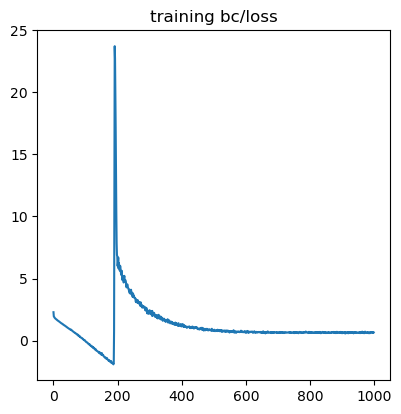

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

y_data = data[:, 5]
x_data = range(0, len(y_data)*2, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(data[:, 3])
# plt.plot(x_data, y_data)
plt.title("training bc/loss")
plt.show()

# グラフを保存
plt.savefig('bc_loss.png')


In [16]:
import os

new_name = '24-02-08_e200_cnn_nono_S1_direct_1'
# 新しいファイル名
new_csv_filename = './log/progress_' + new_name + '.csv'
new_txt_filename = './log/log_' + new_name + '.txt'

# 旧ファイル名から新ファイル名への変更
os.rename('./log/progress.csv', new_csv_filename)
os.rename('./log/log.txt', new_txt_filename)

# グラフを保存
# plt.savefig('./log/bc_loss_' + new_name + '.png')

from imitation.util import util
util.save_policy(bc_trainer.policy, './model/bc_policy_' + new_name)
bc_trainer.policy.save('./model/bc_policy' + new_name + '.zip')


In [50]:
# グラフを保存
plt.savefig('./log/bc_loss_' + new_name + '.png')

<Figure size 640x480 with 0 Axes>